## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


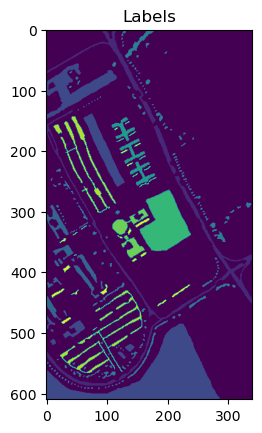

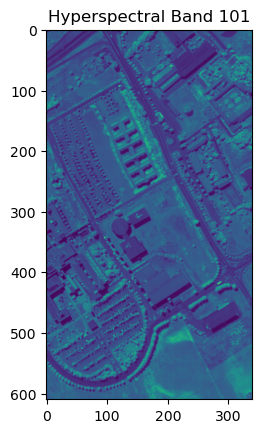

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 20 train


All datasets saved to the 'indices' folder.
(180, 5, 5, 103)
(45, 5, 5, 103)
(42551, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1189, PSNR: 8.2102


	 Training Batch [200/535], Loss: 0.0679, PSNR: 8.5397


	 Training Batch [400/535], Loss: 0.0285, PSNR: 13.7093


Epoch [1/50] Training Loss: 0.0574, PSNR: 11.0329
	[Val]   Batch [1/134] Loss: 0.0197, PSNR: 15.2443
	[Val]   Batch [10/134] Loss: 0.0174, PSNR: 17.5907
	[Val]   Batch [20/134] Loss: 0.0186, PSNR: 15.4074
	[Val]   Batch [30/134] Loss: 0.0202, PSNR: 14.8746
	[Val]   Batch [40/134] Loss: 0.0183, PSNR: 13.9243
	[Val]   Batch [50/134] Loss: 0.0196, PSNR: 15.0567
	[Val]   Batch [60/134] Loss: 0.0176, PSNR: 15.7421


	[Val]   Batch [70/134] Loss: 0.0168, PSNR: 15.9265
	[Val]   Batch [80/134] Loss: 0.0165, PSNR: 15.9062
	[Val]   Batch [90/134] Loss: 0.0172, PSNR: 15.9213
	[Val]   Batch [100/134] Loss: 0.0195, PSNR: 15.3100
	[Val]   Batch [110/134] Loss: 0.0199, PSNR: 13.8260
	[Val]   Batch [120/134] Loss: 0.0162, PSNR: 14.9933
	[Val]   Batch [130/134] Loss: 0.0179, PSNR: 13.0155
Epoch [1/50] Validation Loss: 0.0186, PSNR: 15.2710

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0176, PSNR: 15.7123


	 Training Batch [200/535], Loss: 0.0130, PSNR: 17.0303


	 Training Batch [400/535], Loss: 0.0094, PSNR: 18.4180


Epoch [2/50] Training Loss: 0.0119, PSNR: 17.3809
	[Val]   Batch [1/134] Loss: 0.0089, PSNR: 18.7045
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.4823
	[Val]   Batch [20/134] Loss: 0.0077, PSNR: 19.2258
	[Val]   Batch [30/134] Loss: 0.0088, PSNR: 18.4998
	[Val]   Batch [40/134] Loss: 0.0079, PSNR: 17.5712
	[Val]   Batch [50/134] Loss: 0.0082, PSNR: 18.8349
	[Val]   Batch [60/134] Loss: 0.0071, PSNR: 19.6683


	[Val]   Batch [70/134] Loss: 0.0070, PSNR: 19.7539
	[Val]   Batch [80/134] Loss: 0.0067, PSNR: 19.8275
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.7993
	[Val]   Batch [100/134] Loss: 0.0084, PSNR: 18.9452
	[Val]   Batch [110/134] Loss: 0.0080, PSNR: 17.7667
	[Val]   Batch [120/134] Loss: 0.0059, PSNR: 19.3690
	[Val]   Batch [130/134] Loss: 0.0072, PSNR: 16.9546
Epoch [2/50] Validation Loss: 0.0080, PSNR: 18.9626

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0083, PSNR: 18.8822


	 Training Batch [200/535], Loss: 0.0084, PSNR: 18.8991


	 Training Batch [400/535], Loss: 0.0067, PSNR: 19.9172


Epoch [3/50] Training Loss: 0.0070, PSNR: 19.5251
	[Val]   Batch [1/134] Loss: 0.0065, PSNR: 20.0870
	[Val]   Batch [10/134] Loss: 0.0050, PSNR: 22.9817
	[Val]   Batch [20/134] Loss: 0.0055, PSNR: 20.7261
	[Val]   Batch [30/134] Loss: 0.0062, PSNR: 20.0058
	[Val]   Batch [40/134] Loss: 0.0057, PSNR: 18.9868
	[Val]   Batch [50/134] Loss: 0.0058, PSNR: 20.3550


	[Val]   Batch [60/134] Loss: 0.0049, PSNR: 21.2764
	[Val]   Batch [70/134] Loss: 0.0049, PSNR: 21.2576
	[Val]   Batch [80/134] Loss: 0.0047, PSNR: 21.3710
	[Val]   Batch [90/134] Loss: 0.0050, PSNR: 21.2991
	[Val]   Batch [100/134] Loss: 0.0060, PSNR: 20.4006
	[Val]   Batch [110/134] Loss: 0.0055, PSNR: 19.4048
	[Val]   Batch [120/134] Loss: 0.0039, PSNR: 21.2126
	[Val]   Batch [130/134] Loss: 0.0050, PSNR: 18.5579
Epoch [3/50] Validation Loss: 0.0057, PSNR: 20.4234

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0068, PSNR: 19.8977


	 Training Batch [200/535], Loss: 0.0049, PSNR: 21.5833


	 Training Batch [400/535], Loss: 0.0052, PSNR: 21.0844


Epoch [4/50] Training Loss: 0.0054, PSNR: 20.7151
	[Val]   Batch [1/134] Loss: 0.0048, PSNR: 21.3816
	[Val]   Batch [10/134] Loss: 0.0038, PSNR: 24.2344
	[Val]   Batch [20/134] Loss: 0.0040, PSNR: 22.0967
	[Val]   Batch [30/134] Loss: 0.0045, PSNR: 21.3821
	[Val]   Batch [40/134] Loss: 0.0042, PSNR: 20.3494
	[Val]   Batch [50/134] Loss: 0.0041, PSNR: 21.8410
	[Val]   Batch [60/134] Loss: 0.0037, PSNR: 22.5125


	[Val]   Batch [70/134] Loss: 0.0037, PSNR: 22.5090
	[Val]   Batch [80/134] Loss: 0.0035, PSNR: 22.6700
	[Val]   Batch [90/134] Loss: 0.0037, PSNR: 22.5968
	[Val]   Batch [100/134] Loss: 0.0045, PSNR: 21.6866
	[Val]   Batch [110/134] Loss: 0.0039, PSNR: 20.9103
	[Val]   Batch [120/134] Loss: 0.0028, PSNR: 22.6565
	[Val]   Batch [130/134] Loss: 0.0035, PSNR: 20.0559
Epoch [4/50] Validation Loss: 0.0043, PSNR: 21.7212

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0057, PSNR: 22.4759


	 Training Batch [200/535], Loss: 0.0059, PSNR: 20.4552


	 Training Batch [400/535], Loss: 0.0044, PSNR: 21.7572


Epoch [5/50] Training Loss: 0.0039, PSNR: 22.0737
	[Val]   Batch [1/134] Loss: 0.0035, PSNR: 22.7739
	[Val]   Batch [10/134] Loss: 0.0028, PSNR: 25.5508
	[Val]   Batch [20/134] Loss: 0.0028, PSNR: 23.6884
	[Val]   Batch [30/134] Loss: 0.0031, PSNR: 23.0102
	[Val]   Batch [40/134] Loss: 0.0028, PSNR: 22.0168
	[Val]   Batch [50/134] Loss: 0.0027, PSNR: 23.5817
	[Val]   Batch [60/134] Loss: 0.0028, PSNR: 23.6786


	[Val]   Batch [70/134] Loss: 0.0027, PSNR: 23.8331
	[Val]   Batch [80/134] Loss: 0.0026, PSNR: 23.9645
	[Val]   Batch [90/134] Loss: 0.0027, PSNR: 23.8855
	[Val]   Batch [100/134] Loss: 0.0032, PSNR: 23.1383
	[Val]   Batch [110/134] Loss: 0.0026, PSNR: 22.7218
	[Val]   Batch [120/134] Loss: 0.0020, PSNR: 24.1655
	[Val]   Batch [130/134] Loss: 0.0024, PSNR: 21.7133
Epoch [5/50] Validation Loss: 0.0031, PSNR: 23.1480

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0031, PSNR: 25.1067


	 Training Batch [200/535], Loss: 0.0037, PSNR: 22.6275


	 Training Batch [400/535], Loss: 0.0026, PSNR: 23.9015


Epoch [6/50] Training Loss: 0.0030, PSNR: 23.2081
	[Val]   Batch [1/134] Loss: 0.0028, PSNR: 23.7337
	[Val]   Batch [10/134] Loss: 0.0022, PSNR: 26.5708
	[Val]   Batch [20/134] Loss: 0.0021, PSNR: 24.9809
	[Val]   Batch [30/134] Loss: 0.0024, PSNR: 24.2146
	[Val]   Batch [40/134] Loss: 0.0021, PSNR: 23.2902
	[Val]   Batch [50/134] Loss: 0.0020, PSNR: 24.8885
	[Val]   Batch [60/134] Loss: 0.0023, PSNR: 24.6176


	[Val]   Batch [70/134] Loss: 0.0022, PSNR: 24.8456
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 24.9881
	[Val]   Batch [90/134] Loss: 0.0022, PSNR: 24.8605
	[Val]   Batch [100/134] Loss: 0.0025, PSNR: 24.2624
	[Val]   Batch [110/134] Loss: 0.0018, PSNR: 24.1738
	[Val]   Batch [120/134] Loss: 0.0015, PSNR: 25.4391
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 22.9617
Epoch [6/50] Validation Loss: 0.0024, PSNR: 24.2445

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.2155


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.4754


	 Training Batch [400/535], Loss: 0.0026, PSNR: 24.1677


Epoch [7/50] Training Loss: 0.0026, PSNR: 23.9263
	[Val]   Batch [1/134] Loss: 0.0024, PSNR: 24.3277
	[Val]   Batch [10/134] Loss: 0.0019, PSNR: 27.2437
	[Val]   Batch [20/134] Loss: 0.0017, PSNR: 25.8374
	[Val]   Batch [30/134] Loss: 0.0020, PSNR: 24.9548
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.1245
	[Val]   Batch [50/134] Loss: 0.0017, PSNR: 25.7012


	[Val]   Batch [60/134] Loss: 0.0020, PSNR: 25.2496
	[Val]   Batch [70/134] Loss: 0.0019, PSNR: 25.4958
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.6821
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.4826
	[Val]   Batch [100/134] Loss: 0.0021, PSNR: 24.9661
	[Val]   Batch [110/134] Loss: 0.0015, PSNR: 25.0583
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.3126


	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.7136
Epoch [7/50] Validation Loss: 0.0021, PSNR: 24.9540

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.7843


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.4374


	 Training Batch [400/535], Loss: 0.0022, PSNR: 24.7287


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.4430
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.8144
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.7247
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.5170
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.5811
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.7732
	[Val]   Batch [50/134] Loss: 0.0015, PSNR: 26.3388
	[Val]   Batch [60/134] Loss: 0.0018, PSNR: 25.7267


	[Val]   Batch [70/134] Loss: 0.0017, PSNR: 25.9958
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.2012
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 25.9546
	[Val]   Batch [100/134] Loss: 0.0019, PSNR: 25.5181
	[Val]   Batch [110/134] Loss: 0.0013, PSNR: 25.8072
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 26.9733
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.2989
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.5119

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.3882


	 Training Batch [200/535], Loss: 0.0034, PSNR: 23.1447


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.5367


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.8422
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.1368
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 28.0407
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 26.9784
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.9715
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.2188
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.7481
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.0480


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.2936
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.5541
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.2735
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.8704
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.2649
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.3526
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.6699
Epoch [9/50] Validation Loss: 0.0017, PSNR: 25.8838

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.5174


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.5815


	 Training Batch [400/535], Loss: 0.0019, PSNR: 23.6375


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.1012
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.3557
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3057
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2903
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2438
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.5328
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.0188
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.3270


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.5498
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8603
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5347
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1396
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.5871
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.7329
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 24.9539
Epoch [10/50] Validation Loss: 0.0016, PSNR: 26.1637

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 26.8935


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.6746


	 Training Batch [400/535], Loss: 0.0022, PSNR: 24.6638


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.3502
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6704
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6420
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7666
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6706
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0051
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4459
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6759


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.8900
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2274
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8690
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5384
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1186
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.1743
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.3774
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5585

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.5698


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.4543


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.6467


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5719
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9057
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8670
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0976
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 26.9719
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.3200
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.7200
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9418


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1422
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5134
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1357
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7995
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4472
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.5104
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6854
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.8413

LOG: Epoch [13/50]


	 Training Batch [1/535], Loss: 0.0013, PSNR: 25.8921


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0827


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.4731


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7623
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0940
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0306
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3348
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1790
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5202
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8908


	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1393
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3144
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7262
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3211
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9623
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.6716
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6662


	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8902
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0339

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 25.2149


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.9033


	 Training Batch [400/535], Loss: 0.0013, PSNR: 25.1163


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.8863
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3098
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2570
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6704
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4377
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8314
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1542
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4140


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.5703
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9831
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5711
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.2260
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9607
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 28.9943
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2032
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3046

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 24.7341


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.5898


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0349


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.0943
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4872
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4381
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9577
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6913
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0650
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3786
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6346


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7703
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1795
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7694
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4523
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2132
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1922
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4248
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.5227

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.3653


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.6772


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9103


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3020
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6771
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6104
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.2401
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8957
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.2834
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5585
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8758


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0183
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4194
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9840
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6547
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3686
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3704
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.6244
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7305

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.2668


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.1042


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.5032


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4538
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8465
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7588
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4260
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0859
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4464
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7164
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1017


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2047
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6403
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1981
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8410
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5301
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4952
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8265
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9154

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.2734


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.6572


	 Training Batch [400/535], Loss: 0.0011, PSNR: 29.7116


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6039
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1267
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9581
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8278
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4363
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7884
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0190
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4414


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5362
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8848
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4814
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1541
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7721
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7258
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1667
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.2137

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.4601


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.3106


	 Training Batch [400/535], Loss: 0.0010, PSNR: 25.7518


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.8363
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3399
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0960
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0462
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.6639
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0130
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1915
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6982


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7924
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.1194
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.7330
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3856
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8211
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7315
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.3620
Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.4077

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.4228


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.7051


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9383


Epoch [20/50] Training Loss: 0.0013, PSNR: 27.0618
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6340
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3716
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4898
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0328
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.3311
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.5633


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1274
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1635
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.4932
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1164
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7694
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1580
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0937
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6874


Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.7615

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0036


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.6660


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.8233


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.2087
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9701
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6198
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.8124
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4168
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6717
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.9101


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.4367
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.4960
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7518
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.4833
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1597
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.3538
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2128


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0001
Epoch [21/50] Validation Loss: 0.0008, PSNR: 29.0758

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.3536


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.3286


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.3619


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.4080
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2493
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8680
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0362
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6790
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9136
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1514
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.7028
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.8097


	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0144
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7982
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4305
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4400
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3589
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2312
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.3281

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.3638


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.5027


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.1267


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.6037
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.4962
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0418
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.1950
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.9551
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.1086
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.3813
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8956
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 30.0401


	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.1801
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0605
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6690
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5578
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3978
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3893
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.5416

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.3398


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.8502


	 Training Batch [400/535], Loss: 0.0008, PSNR: 28.9874


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7384
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8714
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3712
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5554
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3418
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4377
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7814
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2506


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3967
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5041
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4634
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0625
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8306
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6796
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7261
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.9034

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 29.0523


	 Training Batch [200/535], Loss: 0.0007, PSNR: 28.0499


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.2607


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.8900
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0576
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4768
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5259
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4782
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4304
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8131
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2858


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5151
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5769
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5720
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1705
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7872
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6644
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7030
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.9916

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.1672


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.4156


	 Training Batch [400/535], Loss: 0.0006, PSNR: 27.4888


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.1104
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2569
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6326
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6932
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6845
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5190
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9800
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4776


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6358
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.6872
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7348
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3275
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8901
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7010
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7956
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.1600

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.2134


	 Training Batch [200/535], Loss: 0.0007, PSNR: 28.0837


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.4711


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.2588
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.6190
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.8956
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0113
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.9941
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.8573
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.2803
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7252


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.0055
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9717
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1004
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.6481
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1179
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0094
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1369
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.4768
Early stopping triggered at epoch 27. No improvement for 3 epochs.


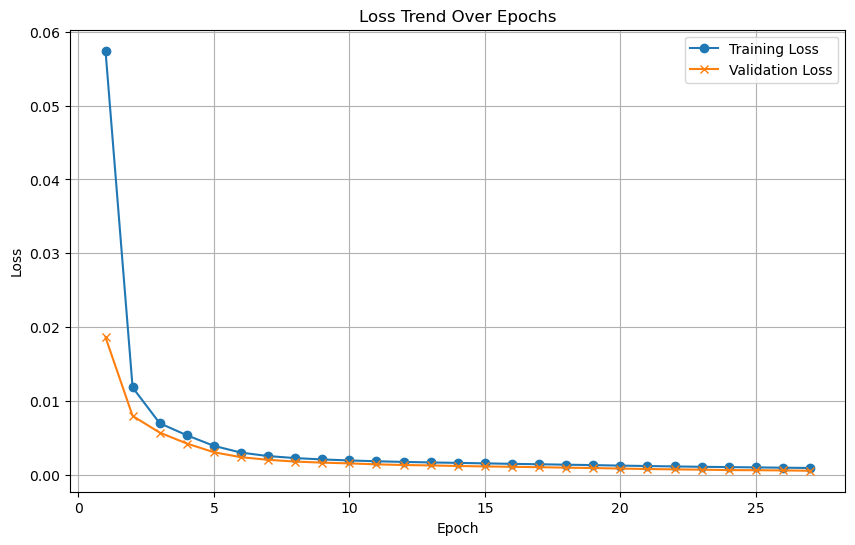

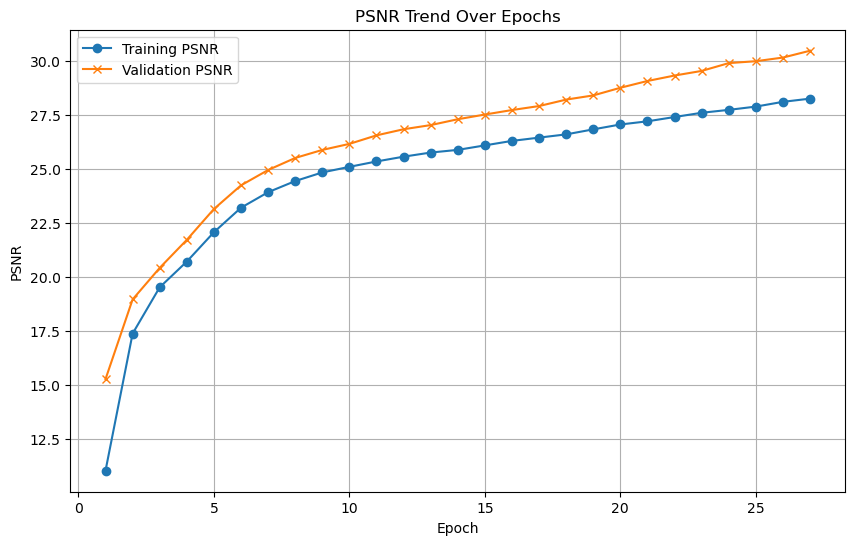

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2005
    Validation Batch [1/1], Loss: 2.2023
Validation Loss: 2.2023, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2023. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1472
    Validation Batch [1/1], Loss: 2.2023
Validation Loss: 2.2023, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0984
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0762
    Validation Batch [1/1], Loss: 2.2025
Validation Loss: 2.2025, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

Epoch [20/1000] completed, Average Training Loss: 1.8248
    Validation Batch [1/1], Loss: 2.1987
Validation Loss: 2.1987, Validation Accuracy: 11.11%
Validation loss improved from 2.1996 to 2.1987. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 1.8038
    Validation Batch [1/1], Loss: 2.1975
Validation Loss: 2.1975, Validation Accuracy: 11.11%
Validation loss improved from 2.1987 to 2.1975. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.7905
    Validation Batch [1/1], Loss: 2.1958
Validation Loss: 2.1958, Validation Accuracy: 11.11%
Validation loss improved from 2.1975 to 2.1958. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8075
    Validation Batch [1/1], Loss: 2.1936
Validation Loss: 2.1936, Validation Accuracy: 11.11%
Validation loss improved from 2.1958 to 2.1936. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [2

Epoch [49/1000] completed, Average Training Loss: 1.5361
    Validation Batch [1/1], Loss: 1.8205
Validation Loss: 1.8205, Validation Accuracy: 48.89%
Validation loss improved from 1.8436 to 1.8205. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.5600
    Validation Batch [1/1], Loss: 1.7977
Validation Loss: 1.7977, Validation Accuracy: 48.89%
Validation loss improved from 1.8205 to 1.7977. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.5356
    Validation Batch [1/1], Loss: 1.7759
Validation Loss: 1.7759, Validation Accuracy: 48.89%
Validation loss improved from 1.7977 to 1.7759. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.5263
    Validation Batch [1/1], Loss: 1.7571
Validation Loss: 1.7571, Validation Accuracy: 48.89%
Validation loss improved from 1.7759 to 1.7571. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [5

Epoch [79/1000] completed, Average Training Loss: 1.2923
    Validation Batch [1/1], Loss: 1.4227
Validation Loss: 1.4227, Validation Accuracy: 71.11%
Validation loss improved from 1.4266 to 1.4227. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.3207
    Validation Batch [1/1], Loss: 1.4186
Validation Loss: 1.4186, Validation Accuracy: 71.11%
Validation loss improved from 1.4227 to 1.4186. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.3022
    Validation Batch [1/1], Loss: 1.4124
Validation Loss: 1.4124, Validation Accuracy: 71.11%
Validation loss improved from 1.4186 to 1.4124. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.3040
    Validation Batch [1/1], Loss: 1.4044
Validation Loss: 1.4044, Validation Accuracy: 71.11%
Validation loss improved from 1.4124 to 1.4044. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [8

Epoch [109/1000] completed, Average Training Loss: 1.0755
    Validation Batch [1/1], Loss: 1.2209
Validation Loss: 1.2209, Validation Accuracy: 75.56%
Validation loss improved from 1.2209 to 1.2209. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.0433
    Validation Batch [1/1], Loss: 1.2168
Validation Loss: 1.2168, Validation Accuracy: 75.56%
Validation loss improved from 1.2209 to 1.2168. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.0360
    Validation Batch [1/1], Loss: 1.2037
Validation Loss: 1.2037, Validation Accuracy: 77.78%
Validation loss improved from 1.2168 to 1.2037. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.0900
    Validation Batch [1/1], Loss: 1.1930
Validation Loss: 1.1930, Validation Accuracy: 77.78%
Validation loss improved from 1.2037 to 1.1930. Saving model...

LOG: Epoch [113/1000] - Training


    Validation Batch [1/1], Loss: 1.0327
Validation Loss: 1.0327, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.8195
    Validation Batch [1/1], Loss: 1.0284
Validation Loss: 1.0284, Validation Accuracy: 84.44%
Validation loss improved from 1.0311 to 1.0284. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.8213
    Validation Batch [1/1], Loss: 1.0182
Validation Loss: 1.0182, Validation Accuracy: 84.44%
Validation loss improved from 1.0284 to 1.0182. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.8446
    Validation Batch [1/1], Loss: 1.0084
Validation Loss: 1.0084, Validation Accuracy: 84.44%
Validation loss improved from 1.0182 to 1.0084. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 0.8193
    Validation 

    Validation Batch [1/1], Loss: 0.8853
Validation Loss: 0.8853, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.6459
    Validation Batch [1/1], Loss: 0.8645
Validation Loss: 0.8645, Validation Accuracy: 84.44%
Validation loss improved from 0.8793 to 0.8645. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.6428
    Validation Batch [1/1], Loss: 0.8684
Validation Loss: 0.8684, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.6088
    Validation Batch [1/1], Loss: 0.8886
Validation Loss: 0.8886, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.6252
    Validation Batch [1/1], Loss: 0.8556
Vali

Epoch [194/1000] completed, Average Training Loss: 0.4442
    Validation Batch [1/1], Loss: 0.7458
Validation Loss: 0.7458, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.4517
    Validation Batch [1/1], Loss: 0.7741
Validation Loss: 0.7741, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.4505
    Validation Batch [1/1], Loss: 0.7397
Validation Loss: 0.7397, Validation Accuracy: 84.44%
Validation loss improved from 0.7449 to 0.7397. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.4573
    Validation Batch [1/1], Loss: 0.7602
Validation Loss: 0.7602, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.6805
Validation Loss: 0.6805, Validation Accuracy: 86.67%
Validation loss improved from 0.6811 to 0.6805. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.3094
    Validation Batch [1/1], Loss: 0.6692
Validation Loss: 0.6692, Validation Accuracy: 86.67%
Validation loss improved from 0.6805 to 0.6692. Saving model...

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.3319
    Validation Batch [1/1], Loss: 0.6711
Validation Loss: 0.6711, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.3213
    Validation Batch [1/1], Loss: 0.6794
Validation Loss: 0.6794, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.3267
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.6117
Validation Loss: 0.6117, Validation Accuracy: 86.67%
Validation loss improved from 0.6177 to 0.6117. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.2605
    Validation Batch [1/1], Loss: 0.6746
Validation Loss: 0.6746, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.2359
    Validation Batch [1/1], Loss: 0.6709
Validation Loss: 0.6709, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.2380
    Validation Batch [1/1], Loss: 0.5838
Validation Loss: 0.5838, Validation Accuracy: 84.44%
Validation loss improved from 0.6117 to 0.5838. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.2445
    Validation Batch [1/1], Lo

Epoch [282/1000] completed, Average Training Loss: 0.1787
    Validation Batch [1/1], Loss: 0.6226
Validation Loss: 0.6226, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.1855
    Validation Batch [1/1], Loss: 0.5959
Validation Loss: 0.5959, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.1893
    Validation Batch [1/1], Loss: 0.5652
Validation Loss: 0.5652, Validation Accuracy: 86.67%
Validation loss improved from 0.5825 to 0.5652. Saving model...

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.1699
    Validation Batch [1/1], Loss: 0.5714
Validation Loss: 0.5714, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.6044
Validation Loss: 0.6044, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1427
    Validation Batch [1/1], Loss: 0.5780
Validation Loss: 0.5780, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1341
    Validation Batch [1/1], Loss: 0.5835
Validation Loss: 0.5835, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1500
    Validation Batch [1/1], Loss: 0.6182
Validation Loss: 0.6182, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.1430
    Validation Batch [1/1], Loss: 0.6196
Validation Loss: 

    Validation Batch [1/1], Loss: 0.5839
Validation Loss: 0.5839, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.1083
    Validation Batch [1/1], Loss: 0.5895
Validation Loss: 0.5895, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0923
    Validation Batch [1/1], Loss: 0.6006
Validation Loss: 0.6006, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.1123
    Validation Batch [1/1], Loss: 0.5913
Validation Loss: 0.5913, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.1255
    Validation Batch [1/1], Loss: 0.5901
Validation Loss

Epoch [371/1000] completed, Average Training Loss: 0.0900
    Validation Batch [1/1], Loss: 0.5470
Validation Loss: 0.5470, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.5700
Validation Loss: 0.5700, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.6183
Validation Loss: 0.6183, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0904
    Validation Batch [1/1], Loss: 0.6090
Validation Loss: 0.6090, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.092

Epoch [400/1000] completed, Average Training Loss: 0.0858
    Validation Batch [1/1], Loss: 0.5684
Validation Loss: 0.5684, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.6137
Validation Loss: 0.6137, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0818
    Validation Batch [1/1], Loss: 0.6168
Validation Loss: 0.6168, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.5736
Validation Loss: 0.5736, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.068

Epoch [429/1000] completed, Average Training Loss: 0.0783
    Validation Batch [1/1], Loss: 0.5759
Validation Loss: 0.5759, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.0629
    Validation Batch [1/1], Loss: 0.5665
Validation Loss: 0.5665, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.0697
    Validation Batch [1/1], Loss: 0.5941
Validation Loss: 0.5941, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0653
    Validation Batch [1/1], Loss: 0.6437
Validation Loss: 0.6437, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.068

Epoch [459/1000] completed, Average Training Loss: 0.0609
    Validation Batch [1/1], Loss: 0.5296
Validation Loss: 0.5296, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0593
    Validation Batch [1/1], Loss: 0.5565
Validation Loss: 0.5565, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.5916
Validation Loss: 0.5916, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.6005
Validation Loss: 0.6005, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.052

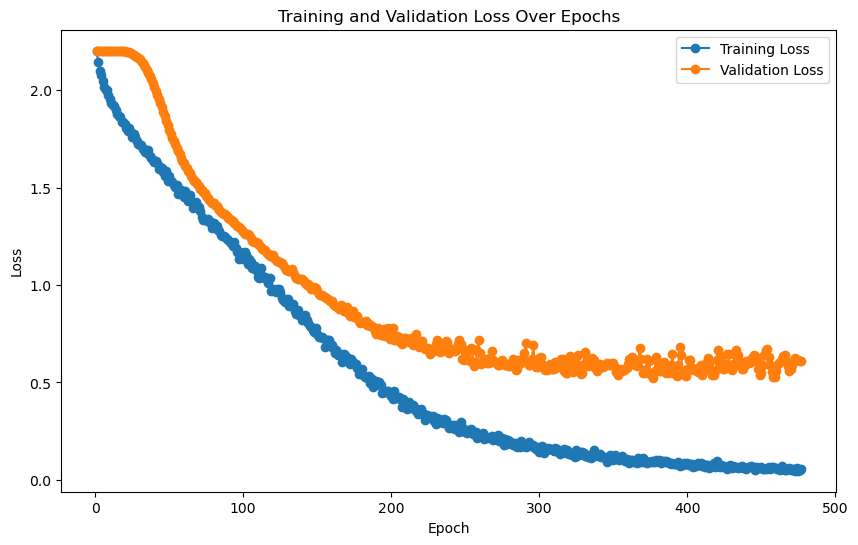

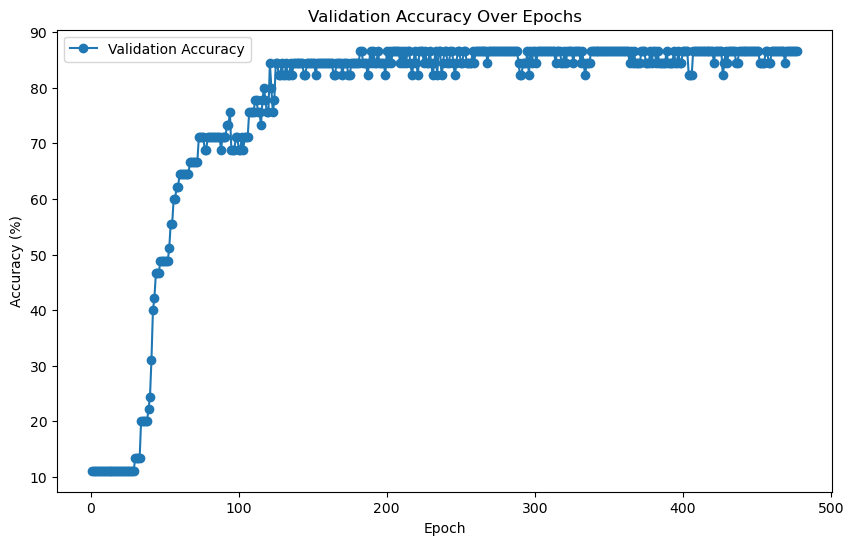


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.9612



Final Test Loss: 0.6559, Test Accuracy: 79.50%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42551, 64), Test labels shape: (42551,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.83      1.00      0.91         5
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.62      1.00      0.77         5
           7       0.62      1.00      0.77         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42551, 64)
Test labels shape: (42551,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4480  |  Val Loss: 2.1309
Validation loss improved from inf to 2.1309.
[Epoch 2/1000] Train Loss: 2.1149  |  Val Loss: 1.9817
Validation loss improved from 2.1309 to 1.9817.
[Epoch 3/1000] Train Loss: 1.9743  |  Val Loss: 1.8516
Validation loss improved from 1.9817 to 1.8516.
[Epoch 4/1000] Train Loss: 1.8392  |  Val Loss: 1.7412
Validation loss improved from 1.8516 to 1.7412.
[Epoch 5/1000] Train Loss: 1.7397  |  Val Loss: 1.6637
Validation loss improved from 1.7412 to 1.6637.
[Epoch 6/1000] Train Loss: 1.6688  |  Val Loss: 1.5831
Validation loss improved from 1.6637 to 1.5831.


[Epoch 7/1000] Train Loss: 1.5842  |  Val Loss: 1.5062
Validation loss improved from 1.5831 to 1.5062.
[Epoch 8/1000] Train Loss: 1.5015  |  Val Loss: 1.4412
Validation loss improved from 1.5062 to 1.4412.
[Epoch 9/1000] Train Loss: 1.4248  |  Val Loss: 1.3863
Validation loss improved from 1.4412 to 1.3863.
[Epoch 10/1000] Train Loss: 1.3650  |  Val Loss: 1.3370
Validation loss improved from 1.3863 to 1.3370.
[Epoch 11/1000] Train Loss: 1.3084  |  Val Loss: 1.2800
Validation loss improved from 1.3370 to 1.2800.
[Epoch 12/1000] Train Loss: 1.2538  |  Val Loss: 1.2282
Validation loss improved from 1.2800 to 1.2282.
[Epoch 13/1000] Train Loss: 1.2029  |  Val Loss: 1.1804
Validation loss improved from 1.2282 to 1.1804.
[Epoch 14/1000] Train Loss: 1.1549  |  Val Loss: 1.1365
Validation loss improved from 1.1804 to 1.1365.
[Epoch 15/1000] Train Loss: 1.1105  |  Val Loss: 1.0940
Validation loss improved from 1.1365 to 1.0940.
[Epoch 16/1000] Train Loss: 1.0643  |  Val Loss: 1.0520
Validation 

[Epoch 24/1000] Train Loss: 0.7245  |  Val Loss: 0.7537
Validation loss improved from 0.7873 to 0.7537.
[Epoch 25/1000] Train Loss: 0.6910  |  Val Loss: 0.7247
Validation loss improved from 0.7537 to 0.7247.
[Epoch 26/1000] Train Loss: 0.6584  |  Val Loss: 0.6987
Validation loss improved from 0.7247 to 0.6987.
[Epoch 27/1000] Train Loss: 0.6216  |  Val Loss: 0.6763
Validation loss improved from 0.6987 to 0.6763.
[Epoch 28/1000] Train Loss: 0.5919  |  Val Loss: 0.6566
Validation loss improved from 0.6763 to 0.6566.
[Epoch 29/1000] Train Loss: 0.5642  |  Val Loss: 0.6356
Validation loss improved from 0.6566 to 0.6356.
[Epoch 30/1000] Train Loss: 0.5389  |  Val Loss: 0.6212
Validation loss improved from 0.6356 to 0.6212.
[Epoch 31/1000] Train Loss: 0.5160  |  Val Loss: 0.6082
Validation loss improved from 0.6212 to 0.6082.
[Epoch 32/1000] Train Loss: 0.4941  |  Val Loss: 0.5938
Validation loss improved from 0.6082 to 0.5938.
[Epoch 33/1000] Train Loss: 0.4709  |  Val Loss: 0.5788
Validati

[Epoch 37/1000] Train Loss: 0.4023  |  Val Loss: 0.5479
Validation loss improved from 0.5531 to 0.5479.
[Epoch 38/1000] Train Loss: 0.3916  |  Val Loss: 0.5511
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.3778  |  Val Loss: 0.5407
Validation loss improved from 0.5479 to 0.5407.
[Epoch 40/1000] Train Loss: 0.3683  |  Val Loss: 0.5292
Validation loss improved from 0.5407 to 0.5292.
[Epoch 41/1000] Train Loss: 0.3574  |  Val Loss: 0.5365
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.3452  |  Val Loss: 0.5296
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 0.3329  |  Val Loss: 0.5378
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 0.3257  |  Val Loss: 0.5322
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 45/1000] Train Loss: 0.3152  |  Val Loss: 0.5263
Validation loss improved from 0.5292 to 0.5263.
[Epoch 46/1000] Train Loss: 0.3083

[Epoch 58/1000] Train Loss: 0.2512  |  Val Loss: 0.5305
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.2422  |  Val Loss: 0.5152
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 0.2363  |  Val Loss: 0.5419
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 61/1000] Train Loss: 0.2374  |  Val Loss: 0.5299
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 62/1000] Train Loss: 0.2300  |  Val Loss: 0.5383
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 63/1000] Train Loss: 0.2247  |  Val Loss: 0.5418
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 64/1000] Train Loss: 0.2212  |  Val Loss: 0.5329
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 65/1000] Train Loss: 0.2180  |  Val Loss: 0.5281
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 66/1000] Train Loss: 0.2156  |  Val Loss: 0.5459
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 6

[Epoch 69/1000] Train Loss: 0.2133  |  Val Loss: 0.5542
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 70/1000] Train Loss: 0.2005  |  Val Loss: 0.5607
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 71/1000] Train Loss: 0.2168  |  Val Loss: 0.5641
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 72/1000] Train Loss: 0.1996  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 73/1000] Train Loss: 0.2075  |  Val Loss: 0.5579
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 74/1000] Train Loss: 0.1923  |  Val Loss: 0.5900
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 75/1000] Train Loss: 0.1967  |  Val Loss: 0.5539
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 76/1000] Train Loss: 0.1871  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 77/1000] Train Loss: 0.1882  |  Val Loss: 0.5528
!! Validation loss did NOT improve !! Patience: 22/100
[

[Epoch 91/1000] Train Loss: 0.1543  |  Val Loss: 0.5957
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 92/1000] Train Loss: 0.1534  |  Val Loss: 0.6071
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 93/1000] Train Loss: 0.1485  |  Val Loss: 0.5810
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 94/1000] Train Loss: 0.1483  |  Val Loss: 0.5734
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 95/1000] Train Loss: 0.1509  |  Val Loss: 0.6020
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 96/1000] Train Loss: 0.1452  |  Val Loss: 0.6080
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 97/1000] Train Loss: 0.1396  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 98/1000] Train Loss: 0.1399  |  Val Loss: 0.5976
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 99/1000] Train Loss: 0.1445  |  Val Loss: 0.5882
!! Validation loss did NOT improve !! Patience: 44/100
[

[Epoch 101/1000] Train Loss: 0.1379  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 102/1000] Train Loss: 0.1441  |  Val Loss: 0.6091
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 103/1000] Train Loss: 0.1441  |  Val Loss: 0.6325
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 104/1000] Train Loss: 0.1325  |  Val Loss: 0.6154
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 105/1000] Train Loss: 0.1324  |  Val Loss: 0.6164
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 106/1000] Train Loss: 0.1249  |  Val Loss: 0.6297
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 107/1000] Train Loss: 0.1249  |  Val Loss: 0.6438
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 108/1000] Train Loss: 0.1220  |  Val Loss: 0.6176
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 109/1000] Train Loss: 0.1215  |  Val Loss: 0.6223
!! Validation loss did NOT improve !! Patience:

[Epoch 124/1000] Train Loss: 0.0975  |  Val Loss: 0.6987
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 125/1000] Train Loss: 0.0959  |  Val Loss: 0.6929
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 126/1000] Train Loss: 0.0963  |  Val Loss: 0.6658
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 127/1000] Train Loss: 0.1003  |  Val Loss: 0.6779
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 128/1000] Train Loss: 0.0923  |  Val Loss: 0.7029
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 129/1000] Train Loss: 0.1027  |  Val Loss: 0.6989
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 130/1000] Train Loss: 0.0955  |  Val Loss: 0.6947
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 131/1000] Train Loss: 0.1050  |  Val Loss: 0.7353
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 132/1000] Train Loss: 0.0991  |  Val Loss: 0.7014
!! Validation loss did NOT improve !! Patience:

[Epoch 133/1000] Train Loss: 0.1006  |  Val Loss: 0.7066
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 134/1000] Train Loss: 0.0928  |  Val Loss: 0.7496
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 135/1000] Train Loss: 0.0896  |  Val Loss: 0.7041
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 136/1000] Train Loss: 0.0903  |  Val Loss: 0.6860
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 137/1000] Train Loss: 0.0870  |  Val Loss: 0.7451
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 138/1000] Train Loss: 0.0873  |  Val Loss: 0.7457
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 139/1000] Train Loss: 0.0861  |  Val Loss: 0.7401
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 140/1000] Train Loss: 0.0864  |  Val Loss: 0.7397
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 141/1000] Train Loss: 0.0823  |  Val Loss: 0.6958
!! Validation loss did NOT improve !! Patience:

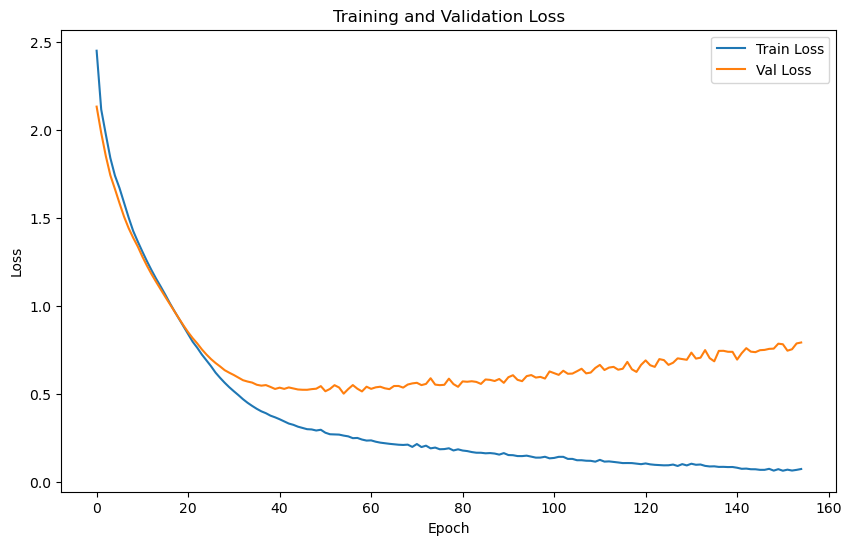

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.1288 | Test Accuracy: 73.35%


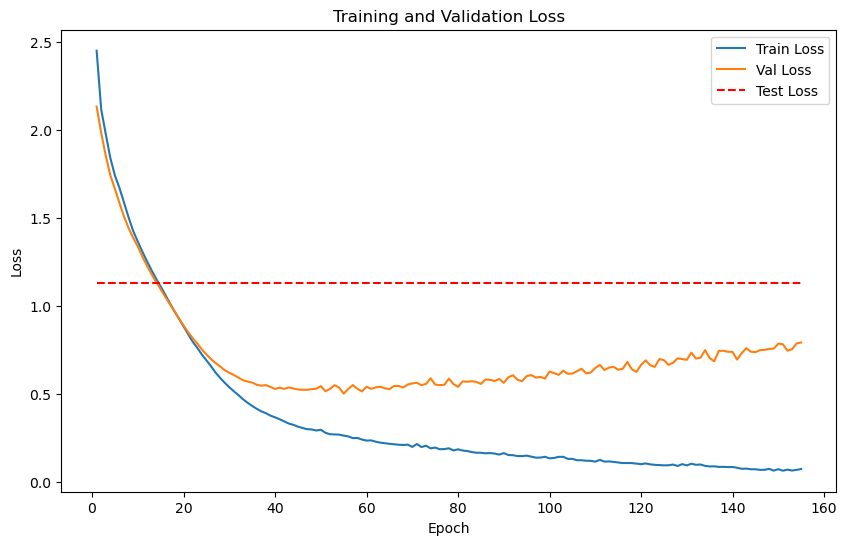

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.0580
Epoch [1/2000], Avg Train Loss: 9.0580
Epoch [1/2000], Avg Val Loss: 3.8849
Validation loss improved from inf to 3.8849. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.7643
Epoch [2/2000], Avg Train Loss: 8.7643
Epoch [2/2000], Avg Val Loss: 3.8495
Validation loss improved from 3.8849 to 3.8495. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7227
Epoch [3/2000], Avg Train Loss: 8.7227
Epoch [3/2000], Avg Val Loss: 3.8150
Validation loss improved from 3.8495 to 3.8150. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.8438
Epoch [4/2000], Avg Train Loss: 8.8438
Epoch [4/2000], Avg Val Loss: 3.7818
Validation loss improved from 3.8150 to 3.7818. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7756
Epoch [5/2000], Avg Train Loss: 8.7756
Epoch [5/2000], Avg Val Loss: 3.7497
Validation loss improved from 3.7818 to 3.7497. Saving mode

Epoch [11/2000], Avg Val Loss: 3.5771
Validation loss improved from 3.6038 to 3.5771. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.2426
Epoch [12/2000], Avg Train Loss: 8.2426
Epoch [12/2000], Avg Val Loss: 3.5513
Validation loss improved from 3.5771 to 3.5513. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.0639
Epoch [13/2000], Avg Train Loss: 8.0639
Epoch [13/2000], Avg Val Loss: 3.5262
Validation loss improved from 3.5513 to 3.5262. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.9623
Epoch [14/2000], Avg Train Loss: 7.9623
Epoch [14/2000], Avg Val Loss: 3.5020
Validation loss improved from 3.5262 to 3.5020. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.9558
Epoch [15/2000], Avg Train Loss: 7.9558
Epoch [15/2000], Avg Val Loss: 3.4786
Validation loss improved from 3.5020 to 3.4786. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.1901
Epoch [28/2000], Avg Train Loss: 7.1901
Epoch [28/2000], Avg Val Loss: 3.2370
Validation loss improved from 3.2520 to 3.2370. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.1238
Epoch [29/2000], Avg Train Loss: 7.1238
Epoch [29/2000], Avg Val Loss: 3.2226
Validation loss improved from 3.2370 to 3.2226. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 7.0448
Epoch [30/2000], Avg Train Loss: 7.0448
Epoch [30/2000], Avg Val Loss: 3.2086
Validation loss improved from 3.2226 to 3.2086. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.9027
Epoch [31/2000], Avg Train Loss: 6.9027
Epoch [31/2000], Avg Val Loss: 3.1952
Validation loss improved from 3.2086 to 3.1952. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.8486
Epoch [32/2000], Avg Train Loss: 6.8486
Epoch [32/2000], Avg Val Loss: 3.1822
Validation loss improved from 3.1952 to 3.

    Batch [1/1], Train Loss: 6.1198
Epoch [48/2000], Avg Train Loss: 6.1198
Epoch [48/2000], Avg Val Loss: 3.0286
Validation loss improved from 3.0358 to 3.0286. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.0394
Epoch [49/2000], Avg Train Loss: 6.0394
Epoch [49/2000], Avg Val Loss: 3.0216
Validation loss improved from 3.0286 to 3.0216. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2094
Epoch [50/2000], Avg Train Loss: 6.2094
Epoch [50/2000], Avg Val Loss: 3.0149
Validation loss improved from 3.0216 to 3.0149. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.0805
Epoch [51/2000], Avg Train Loss: 6.0805
Epoch [51/2000], Avg Val Loss: 3.0084
Validation loss improved from 3.0149 to 3.0084. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.0620
Epoch [52/2000], Avg Train Loss: 6.0620
Epoch [52/2000], Avg Val Loss: 3.0021
Validation loss improved from 3.0084 to 3.

Epoch [57/2000], Avg Val Loss: 2.9739
Validation loss improved from 2.9792 to 2.9739. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.8515
Epoch [58/2000], Avg Train Loss: 5.8515
Epoch [58/2000], Avg Val Loss: 2.9688
Validation loss improved from 2.9739 to 2.9688. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.8100
Epoch [59/2000], Avg Train Loss: 5.8100
Epoch [59/2000], Avg Val Loss: 2.9639
Validation loss improved from 2.9688 to 2.9639. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.8237
Epoch [60/2000], Avg Train Loss: 5.8237
Epoch [60/2000], Avg Val Loss: 2.9591
Validation loss improved from 2.9639 to 2.9591. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.8056
Epoch [61/2000], Avg Train Loss: 5.8056
Epoch [61/2000], Avg Val Loss: 2.9544
Validation loss improved from 2.9591 to 2.9544. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.4474
Epoch [71/2000], Avg Train Loss: 5.4474
Epoch [71/2000], Avg Val Loss: 2.9156
Validation loss improved from 2.9189 to 2.9156. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.5844
Epoch [72/2000], Avg Train Loss: 5.5844
Epoch [72/2000], Avg Val Loss: 2.9124
Validation loss improved from 2.9156 to 2.9124. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.5050
Epoch [73/2000], Avg Train Loss: 5.5050
Epoch [73/2000], Avg Val Loss: 2.9093
Validation loss improved from 2.9124 to 2.9093. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.4775
Epoch [74/2000], Avg Train Loss: 5.4775
Epoch [74/2000], Avg Val Loss: 2.9064
Validation loss improved from 2.9093 to 2.9064. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.4265
Epoch [75/2000], Avg Train Loss: 5.4265
Epoch [75/2000], Avg Val Loss: 2.9035
Validation loss improved from 2.9064 to 2.

    Batch [1/1], Train Loss: 5.1229
Epoch [94/2000], Avg Train Loss: 5.1229
Epoch [94/2000], Avg Val Loss: 2.8594
Validation loss improved from 2.8614 to 2.8594. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.1218
Epoch [95/2000], Avg Train Loss: 5.1218
Epoch [95/2000], Avg Val Loss: 2.8574
Validation loss improved from 2.8594 to 2.8574. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.0551
Epoch [96/2000], Avg Train Loss: 5.0551
Epoch [96/2000], Avg Val Loss: 2.8555
Validation loss improved from 2.8574 to 2.8555. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.1462
Epoch [97/2000], Avg Train Loss: 5.1462
Epoch [97/2000], Avg Val Loss: 2.8536
Validation loss improved from 2.8555 to 2.8536. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.0071
Epoch [98/2000], Avg Train Loss: 5.0071
Epoch [98/2000], Avg Val Loss: 2.8517
Validation loss improved from 2.8536 to 2.

    Batch [1/1], Train Loss: 4.9861
Epoch [102/2000], Avg Train Loss: 4.9861
Epoch [102/2000], Avg Val Loss: 2.8444
Validation loss improved from 2.8462 to 2.8444. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.0135
Epoch [103/2000], Avg Train Loss: 5.0135
Epoch [103/2000], Avg Val Loss: 2.8426
Validation loss improved from 2.8444 to 2.8426. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.0134
Epoch [104/2000], Avg Train Loss: 5.0134
Epoch [104/2000], Avg Val Loss: 2.8408
Validation loss improved from 2.8426 to 2.8408. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.0657
Epoch [105/2000], Avg Train Loss: 5.0657
Epoch [105/2000], Avg Val Loss: 2.8391
Validation loss improved from 2.8408 to 2.8391. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.9292
Epoch [106/2000], Avg Train Loss: 4.9292
Epoch [106/2000], Avg Val Loss: 2.8373
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8997
Epoch [113/2000], Avg Train Loss: 4.8997
Epoch [113/2000], Avg Val Loss: 2.8253
Validation loss improved from 2.8270 to 2.8253. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.9456
Epoch [114/2000], Avg Train Loss: 4.9456
Epoch [114/2000], Avg Val Loss: 2.8237
Validation loss improved from 2.8253 to 2.8237. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.9386
Epoch [115/2000], Avg Train Loss: 4.9386
Epoch [115/2000], Avg Val Loss: 2.8220
Validation loss improved from 2.8237 to 2.8220. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.8822
Epoch [116/2000], Avg Train Loss: 4.8822
Epoch [116/2000], Avg Val Loss: 2.8203
Validation loss improved from 2.8220 to 2.8203. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.8272
Epoch [117/2000], Avg Train Loss: 4.8272
Epoch [117/2000], Avg Val Loss: 2.8186
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7617
Epoch [131/2000], Avg Train Loss: 4.7617
Epoch [131/2000], Avg Val Loss: 2.7943
Validation loss improved from 2.7961 to 2.7943. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.8935
Epoch [132/2000], Avg Train Loss: 4.8935
Epoch [132/2000], Avg Val Loss: 2.7926
Validation loss improved from 2.7943 to 2.7926. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.8048
Epoch [133/2000], Avg Train Loss: 4.8048
Epoch [133/2000], Avg Val Loss: 2.7910
Validation loss improved from 2.7926 to 2.7910. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.8194
Epoch [134/2000], Avg Train Loss: 4.8194
Epoch [134/2000], Avg Val Loss: 2.7893
Validation loss improved from 2.7910 to 2.7893. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.7214
Epoch [135/2000], Avg Train Loss: 4.7214
Epoch [135/2000], Avg Val Loss: 2.7876
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6888
Epoch [146/2000], Avg Train Loss: 4.6888
Epoch [146/2000], Avg Val Loss: 2.7687
Validation loss improved from 2.7705 to 2.7687. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.7667
Epoch [147/2000], Avg Train Loss: 4.7667
Epoch [147/2000], Avg Val Loss: 2.7670
Validation loss improved from 2.7687 to 2.7670. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.7733
Epoch [148/2000], Avg Train Loss: 4.7733
Epoch [148/2000], Avg Val Loss: 2.7653
Validation loss improved from 2.7670 to 2.7653. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.6923
Epoch [149/2000], Avg Train Loss: 4.6923
Epoch [149/2000], Avg Val Loss: 2.7637
Validation loss improved from 2.7653 to 2.7637. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.6683
Epoch [150/2000], Avg Train Loss: 4.6683
Epoch [150/2000], Avg Val Loss: 2.7620
Validation loss improved fro

Epoch [158/2000], Avg Val Loss: 2.7484
Validation loss improved from 2.7501 to 2.7484. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.6660
Epoch [159/2000], Avg Train Loss: 4.6660
Epoch [159/2000], Avg Val Loss: 2.7466
Validation loss improved from 2.7484 to 2.7466. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.6608
Epoch [160/2000], Avg Train Loss: 4.6608
Epoch [160/2000], Avg Val Loss: 2.7450
Validation loss improved from 2.7466 to 2.7450. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.6337
Epoch [161/2000], Avg Train Loss: 4.6337
Epoch [161/2000], Avg Val Loss: 2.7432
Validation loss improved from 2.7450 to 2.7432. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6359
Epoch [162/2000], Avg Train Loss: 4.6359
Epoch [162/2000], Avg Val Loss: 2.7415
Validation loss improved from 2.7432 to 2.7415. Saving model...

LOG: Epoch [163/2000] - Training
    Bat

Epoch [176/2000], Avg Val Loss: 2.7168
Validation loss improved from 2.7186 to 2.7168. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.5713
Epoch [177/2000], Avg Train Loss: 4.5713
Epoch [177/2000], Avg Val Loss: 2.7150
Validation loss improved from 2.7168 to 2.7150. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.4956
Epoch [178/2000], Avg Train Loss: 4.4956
Epoch [178/2000], Avg Val Loss: 2.7131
Validation loss improved from 2.7150 to 2.7131. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.5845
Epoch [179/2000], Avg Train Loss: 4.5845
Epoch [179/2000], Avg Val Loss: 2.7113
Validation loss improved from 2.7131 to 2.7113. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.5808
Epoch [180/2000], Avg Train Loss: 4.5808
Epoch [180/2000], Avg Val Loss: 2.7095
Validation loss improved from 2.7113 to 2.7095. Saving model...

LOG: Epoch [181/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5071
Epoch [193/2000], Avg Train Loss: 4.5071
Epoch [193/2000], Avg Val Loss: 2.6865
Validation loss improved from 2.6882 to 2.6865. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.4932
Epoch [194/2000], Avg Train Loss: 4.4932
Epoch [194/2000], Avg Val Loss: 2.6847
Validation loss improved from 2.6865 to 2.6847. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.4818
Epoch [195/2000], Avg Train Loss: 4.4818
Epoch [195/2000], Avg Val Loss: 2.6829
Validation loss improved from 2.6847 to 2.6829. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.5419
Epoch [196/2000], Avg Train Loss: 4.5419
Epoch [196/2000], Avg Val Loss: 2.6812
Validation loss improved from 2.6829 to 2.6812. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.5076
Epoch [197/2000], Avg Train Loss: 4.5076
Epoch [197/2000], Avg Val Loss: 2.6794
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4688
Epoch [203/2000], Avg Train Loss: 4.4688
Epoch [203/2000], Avg Val Loss: 2.6688
Validation loss improved from 2.6706 to 2.6688. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.5181
Epoch [204/2000], Avg Train Loss: 4.5181
Epoch [204/2000], Avg Val Loss: 2.6671
Validation loss improved from 2.6688 to 2.6671. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 4.5031
Epoch [205/2000], Avg Train Loss: 4.5031
Epoch [205/2000], Avg Val Loss: 2.6654
Validation loss improved from 2.6671 to 2.6654. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 4.4340
Epoch [206/2000], Avg Train Loss: 4.4340
Epoch [206/2000], Avg Val Loss: 2.6636
Validation loss improved from 2.6654 to 2.6636. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 4.4753
Epoch [207/2000], Avg Train Loss: 4.4753
Epoch [207/2000], Avg Val Loss: 2.6619
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4102
Epoch [218/2000], Avg Train Loss: 4.4102
Epoch [218/2000], Avg Val Loss: 2.6429
Validation loss improved from 2.6446 to 2.6429. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.4481
Epoch [219/2000], Avg Train Loss: 4.4481
Epoch [219/2000], Avg Val Loss: 2.6411
Validation loss improved from 2.6429 to 2.6411. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.3777
Epoch [220/2000], Avg Train Loss: 4.3777
Epoch [220/2000], Avg Val Loss: 2.6394
Validation loss improved from 2.6411 to 2.6394. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.3922
Epoch [221/2000], Avg Train Loss: 4.3922
Epoch [221/2000], Avg Val Loss: 2.6376
Validation loss improved from 2.6394 to 2.6376. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.4397
Epoch [222/2000], Avg Train Loss: 4.4397
Epoch [222/2000], Avg Val Loss: 2.6359
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3635
Epoch [234/2000], Avg Train Loss: 4.3635
Epoch [234/2000], Avg Val Loss: 2.6156
Validation loss improved from 2.6173 to 2.6156. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.3852
Epoch [235/2000], Avg Train Loss: 4.3852
Epoch [235/2000], Avg Val Loss: 2.6139
Validation loss improved from 2.6156 to 2.6139. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.3645
Epoch [236/2000], Avg Train Loss: 4.3645
Epoch [236/2000], Avg Val Loss: 2.6122
Validation loss improved from 2.6139 to 2.6122. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.3568
Epoch [237/2000], Avg Train Loss: 4.3568
Epoch [237/2000], Avg Val Loss: 2.6106
Validation loss improved from 2.6122 to 2.6106. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.3686
Epoch [238/2000], Avg Train Loss: 4.3686
Epoch [238/2000], Avg Val Loss: 2.6089
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4206
Epoch [246/2000], Avg Train Loss: 4.4206
Epoch [246/2000], Avg Val Loss: 2.5960
Validation loss improved from 2.5975 to 2.5960. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 4.2850
Epoch [247/2000], Avg Train Loss: 4.2850
Epoch [247/2000], Avg Val Loss: 2.5944
Validation loss improved from 2.5960 to 2.5944. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.3297
Epoch [248/2000], Avg Train Loss: 4.3297
Epoch [248/2000], Avg Val Loss: 2.5928
Validation loss improved from 2.5944 to 2.5928. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 4.3680
Epoch [249/2000], Avg Train Loss: 4.3680
Epoch [249/2000], Avg Val Loss: 2.5913
Validation loss improved from 2.5928 to 2.5913. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.3099
Epoch [250/2000], Avg Train Loss: 4.3099
Epoch [250/2000], Avg Val Loss: 2.5897
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2768
Epoch [264/2000], Avg Train Loss: 4.2768
Epoch [264/2000], Avg Val Loss: 2.5685
Validation loss improved from 2.5700 to 2.5685. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.3280
Epoch [265/2000], Avg Train Loss: 4.3280
Epoch [265/2000], Avg Val Loss: 2.5670
Validation loss improved from 2.5685 to 2.5670. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.2804
Epoch [266/2000], Avg Train Loss: 4.2804
Epoch [266/2000], Avg Val Loss: 2.5655
Validation loss improved from 2.5670 to 2.5655. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.3064
Epoch [267/2000], Avg Train Loss: 4.3064
Epoch [267/2000], Avg Val Loss: 2.5640
Validation loss improved from 2.5655 to 2.5640. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.2773
Epoch [268/2000], Avg Train Loss: 4.2773
Epoch [268/2000], Avg Val Loss: 2.5625
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2833
Epoch [274/2000], Avg Train Loss: 4.2833
Epoch [274/2000], Avg Val Loss: 2.5537
Validation loss improved from 2.5551 to 2.5537. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.3360
Epoch [275/2000], Avg Train Loss: 4.3360
Epoch [275/2000], Avg Val Loss: 2.5522
Validation loss improved from 2.5537 to 2.5522. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.2677
Epoch [276/2000], Avg Train Loss: 4.2677
Epoch [276/2000], Avg Val Loss: 2.5508
Validation loss improved from 2.5522 to 2.5508. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.2464
Epoch [277/2000], Avg Train Loss: 4.2464
Epoch [277/2000], Avg Val Loss: 2.5494
Validation loss improved from 2.5508 to 2.5494. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.2598
Epoch [278/2000], Avg Train Loss: 4.2598
Epoch [278/2000], Avg Val Loss: 2.5480
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2433
Epoch [290/2000], Avg Train Loss: 4.2433
Epoch [290/2000], Avg Val Loss: 2.5313
Validation loss improved from 2.5327 to 2.5313. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.2347
Epoch [291/2000], Avg Train Loss: 4.2347
Epoch [291/2000], Avg Val Loss: 2.5300
Validation loss improved from 2.5313 to 2.5300. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.2259
Epoch [292/2000], Avg Train Loss: 4.2259
Epoch [292/2000], Avg Val Loss: 2.5286
Validation loss improved from 2.5300 to 2.5286. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.2058
Epoch [293/2000], Avg Train Loss: 4.2058
Epoch [293/2000], Avg Val Loss: 2.5273
Validation loss improved from 2.5286 to 2.5273. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.2704
Epoch [294/2000], Avg Train Loss: 4.2704
Epoch [294/2000], Avg Val Loss: 2.5260
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2296
Epoch [306/2000], Avg Train Loss: 4.2296
Epoch [306/2000], Avg Val Loss: 2.5105
Validation loss improved from 2.5118 to 2.5105. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.2295
Epoch [307/2000], Avg Train Loss: 4.2295
Epoch [307/2000], Avg Val Loss: 2.5093
Validation loss improved from 2.5105 to 2.5093. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.1688
Epoch [308/2000], Avg Train Loss: 4.1688
Epoch [308/2000], Avg Val Loss: 2.5080
Validation loss improved from 2.5093 to 2.5080. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.1807
Epoch [309/2000], Avg Train Loss: 4.1807
Epoch [309/2000], Avg Val Loss: 2.5068
Validation loss improved from 2.5080 to 2.5068. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 4.2034
Epoch [310/2000], Avg Train Loss: 4.2034
Epoch [310/2000], Avg Val Loss: 2.5055
Validation loss improved fro

Epoch [314/2000], Avg Val Loss: 2.5006
Validation loss improved from 2.5018 to 2.5006. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.1980
Epoch [315/2000], Avg Train Loss: 4.1980
Epoch [315/2000], Avg Val Loss: 2.4994
Validation loss improved from 2.5006 to 2.4994. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.1555
Epoch [316/2000], Avg Train Loss: 4.1555
Epoch [316/2000], Avg Val Loss: 2.4982
Validation loss improved from 2.4994 to 2.4982. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 4.2198
Epoch [317/2000], Avg Train Loss: 4.2198
Epoch [317/2000], Avg Val Loss: 2.4970
Validation loss improved from 2.4982 to 2.4970. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 4.2023
Epoch [318/2000], Avg Train Loss: 4.2023
Epoch [318/2000], Avg Val Loss: 2.4959
Validation loss improved from 2.4970 to 2.4959. Saving model...

LOG: Epoch [319/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1847
Epoch [333/2000], Avg Train Loss: 4.1847
Epoch [333/2000], Avg Val Loss: 2.4794
Validation loss improved from 2.4804 to 2.4794. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 4.1773
Epoch [334/2000], Avg Train Loss: 4.1773
Epoch [334/2000], Avg Val Loss: 2.4783
Validation loss improved from 2.4794 to 2.4783. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.1819
Epoch [335/2000], Avg Train Loss: 4.1819
Epoch [335/2000], Avg Val Loss: 2.4773
Validation loss improved from 2.4783 to 2.4773. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.1137
Epoch [336/2000], Avg Train Loss: 4.1137
Epoch [336/2000], Avg Val Loss: 2.4763
Validation loss improved from 2.4773 to 2.4763. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.0893
Epoch [337/2000], Avg Train Loss: 4.0893
Epoch [337/2000], Avg Val Loss: 2.4753
Validation loss improved fro

Epoch [347/2000], Avg Val Loss: 2.4649
Validation loss improved from 2.4659 to 2.4649. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.1492
Epoch [348/2000], Avg Train Loss: 4.1492
Epoch [348/2000], Avg Val Loss: 2.4639
Validation loss improved from 2.4649 to 2.4639. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.1452
Epoch [349/2000], Avg Train Loss: 4.1452
Epoch [349/2000], Avg Val Loss: 2.4628
Validation loss improved from 2.4639 to 2.4628. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.1365
Epoch [350/2000], Avg Train Loss: 4.1365
Epoch [350/2000], Avg Val Loss: 2.4618
Validation loss improved from 2.4628 to 2.4618. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.1296
Epoch [351/2000], Avg Train Loss: 4.1296
Epoch [351/2000], Avg Val Loss: 2.4608
Validation loss improved from 2.4618 to 2.4608. Saving model...

LOG: Epoch [352/2000] - Training
    Bat

Epoch [354/2000], Avg Val Loss: 2.4580
Validation loss improved from 2.4589 to 2.4580. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.0807
Epoch [355/2000], Avg Train Loss: 4.0807
Epoch [355/2000], Avg Val Loss: 2.4570
Validation loss improved from 2.4580 to 2.4570. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.1737
Epoch [356/2000], Avg Train Loss: 4.1737
Epoch [356/2000], Avg Val Loss: 2.4561
Validation loss improved from 2.4570 to 2.4561. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.1181
Epoch [357/2000], Avg Train Loss: 4.1181
Epoch [357/2000], Avg Val Loss: 2.4552
Validation loss improved from 2.4561 to 2.4552. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.1109
Epoch [358/2000], Avg Train Loss: 4.1109
Epoch [358/2000], Avg Val Loss: 2.4543
Validation loss improved from 2.4552 to 2.4543. Saving model...

LOG: Epoch [359/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0949
Epoch [375/2000], Avg Train Loss: 4.0949
Epoch [375/2000], Avg Val Loss: 2.4403
Validation loss improved from 2.4411 to 2.4403. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.1291
Epoch [376/2000], Avg Train Loss: 4.1291
Epoch [376/2000], Avg Val Loss: 2.4395
Validation loss improved from 2.4403 to 2.4395. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.0931
Epoch [377/2000], Avg Train Loss: 4.0931
Epoch [377/2000], Avg Val Loss: 2.4387
Validation loss improved from 2.4395 to 2.4387. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.0502
Epoch [378/2000], Avg Train Loss: 4.0502
Epoch [378/2000], Avg Val Loss: 2.4379
Validation loss improved from 2.4387 to 2.4379. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.1078
Epoch [379/2000], Avg Train Loss: 4.1078
Epoch [379/2000], Avg Val Loss: 2.4372
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0481
Epoch [393/2000], Avg Train Loss: 4.0481
Epoch [393/2000], Avg Val Loss: 2.4268
Validation loss improved from 2.4275 to 2.4268. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.0646
Epoch [394/2000], Avg Train Loss: 4.0646
Epoch [394/2000], Avg Val Loss: 2.4261
Validation loss improved from 2.4268 to 2.4261. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.0798
Epoch [395/2000], Avg Train Loss: 4.0798
Epoch [395/2000], Avg Val Loss: 2.4254
Validation loss improved from 2.4261 to 2.4254. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.0934
Epoch [396/2000], Avg Train Loss: 4.0934
Epoch [396/2000], Avg Val Loss: 2.4247
Validation loss improved from 2.4254 to 2.4247. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.9870
Epoch [397/2000], Avg Train Loss: 3.9870
Epoch [397/2000], Avg Val Loss: 2.4240
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0472
Epoch [419/2000], Avg Train Loss: 4.0472
Epoch [419/2000], Avg Val Loss: 2.4091
Validation loss improved from 2.4098 to 2.4091. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.0357
Epoch [420/2000], Avg Train Loss: 4.0357
Epoch [420/2000], Avg Val Loss: 2.4085
Validation loss improved from 2.4091 to 2.4085. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.0279
Epoch [421/2000], Avg Train Loss: 4.0279
Epoch [421/2000], Avg Val Loss: 2.4079
Validation loss improved from 2.4085 to 2.4079. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.0124
Epoch [422/2000], Avg Train Loss: 4.0124
Epoch [422/2000], Avg Val Loss: 2.4073
Validation loss improved from 2.4079 to 2.4073. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.0511
Epoch [423/2000], Avg Train Loss: 4.0511
Epoch [423/2000], Avg Val Loss: 2.4067
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0001
Epoch [435/2000], Avg Train Loss: 4.0001
Epoch [435/2000], Avg Val Loss: 2.3995
Validation loss improved from 2.4000 to 2.3995. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.9744
Epoch [436/2000], Avg Train Loss: 3.9744
Epoch [436/2000], Avg Val Loss: 2.3989
Validation loss improved from 2.3995 to 2.3989. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.0131
Epoch [437/2000], Avg Train Loss: 4.0131
Epoch [437/2000], Avg Val Loss: 2.3983
Validation loss improved from 2.3989 to 2.3983. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.9761
Epoch [438/2000], Avg Train Loss: 3.9761
Epoch [438/2000], Avg Val Loss: 2.3977
Validation loss improved from 2.3983 to 2.3977. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.9904
Epoch [439/2000], Avg Train Loss: 3.9904
Epoch [439/2000], Avg Val Loss: 2.3971
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9815
Epoch [462/2000], Avg Train Loss: 3.9815
Epoch [462/2000], Avg Val Loss: 2.3846
Validation loss improved from 2.3851 to 2.3846. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 3.9694
Epoch [463/2000], Avg Train Loss: 3.9694
Epoch [463/2000], Avg Val Loss: 2.3841
Validation loss improved from 2.3846 to 2.3841. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.9714
Epoch [464/2000], Avg Train Loss: 3.9714
Epoch [464/2000], Avg Val Loss: 2.3836
Validation loss improved from 2.3841 to 2.3836. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.9702
Epoch [465/2000], Avg Train Loss: 3.9702
Epoch [465/2000], Avg Val Loss: 2.3831
Validation loss improved from 2.3836 to 2.3831. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.9929
Epoch [466/2000], Avg Train Loss: 3.9929
Epoch [466/2000], Avg Val Loss: 2.3827
Validation loss improved fro

Epoch [480/2000], Avg Val Loss: 2.3763
Validation loss improved from 2.3768 to 2.3763. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.9881
Epoch [481/2000], Avg Train Loss: 3.9881
Epoch [481/2000], Avg Val Loss: 2.3759
Validation loss improved from 2.3763 to 2.3759. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.9842
Epoch [482/2000], Avg Train Loss: 3.9842
Epoch [482/2000], Avg Val Loss: 2.3755
Validation loss improved from 2.3759 to 2.3755. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.9626
Epoch [483/2000], Avg Train Loss: 3.9626
Epoch [483/2000], Avg Val Loss: 2.3751
Validation loss improved from 2.3755 to 2.3751. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 3.9963
Epoch [484/2000], Avg Train Loss: 3.9963
Epoch [484/2000], Avg Val Loss: 2.3747
Validation loss improved from 2.3751 to 2.3747. Saving model...

LOG: Epoch [485/2000] - Training
    Bat

Epoch [506/2000], Avg Val Loss: 2.3661
Validation loss improved from 2.3665 to 2.3661. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.9308
Epoch [507/2000], Avg Train Loss: 3.9308
Epoch [507/2000], Avg Val Loss: 2.3657
Validation loss improved from 2.3661 to 2.3657. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.9146
Epoch [508/2000], Avg Train Loss: 3.9146
Epoch [508/2000], Avg Val Loss: 2.3654
Validation loss improved from 2.3657 to 2.3654. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 3.8987
Epoch [509/2000], Avg Train Loss: 3.8987
Epoch [509/2000], Avg Val Loss: 2.3650
Validation loss improved from 2.3654 to 2.3650. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 3.9011
Epoch [510/2000], Avg Train Loss: 3.9011
Epoch [510/2000], Avg Val Loss: 2.3646
Validation loss improved from 2.3650 to 2.3646. Saving model...

LOG: Epoch [511/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9357
Epoch [522/2000], Avg Train Loss: 3.9357
Epoch [522/2000], Avg Val Loss: 2.3597
Validation loss improved from 2.3601 to 2.3597. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 3.9111
Epoch [523/2000], Avg Train Loss: 3.9111
Epoch [523/2000], Avg Val Loss: 2.3592
Validation loss improved from 2.3597 to 2.3592. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.8965
Epoch [524/2000], Avg Train Loss: 3.8965
Epoch [524/2000], Avg Val Loss: 2.3588
Validation loss improved from 2.3592 to 2.3588. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.9103
Epoch [525/2000], Avg Train Loss: 3.9103
Epoch [525/2000], Avg Val Loss: 2.3585
Validation loss improved from 2.3588 to 2.3585. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.8682
Epoch [526/2000], Avg Train Loss: 3.8682
Epoch [526/2000], Avg Val Loss: 2.3581
Validation loss improved fro

Epoch [549/2000], Avg Val Loss: 2.3510
Validation loss improved from 2.3513 to 2.3510. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.8712
Epoch [550/2000], Avg Train Loss: 3.8712
Epoch [550/2000], Avg Val Loss: 2.3508
Validation loss improved from 2.3510 to 2.3508. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.9127
Epoch [551/2000], Avg Train Loss: 3.9127
Epoch [551/2000], Avg Val Loss: 2.3505
Validation loss improved from 2.3508 to 2.3505. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.9103
Epoch [552/2000], Avg Train Loss: 3.9103
Epoch [552/2000], Avg Val Loss: 2.3503
Validation loss improved from 2.3505 to 2.3503. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.8956
Epoch [553/2000], Avg Train Loss: 3.8956
Epoch [553/2000], Avg Val Loss: 2.3500
Validation loss improved from 2.3503 to 2.3500. Saving model...

LOG: Epoch [554/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8886
Epoch [566/2000], Avg Train Loss: 3.8886
Epoch [566/2000], Avg Val Loss: 2.3460
Validation loss improved from 2.3463 to 2.3460. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 3.8939
Epoch [567/2000], Avg Train Loss: 3.8939
Epoch [567/2000], Avg Val Loss: 2.3457
Validation loss improved from 2.3460 to 2.3457. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 3.8953
Epoch [568/2000], Avg Train Loss: 3.8953
Epoch [568/2000], Avg Val Loss: 2.3454
Validation loss improved from 2.3457 to 2.3454. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 3.8975
Epoch [569/2000], Avg Train Loss: 3.8975
Epoch [569/2000], Avg Val Loss: 2.3451
Validation loss improved from 2.3454 to 2.3451. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.8497
Epoch [570/2000], Avg Train Loss: 3.8497
Epoch [570/2000], Avg Val Loss: 2.3448
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8300
Epoch [594/2000], Avg Train Loss: 3.8300
Epoch [594/2000], Avg Val Loss: 2.3384
Validation loss improved from 2.3386 to 2.3384. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.8597
Epoch [595/2000], Avg Train Loss: 3.8597
Epoch [595/2000], Avg Val Loss: 2.3382
Validation loss improved from 2.3384 to 2.3382. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.8702
Epoch [596/2000], Avg Train Loss: 3.8702
Epoch [596/2000], Avg Val Loss: 2.3379
Validation loss improved from 2.3382 to 2.3379. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.8612
Epoch [597/2000], Avg Train Loss: 3.8612
Epoch [597/2000], Avg Val Loss: 2.3377
Validation loss improved from 2.3379 to 2.3377. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.8542
Epoch [598/2000], Avg Train Loss: 3.8542
Epoch [598/2000], Avg Val Loss: 2.3375
Validation loss improved fro

Epoch [613/2000], Avg Val Loss: 2.3329
Validation loss improved from 2.3332 to 2.3329. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.8689
Epoch [614/2000], Avg Train Loss: 3.8689
Epoch [614/2000], Avg Val Loss: 2.3325
Validation loss improved from 2.3329 to 2.3325. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.8428
Epoch [615/2000], Avg Train Loss: 3.8428
Epoch [615/2000], Avg Val Loss: 2.3322
Validation loss improved from 2.3325 to 2.3322. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.8177
Epoch [616/2000], Avg Train Loss: 3.8177
Epoch [616/2000], Avg Val Loss: 2.3319
Validation loss improved from 2.3322 to 2.3319. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.8473
Epoch [617/2000], Avg Train Loss: 3.8473
Epoch [617/2000], Avg Val Loss: 2.3316
Validation loss improved from 2.3319 to 2.3316. Saving model...

LOG: Epoch [618/2000] - Training
    Bat

Epoch [638/2000], Avg Val Loss: 2.3257
Validation loss improved from 2.3259 to 2.3257. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.8649
Epoch [639/2000], Avg Train Loss: 3.8649
Epoch [639/2000], Avg Val Loss: 2.3254
Validation loss improved from 2.3257 to 2.3254. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.8222
Epoch [640/2000], Avg Train Loss: 3.8222
Epoch [640/2000], Avg Val Loss: 2.3252
Validation loss improved from 2.3254 to 2.3252. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.8045
Epoch [641/2000], Avg Train Loss: 3.8045
Epoch [641/2000], Avg Val Loss: 2.3250
Validation loss improved from 2.3252 to 2.3250. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.8117
Epoch [642/2000], Avg Train Loss: 3.8117
Epoch [642/2000], Avg Val Loss: 2.3248
Validation loss improved from 2.3250 to 2.3248. Saving model...

LOG: Epoch [643/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8651
Epoch [652/2000], Avg Train Loss: 3.8651
Epoch [652/2000], Avg Val Loss: 2.3229
Validation loss improved from 2.3231 to 2.3229. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.8171
Epoch [653/2000], Avg Train Loss: 3.8171
Epoch [653/2000], Avg Val Loss: 2.3227
Validation loss improved from 2.3229 to 2.3227. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.8062
Epoch [654/2000], Avg Train Loss: 3.8062
Epoch [654/2000], Avg Val Loss: 2.3225
Validation loss improved from 2.3227 to 2.3225. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.8001
Epoch [655/2000], Avg Train Loss: 3.8001
Epoch [655/2000], Avg Val Loss: 2.3223
Validation loss improved from 2.3225 to 2.3223. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.7780
Epoch [656/2000], Avg Train Loss: 3.7780
Epoch [656/2000], Avg Val Loss: 2.3221
Validation loss improved fro

Epoch [681/2000], Avg Val Loss: 2.3176
Validation loss improved from 2.3178 to 2.3176. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.8420
Epoch [682/2000], Avg Train Loss: 3.8420
Epoch [682/2000], Avg Val Loss: 2.3174
Validation loss improved from 2.3176 to 2.3174. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.8564
Epoch [683/2000], Avg Train Loss: 3.8564
Epoch [683/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3174 to 2.3172. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.8306
Epoch [684/2000], Avg Train Loss: 3.8306
Epoch [684/2000], Avg Val Loss: 2.3170
Validation loss improved from 2.3172 to 2.3170. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.8029
Epoch [685/2000], Avg Train Loss: 3.8029
Epoch [685/2000], Avg Val Loss: 2.3169
Validation loss improved from 2.3170 to 2.3169. Saving model...

LOG: Epoch [686/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8163
Epoch [699/2000], Avg Train Loss: 3.8163
Epoch [699/2000], Avg Val Loss: 2.3140
Validation loss improved from 2.3142 to 2.3140. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.8260
Epoch [700/2000], Avg Train Loss: 3.8260
Epoch [700/2000], Avg Val Loss: 2.3138
Validation loss improved from 2.3140 to 2.3138. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.8347
Epoch [701/2000], Avg Train Loss: 3.8347
Epoch [701/2000], Avg Val Loss: 2.3137
Validation loss improved from 2.3138 to 2.3137. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.7853
Epoch [702/2000], Avg Train Loss: 3.7853
Epoch [702/2000], Avg Val Loss: 2.3135
Validation loss improved from 2.3137 to 2.3135. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.7721
Epoch [703/2000], Avg Train Loss: 3.7721
Epoch [703/2000], Avg Val Loss: 2.3133
Validation loss improved fro

Epoch [721/2000], Avg Val Loss: 2.3101
Validation loss improved from 2.3103 to 2.3101. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 3.7768
Epoch [722/2000], Avg Train Loss: 3.7768
Epoch [722/2000], Avg Val Loss: 2.3100
Validation loss improved from 2.3101 to 2.3100. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.8384
Epoch [723/2000], Avg Train Loss: 3.8384
Epoch [723/2000], Avg Val Loss: 2.3098
Validation loss improved from 2.3100 to 2.3098. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.7927
Epoch [724/2000], Avg Train Loss: 3.7927
Epoch [724/2000], Avg Val Loss: 2.3096
Validation loss improved from 2.3098 to 2.3096. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.7850
Epoch [725/2000], Avg Train Loss: 3.7850
Epoch [725/2000], Avg Val Loss: 2.3094
Validation loss improved from 2.3096 to 2.3094. Saving model...

LOG: Epoch [726/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7838
Epoch [740/2000], Avg Train Loss: 3.7838
Epoch [740/2000], Avg Val Loss: 2.3069
Validation loss improved from 2.3071 to 2.3069. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 3.7715
Epoch [741/2000], Avg Train Loss: 3.7715
Epoch [741/2000], Avg Val Loss: 2.3068
Validation loss improved from 2.3069 to 2.3068. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.7778
Epoch [742/2000], Avg Train Loss: 3.7778
Epoch [742/2000], Avg Val Loss: 2.3066
Validation loss improved from 2.3068 to 2.3066. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.7666
Epoch [743/2000], Avg Train Loss: 3.7666
Epoch [743/2000], Avg Val Loss: 2.3064
Validation loss improved from 2.3066 to 2.3064. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.7614
Epoch [744/2000], Avg Train Loss: 3.7614
Epoch [744/2000], Avg Val Loss: 2.3062
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7633
Epoch [766/2000], Avg Train Loss: 3.7633
Epoch [766/2000], Avg Val Loss: 2.3031
Validation loss improved from 2.3032 to 2.3031. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 3.7599
Epoch [767/2000], Avg Train Loss: 3.7599
Epoch [767/2000], Avg Val Loss: 2.3030
Validation loss improved from 2.3031 to 2.3030. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.7632
Epoch [768/2000], Avg Train Loss: 3.7632
Epoch [768/2000], Avg Val Loss: 2.3028
Validation loss improved from 2.3030 to 2.3028. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.7423
Epoch [769/2000], Avg Train Loss: 3.7423
Epoch [769/2000], Avg Val Loss: 2.3027
Validation loss improved from 2.3028 to 2.3027. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.7270
Epoch [770/2000], Avg Train Loss: 3.7270
Epoch [770/2000], Avg Val Loss: 2.3026
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7301
Epoch [785/2000], Avg Train Loss: 3.7301
Epoch [785/2000], Avg Val Loss: 2.3013
Validation loss improved from 2.3014 to 2.3013. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.7379
Epoch [786/2000], Avg Train Loss: 3.7379
Epoch [786/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3013 to 2.3012. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.7362
Epoch [787/2000], Avg Train Loss: 3.7362
Epoch [787/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3012 to 2.3012. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.7645
Epoch [788/2000], Avg Train Loss: 3.7645
Epoch [788/2000], Avg Val Loss: 2.3010
Validation loss improved from 2.3012 to 2.3010. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.7681
Epoch [789/2000], Avg Train Loss: 3.7681
Epoch [789/2000], Avg Val Loss: 2.3009
Validation loss improved fro

Epoch [808/2000], Avg Val Loss: 2.2998
Validation loss improved from 2.2999 to 2.2998. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.7724
Epoch [809/2000], Avg Train Loss: 3.7724
Epoch [809/2000], Avg Val Loss: 2.2997
Validation loss improved from 2.2998 to 2.2997. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.7578
Epoch [810/2000], Avg Train Loss: 3.7578
Epoch [810/2000], Avg Val Loss: 2.2996
Validation loss improved from 2.2997 to 2.2996. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.7451
Epoch [811/2000], Avg Train Loss: 3.7451
Epoch [811/2000], Avg Val Loss: 2.2995
Validation loss improved from 2.2996 to 2.2995. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.7580
Epoch [812/2000], Avg Train Loss: 3.7580
Epoch [812/2000], Avg Val Loss: 2.2993
Validation loss improved from 2.2995 to 2.2993. Saving model...

LOG: Epoch [813/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7342
Epoch [827/2000], Avg Train Loss: 3.7342
Epoch [827/2000], Avg Val Loss: 2.2986
Validation loss improved from 2.2987 to 2.2986. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 3.7600
Epoch [828/2000], Avg Train Loss: 3.7600
Epoch [828/2000], Avg Val Loss: 2.2986
Validation loss improved from 2.2986 to 2.2986. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.7257
Epoch [829/2000], Avg Train Loss: 3.7257
Epoch [829/2000], Avg Val Loss: 2.2985
Validation loss improved from 2.2986 to 2.2985. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.7227
Epoch [830/2000], Avg Train Loss: 3.7227
Epoch [830/2000], Avg Val Loss: 2.2985
Validation loss improved from 2.2985 to 2.2985. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.7339
Epoch [831/2000], Avg Train Loss: 3.7339
Epoch [831/2000], Avg Val Loss: 2.2984
Validation loss improved fro

Epoch [854/2000], Avg Val Loss: 2.2969
Validation loss improved from 2.2971 to 2.2969. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.7315
Epoch [855/2000], Avg Train Loss: 3.7315
Epoch [855/2000], Avg Val Loss: 2.2968
Validation loss improved from 2.2969 to 2.2968. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.7207
Epoch [856/2000], Avg Train Loss: 3.7207
Epoch [856/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2968 to 2.2967. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.7029
Epoch [857/2000], Avg Train Loss: 3.7029
Epoch [857/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2967 to 2.2967. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 3.7136
Epoch [858/2000], Avg Train Loss: 3.7136
Epoch [858/2000], Avg Val Loss: 2.2966
Validation loss improved from 2.2967 to 2.2966. Saving model...

LOG: Epoch [859/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7179
Epoch [870/2000], Avg Train Loss: 3.7179
Epoch [870/2000], Avg Val Loss: 2.2952
Validation loss improved from 2.2954 to 2.2952. Saving model...

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.6888
Epoch [871/2000], Avg Train Loss: 3.6888
Epoch [871/2000], Avg Val Loss: 2.2951
Validation loss improved from 2.2952 to 2.2951. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.7429
Epoch [872/2000], Avg Train Loss: 3.7429
Epoch [872/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2951 to 2.2950. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.7044
Epoch [873/2000], Avg Train Loss: 3.7044
Epoch [873/2000], Avg Val Loss: 2.2949
Validation loss improved from 2.2950 to 2.2949. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.7063
Epoch [874/2000], Avg Train Loss: 3.7063
Epoch [874/2000], Avg Val Loss: 2.2948
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7010
Epoch [900/2000], Avg Train Loss: 3.7010
Epoch [900/2000], Avg Val Loss: 2.2928
Validation loss improved from 2.2930 to 2.2928. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 3.7254
Epoch [901/2000], Avg Train Loss: 3.7254
Epoch [901/2000], Avg Val Loss: 2.2926
Validation loss improved from 2.2928 to 2.2926. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.7305
Epoch [902/2000], Avg Train Loss: 3.7305
Epoch [902/2000], Avg Val Loss: 2.2925
Validation loss improved from 2.2926 to 2.2925. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 3.6844
Epoch [903/2000], Avg Train Loss: 3.6844
Epoch [903/2000], Avg Val Loss: 2.2924
Validation loss improved from 2.2925 to 2.2924. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.6943
Epoch [904/2000], Avg Train Loss: 3.6943
Epoch [904/2000], Avg Val Loss: 2.2922
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6743
Epoch [914/2000], Avg Train Loss: 3.6743
Epoch [914/2000], Avg Val Loss: 2.2913
Validation loss improved from 2.2914 to 2.2913. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.6869
Epoch [915/2000], Avg Train Loss: 3.6869
Epoch [915/2000], Avg Val Loss: 2.2912
Validation loss improved from 2.2913 to 2.2912. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.7027
Epoch [916/2000], Avg Train Loss: 3.7027
Epoch [916/2000], Avg Val Loss: 2.2912
Validation loss improved from 2.2912 to 2.2912. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.7326
Epoch [917/2000], Avg Train Loss: 3.7326
Epoch [917/2000], Avg Val Loss: 2.2911
Validation loss improved from 2.2912 to 2.2911. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 3.6659
Epoch [918/2000], Avg Train Loss: 3.6659
Epoch [918/2000], Avg Val Loss: 2.2910
Validation loss improved fro

Epoch [941/2000], Avg Val Loss: 2.2895
Validation loss improved from 2.2896 to 2.2895. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.6922
Epoch [942/2000], Avg Train Loss: 3.6922
Epoch [942/2000], Avg Val Loss: 2.2895
Validation loss improved from 2.2895 to 2.2895. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.6716
Epoch [943/2000], Avg Train Loss: 3.6716
Epoch [943/2000], Avg Val Loss: 2.2894
Validation loss improved from 2.2895 to 2.2894. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.7063
Epoch [944/2000], Avg Train Loss: 3.7063
Epoch [944/2000], Avg Val Loss: 2.2894
Validation loss improved from 2.2894 to 2.2894. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 3.7036
Epoch [945/2000], Avg Train Loss: 3.7036
Epoch [945/2000], Avg Val Loss: 2.2893
Validation loss improved from 2.2894 to 2.2893. Saving model...

LOG: Epoch [946/2000] - Training
    Bat

Epoch [953/2000], Avg Val Loss: 2.2889
Validation loss improved from 2.2890 to 2.2889. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 3.6671
Epoch [954/2000], Avg Train Loss: 3.6671
Epoch [954/2000], Avg Val Loss: 2.2888
Validation loss improved from 2.2889 to 2.2888. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 3.6513
Epoch [955/2000], Avg Train Loss: 3.6513
Epoch [955/2000], Avg Val Loss: 2.2887
Validation loss improved from 2.2888 to 2.2887. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 3.6915
Epoch [956/2000], Avg Train Loss: 3.6915
Epoch [956/2000], Avg Val Loss: 2.2886
Validation loss improved from 2.2887 to 2.2886. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.6521
Epoch [957/2000], Avg Train Loss: 3.6521
Epoch [957/2000], Avg Val Loss: 2.2885
Validation loss improved from 2.2886 to 2.2885. Saving model...

LOG: Epoch [958/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6689
Epoch [984/2000], Avg Train Loss: 3.6689
Epoch [984/2000], Avg Val Loss: 2.2876
Validation loss did not improve. Patience: 17/100

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.7010
Epoch [985/2000], Avg Train Loss: 3.7010
Epoch [985/2000], Avg Val Loss: 2.2876
Validation loss did not improve. Patience: 18/100

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.6794
Epoch [986/2000], Avg Train Loss: 3.6794
Epoch [986/2000], Avg Val Loss: 2.2875
Validation loss did not improve. Patience: 19/100

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.6610
Epoch [987/2000], Avg Train Loss: 3.6610
Epoch [987/2000], Avg Val Loss: 2.2874
Validation loss did not improve. Patience: 20/100

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.6258
Epoch [988/2000], Avg Train Loss: 3.6258
Epoch [988/2000], Avg Val Loss: 2.2874
Validation loss did not improve. Patience: 21/100

LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 3.6470
Epoch [995/2000], Avg Train Loss: 3.6470
Epoch [995/2000], Avg Val Loss: 2.2873
Validation loss did not improve. Patience: 28/100

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.6970
Epoch [996/2000], Avg Train Loss: 3.6970
Epoch [996/2000], Avg Val Loss: 2.2873
Validation loss did not improve. Patience: 29/100

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 3.6717
Epoch [997/2000], Avg Train Loss: 3.6717
Epoch [997/2000], Avg Val Loss: 2.2872
Validation loss did not improve. Patience: 30/100

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 3.6864
Epoch [998/2000], Avg Train Loss: 3.6864
Epoch [998/2000], Avg Val Loss: 2.2872
Validation loss improved from 2.2872 to 2.2872. Saving model...

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 3.6760
Epoch [999/2000], Avg Train Loss: 3.6760
Epoch [999/2000], Avg Val Loss: 2.2871
Validation loss improved from 2.2872 to 2.2871. Saving model...

LOG: 

    Batch [1/1], Train Loss: 3.6447
Epoch [1027/2000], Avg Train Loss: 3.6447
Epoch [1027/2000], Avg Val Loss: 2.2845
Validation loss improved from 2.2846 to 2.2845. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 3.6535
Epoch [1028/2000], Avg Train Loss: 3.6535
Epoch [1028/2000], Avg Val Loss: 2.2845
Validation loss improved from 2.2845 to 2.2845. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 3.6853
Epoch [1029/2000], Avg Train Loss: 3.6853
Epoch [1029/2000], Avg Val Loss: 2.2845
Validation loss improved from 2.2845 to 2.2845. Saving model...

LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 3.6512
Epoch [1030/2000], Avg Train Loss: 3.6512
Epoch [1030/2000], Avg Val Loss: 2.2844
Validation loss improved from 2.2845 to 2.2844. Saving model...

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 3.6480
Epoch [1031/2000], Avg Train Loss: 3.6480
Epoch [1031/2000], Avg Val Loss: 2.2844
Validation los

    Batch [1/1], Train Loss: 3.6125
Epoch [1042/2000], Avg Train Loss: 3.6125
Epoch [1042/2000], Avg Val Loss: 2.2837
Validation loss improved from 2.2838 to 2.2837. Saving model...

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 3.6660
Epoch [1043/2000], Avg Train Loss: 3.6660
Epoch [1043/2000], Avg Val Loss: 2.2836
Validation loss improved from 2.2837 to 2.2836. Saving model...

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 3.6738
Epoch [1044/2000], Avg Train Loss: 3.6738
Epoch [1044/2000], Avg Val Loss: 2.2835
Validation loss improved from 2.2836 to 2.2835. Saving model...

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 3.6357
Epoch [1045/2000], Avg Train Loss: 3.6357
Epoch [1045/2000], Avg Val Loss: 2.2834
Validation loss improved from 2.2835 to 2.2834. Saving model...

LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 3.6260
Epoch [1046/2000], Avg Train Loss: 3.6260
Epoch [1046/2000], Avg Val Loss: 2.2833
Validation los

    Batch [1/1], Train Loss: 3.6253
Epoch [1069/2000], Avg Train Loss: 3.6253
Epoch [1069/2000], Avg Val Loss: 2.2833
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 3.6646
Epoch [1070/2000], Avg Train Loss: 3.6646
Epoch [1070/2000], Avg Val Loss: 2.2833
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 3.6834
Epoch [1071/2000], Avg Train Loss: 3.6834
Epoch [1071/2000], Avg Val Loss: 2.2833
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 3.6026
Epoch [1072/2000], Avg Train Loss: 3.6026
Epoch [1072/2000], Avg Val Loss: 2.2833
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 3.6262
Epoch [1073/2000], Avg Train Loss: 3.6262
Epoch [1073/2000], Avg Val Loss: 2.2833
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1074/20

    Batch [1/1], Train Loss: 3.6454
Epoch [1085/2000], Avg Train Loss: 3.6454
Epoch [1085/2000], Avg Val Loss: 2.2825
Validation loss improved from 2.2827 to 2.2825. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 3.6548
Epoch [1086/2000], Avg Train Loss: 3.6548
Epoch [1086/2000], Avg Val Loss: 2.2824
Validation loss improved from 2.2825 to 2.2824. Saving model...

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 3.6021
Epoch [1087/2000], Avg Train Loss: 3.6021
Epoch [1087/2000], Avg Val Loss: 2.2823
Validation loss improved from 2.2824 to 2.2823. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 3.6769
Epoch [1088/2000], Avg Train Loss: 3.6769
Epoch [1088/2000], Avg Val Loss: 2.2822
Validation loss improved from 2.2823 to 2.2822. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 3.6230
Epoch [1089/2000], Avg Train Loss: 3.6230
Epoch [1089/2000], Avg Val Loss: 2.2820
Validation los

Epoch [1112/2000], Avg Val Loss: 2.2812
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.6233
Epoch [1113/2000], Avg Train Loss: 3.6233
Epoch [1113/2000], Avg Val Loss: 2.2812
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 3.5900
Epoch [1114/2000], Avg Train Loss: 3.5900
Epoch [1114/2000], Avg Val Loss: 2.2811
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 3.6400
Epoch [1115/2000], Avg Train Loss: 3.6400
Epoch [1115/2000], Avg Val Loss: 2.2811
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 3.6339
Epoch [1116/2000], Avg Train Loss: 3.6339
Epoch [1116/2000], Avg Val Loss: 2.2811
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 3.6306
Epoch [1117/2000], Avg Trai

    Batch [1/1], Train Loss: 3.6167
Epoch [1131/2000], Avg Train Loss: 3.6167
Epoch [1131/2000], Avg Val Loss: 2.2809
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 3.6178
Epoch [1132/2000], Avg Train Loss: 3.6178
Epoch [1132/2000], Avg Val Loss: 2.2810
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 3.6586
Epoch [1133/2000], Avg Train Loss: 3.6586
Epoch [1133/2000], Avg Val Loss: 2.2812
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 3.6062
Epoch [1134/2000], Avg Train Loss: 3.6062
Epoch [1134/2000], Avg Val Loss: 2.2812
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 3.5892
Epoch [1135/2000], Avg Train Loss: 3.5892
Epoch [1135/2000], Avg Val Loss: 2.2813
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1136/2000] -

Epoch [1152/2000], Avg Val Loss: 2.2819
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.5768
Epoch [1153/2000], Avg Train Loss: 3.5768
Epoch [1153/2000], Avg Val Loss: 2.2820
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.6306
Epoch [1154/2000], Avg Train Loss: 3.6306
Epoch [1154/2000], Avg Val Loss: 2.2820
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 3.5880
Epoch [1155/2000], Avg Train Loss: 3.5880
Epoch [1155/2000], Avg Val Loss: 2.2820
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 3.5902
Epoch [1156/2000], Avg Train Loss: 3.5902
Epoch [1156/2000], Avg Val Loss: 2.2820
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 3.6205
Epoch [1157/2000], Avg Trai

    Batch [1/1], Train Loss: 3.6350
Epoch [1170/2000], Avg Train Loss: 3.6350
Epoch [1170/2000], Avg Val Loss: 2.2810
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 3.5877
Epoch [1171/2000], Avg Train Loss: 3.5877
Epoch [1171/2000], Avg Val Loss: 2.2811
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 3.5803
Epoch [1172/2000], Avg Train Loss: 3.5803
Epoch [1172/2000], Avg Val Loss: 2.2812
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 3.6229
Epoch [1173/2000], Avg Train Loss: 3.6229
Epoch [1173/2000], Avg Val Loss: 2.2812
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 3.5718
Epoch [1174/2000], Avg Train Loss: 3.5718
Epoch [1174/2000], Avg Val Loss: 2.2813
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1175/20

    Batch [1/1], Train Loss: 3.5651
Epoch [1196/2000], Avg Train Loss: 3.5651
Epoch [1196/2000], Avg Val Loss: 2.2819
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.5956
Epoch [1197/2000], Avg Train Loss: 3.5956
Epoch [1197/2000], Avg Val Loss: 2.2821
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 3.5993
Epoch [1198/2000], Avg Train Loss: 3.5993
Epoch [1198/2000], Avg Val Loss: 2.2822
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 3.5687
Epoch [1199/2000], Avg Train Loss: 3.5687
Epoch [1199/2000], Avg Val Loss: 2.2823
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 3.6141
Epoch [1200/2000], Avg Train Loss: 3.6141
Epoch [1200/2000], Avg Val Loss: 2.2824
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1201/20

Epoch [1214/2000], Avg Val Loss: 2.2839
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 3.5792
Epoch [1215/2000], Avg Train Loss: 3.5792
Epoch [1215/2000], Avg Val Loss: 2.2841
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.6244
Epoch [1216/2000], Avg Train Loss: 3.6244
Epoch [1216/2000], Avg Val Loss: 2.2843
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 3.5655
Epoch [1217/2000], Avg Train Loss: 3.5655
Epoch [1217/2000], Avg Val Loss: 2.2845
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 3.6159
Epoch [1218/2000], Avg Train Loss: 3.6159
Epoch [1218/2000], Avg Val Loss: 2.2847
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 3.6011
Epoch [1219/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5545
Epoch [1225/2000], Avg Train Loss: 3.5545
Epoch [1225/2000], Avg Val Loss: 2.2847
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 3.5993
Epoch [1226/2000], Avg Train Loss: 3.5993
Epoch [1226/2000], Avg Val Loss: 2.2847
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 3.6204
Epoch [1227/2000], Avg Train Loss: 3.6204
Epoch [1227/2000], Avg Val Loss: 2.2846
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1227. No improvement for 100 epochs.


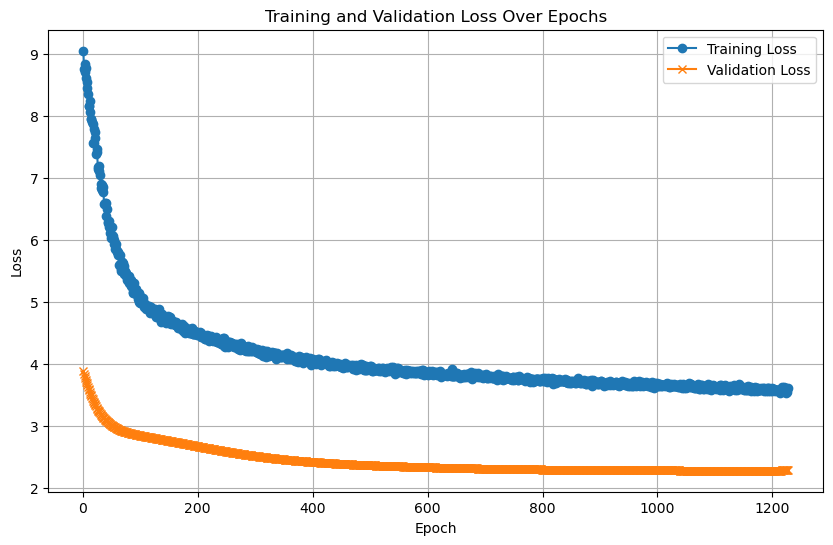

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.0764
Test Batch [20/167], Loss: 4.3693
Test Batch [30/167], Loss: 4.4109
Test Batch [40/167], Loss: 4.4847
Test Batch [50/167], Loss: 4.2967
Test Batch [60/167], Loss: 4.1242


Test Batch [70/167], Loss: 4.0870
Test Batch [80/167], Loss: 4.7347
Test Batch [90/167], Loss: 4.7918
Test Batch [100/167], Loss: 4.6503
Test Batch [110/167], Loss: 5.0121
Test Batch [120/167], Loss: 5.0249
Test Batch [130/167], Loss: 5.0442
Test Batch [140/167], Loss: 5.1538
Test Batch [150/167], Loss: 4.7448
Test Batch [160/167], Loss: 4.6246

Test Loss: 4.5997


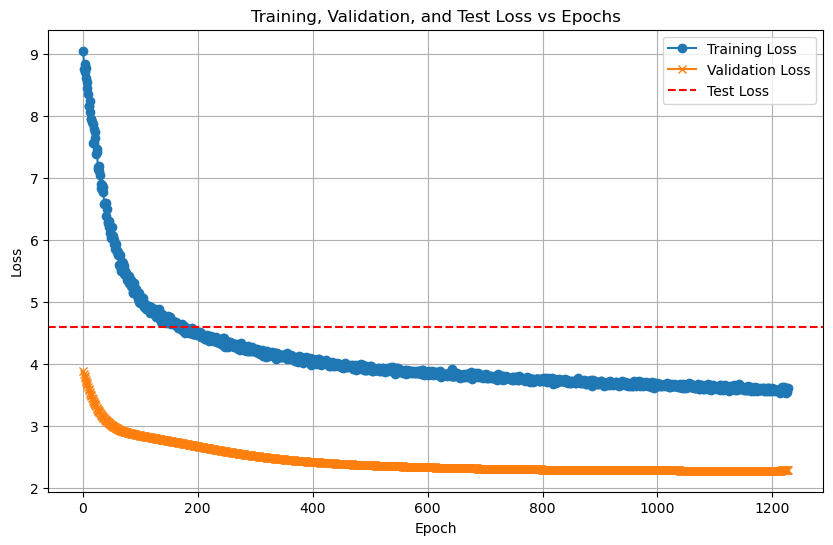

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.83      1.00      0.91         5
           2       0.67      0.80      0.73         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.62      1.00      0.77         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.75      0.82      0.78        45
weighted avg       0.75      0.82      0.78        45


LOG: Evaluating on the test set...
Test Accuracy: 72.08%

Test Classifica

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1558  |  Val Loss: 2.1334
Validation loss improved from inf to 2.1334.
[Epoch 2/1000] Train Loss: 2.1188  |  Val Loss: 2.0999
Validation loss improved from 2.1334 to 2.0999.
[Epoch 3/1000] Train Loss: 2.0851  |  Val Loss: 2.0684
Validation loss improved from 2.0999 to 2.0684.
[Epoch 4/1000] Train Loss: 2.0533  |  Val Loss: 2.0390
Validation loss improved from 2.0684 to 2.0390.
[Epoch 5/1000] Train Loss: 2.0237  |  Val Loss: 2.0112
Validation loss improved from 2.0390 to 2.0112.
[Epoch 6/1000] Train Loss: 1.9979  |  Val Loss: 1.9848
Validation loss improved from 2.0112 to 1.9848.
[Epoch 7/1000] Train Loss: 1.9703  |  Val Loss: 1.9601
Validation loss improved from 1.9848 to 1.9601.


[Epoch 8/1000] Train Loss: 1.9458  |  Val Loss: 1.9364
Validation loss improved from 1.9601 to 1.9364.
[Epoch 9/1000] Train Loss: 1.9209  |  Val Loss: 1.9145
Validation loss improved from 1.9364 to 1.9145.
[Epoch 10/1000] Train Loss: 1.8961  |  Val Loss: 1.8913
Validation loss improved from 1.9145 to 1.8913.
[Epoch 11/1000] Train Loss: 1.8710  |  Val Loss: 1.8666
Validation loss improved from 1.8913 to 1.8666.
[Epoch 12/1000] Train Loss: 1.8458  |  Val Loss: 1.8423
Validation loss improved from 1.8666 to 1.8423.
[Epoch 13/1000] Train Loss: 1.8224  |  Val Loss: 1.8196
Validation loss improved from 1.8423 to 1.8196.
[Epoch 14/1000] Train Loss: 1.7992  |  Val Loss: 1.7986
Validation loss improved from 1.8196 to 1.7986.
[Epoch 15/1000] Train Loss: 1.7775  |  Val Loss: 1.7783
Validation loss improved from 1.7986 to 1.7783.
[Epoch 16/1000] Train Loss: 1.7547  |  Val Loss: 1.7593
Validation loss improved from 1.7783 to 1.7593.
[Epoch 17/1000] Train Loss: 1.7345  |  Val Loss: 1.7406
Validation

[Epoch 29/1000] Train Loss: 1.5059  |  Val Loss: 1.5342
Validation loss improved from 1.5495 to 1.5342.
[Epoch 30/1000] Train Loss: 1.4893  |  Val Loss: 1.5191
Validation loss improved from 1.5342 to 1.5191.
[Epoch 31/1000] Train Loss: 1.4723  |  Val Loss: 1.5041
Validation loss improved from 1.5191 to 1.5041.
[Epoch 32/1000] Train Loss: 1.4557  |  Val Loss: 1.4889
Validation loss improved from 1.5041 to 1.4889.
[Epoch 33/1000] Train Loss: 1.4388  |  Val Loss: 1.4737
Validation loss improved from 1.4889 to 1.4737.
[Epoch 34/1000] Train Loss: 1.4222  |  Val Loss: 1.4585
Validation loss improved from 1.4737 to 1.4585.
[Epoch 35/1000] Train Loss: 1.4053  |  Val Loss: 1.4435
Validation loss improved from 1.4585 to 1.4435.
[Epoch 36/1000] Train Loss: 1.3888  |  Val Loss: 1.4285
Validation loss improved from 1.4435 to 1.4285.
[Epoch 37/1000] Train Loss: 1.3721  |  Val Loss: 1.4137
Validation loss improved from 1.4285 to 1.4137.
[Epoch 38/1000] Train Loss: 1.3556  |  Val Loss: 1.3989
Validati

[Epoch 42/1000] Train Loss: 1.2893  |  Val Loss: 1.3396
Validation loss improved from 1.3542 to 1.3396.
[Epoch 43/1000] Train Loss: 1.2728  |  Val Loss: 1.3249
Validation loss improved from 1.3396 to 1.3249.
[Epoch 44/1000] Train Loss: 1.2566  |  Val Loss: 1.3106
Validation loss improved from 1.3249 to 1.3106.
[Epoch 45/1000] Train Loss: 1.2401  |  Val Loss: 1.2963
Validation loss improved from 1.3106 to 1.2963.
[Epoch 46/1000] Train Loss: 1.2241  |  Val Loss: 1.2823
Validation loss improved from 1.2963 to 1.2823.
[Epoch 47/1000] Train Loss: 1.2079  |  Val Loss: 1.2684
Validation loss improved from 1.2823 to 1.2684.
[Epoch 48/1000] Train Loss: 1.1919  |  Val Loss: 1.2546
Validation loss improved from 1.2684 to 1.2546.
[Epoch 49/1000] Train Loss: 1.1762  |  Val Loss: 1.2409
Validation loss improved from 1.2546 to 1.2409.
[Epoch 50/1000] Train Loss: 1.1610  |  Val Loss: 1.2273
Validation loss improved from 1.2409 to 1.2273.
[Epoch 51/1000] Train Loss: 1.1454  |  Val Loss: 1.2138
Validati

[Epoch 63/1000] Train Loss: 0.9698  |  Val Loss: 1.0587
Validation loss improved from 1.0708 to 1.0587.
[Epoch 64/1000] Train Loss: 0.9560  |  Val Loss: 1.0467
Validation loss improved from 1.0587 to 1.0467.
[Epoch 65/1000] Train Loss: 0.9425  |  Val Loss: 1.0349
Validation loss improved from 1.0467 to 1.0349.
[Epoch 66/1000] Train Loss: 0.9289  |  Val Loss: 1.0231
Validation loss improved from 1.0349 to 1.0231.
[Epoch 67/1000] Train Loss: 0.9159  |  Val Loss: 1.0116
Validation loss improved from 1.0231 to 1.0116.
[Epoch 68/1000] Train Loss: 0.9027  |  Val Loss: 1.0003
Validation loss improved from 1.0116 to 1.0003.
[Epoch 69/1000] Train Loss: 0.8899  |  Val Loss: 0.9892
Validation loss improved from 1.0003 to 0.9892.
[Epoch 70/1000] Train Loss: 0.8774  |  Val Loss: 0.9783
Validation loss improved from 0.9892 to 0.9783.
[Epoch 71/1000] Train Loss: 0.8651  |  Val Loss: 0.9677
Validation loss improved from 0.9783 to 0.9677.
[Epoch 72/1000] Train Loss: 0.8530  |  Val Loss: 0.9571
Validati

[Epoch 74/1000] Train Loss: 0.8294  |  Val Loss: 0.9370
Validation loss improved from 0.9469 to 0.9370.
[Epoch 75/1000] Train Loss: 0.8181  |  Val Loss: 0.9272
Validation loss improved from 0.9370 to 0.9272.
[Epoch 76/1000] Train Loss: 0.8071  |  Val Loss: 0.9176
Validation loss improved from 0.9272 to 0.9176.
[Epoch 77/1000] Train Loss: 0.7959  |  Val Loss: 0.9082
Validation loss improved from 0.9176 to 0.9082.
[Epoch 78/1000] Train Loss: 0.7852  |  Val Loss: 0.8991
Validation loss improved from 0.9082 to 0.8991.
[Epoch 79/1000] Train Loss: 0.7748  |  Val Loss: 0.8902
Validation loss improved from 0.8991 to 0.8902.
[Epoch 80/1000] Train Loss: 0.7644  |  Val Loss: 0.8815
Validation loss improved from 0.8902 to 0.8815.
[Epoch 81/1000] Train Loss: 0.7543  |  Val Loss: 0.8730
Validation loss improved from 0.8815 to 0.8730.
[Epoch 82/1000] Train Loss: 0.7445  |  Val Loss: 0.8645
Validation loss improved from 0.8730 to 0.8645.
[Epoch 83/1000] Train Loss: 0.7346  |  Val Loss: 0.8562
Validati

[Epoch 94/1000] Train Loss: 0.6348  |  Val Loss: 0.7752
Validation loss improved from 0.7816 to 0.7752.
[Epoch 95/1000] Train Loss: 0.6270  |  Val Loss: 0.7688
Validation loss improved from 0.7752 to 0.7688.
[Epoch 96/1000] Train Loss: 0.6192  |  Val Loss: 0.7628
Validation loss improved from 0.7688 to 0.7628.
[Epoch 97/1000] Train Loss: 0.6116  |  Val Loss: 0.7569
Validation loss improved from 0.7628 to 0.7569.
[Epoch 98/1000] Train Loss: 0.6042  |  Val Loss: 0.7513
Validation loss improved from 0.7569 to 0.7513.
[Epoch 99/1000] Train Loss: 0.5970  |  Val Loss: 0.7457
Validation loss improved from 0.7513 to 0.7457.
[Epoch 100/1000] Train Loss: 0.5898  |  Val Loss: 0.7402
Validation loss improved from 0.7457 to 0.7402.
[Epoch 101/1000] Train Loss: 0.5829  |  Val Loss: 0.7347
Validation loss improved from 0.7402 to 0.7347.
[Epoch 102/1000] Train Loss: 0.5762  |  Val Loss: 0.7296
Validation loss improved from 0.7347 to 0.7296.
[Epoch 103/1000] Train Loss: 0.5689  |  Val Loss: 0.7244
Vali

[Epoch 106/1000] Train Loss: 0.5492  |  Val Loss: 0.7091
Validation loss improved from 0.7140 to 0.7091.
[Epoch 107/1000] Train Loss: 0.5431  |  Val Loss: 0.7044
Validation loss improved from 0.7091 to 0.7044.
[Epoch 108/1000] Train Loss: 0.5371  |  Val Loss: 0.6999
Validation loss improved from 0.7044 to 0.6999.
[Epoch 109/1000] Train Loss: 0.5314  |  Val Loss: 0.6961
Validation loss improved from 0.6999 to 0.6961.
[Epoch 110/1000] Train Loss: 0.5254  |  Val Loss: 0.6918
Validation loss improved from 0.6961 to 0.6918.
[Epoch 111/1000] Train Loss: 0.5200  |  Val Loss: 0.6878
Validation loss improved from 0.6918 to 0.6878.
[Epoch 112/1000] Train Loss: 0.5144  |  Val Loss: 0.6837
Validation loss improved from 0.6878 to 0.6837.
[Epoch 113/1000] Train Loss: 0.5092  |  Val Loss: 0.6798
Validation loss improved from 0.6837 to 0.6798.
[Epoch 114/1000] Train Loss: 0.5040  |  Val Loss: 0.6755
Validation loss improved from 0.6798 to 0.6755.
[Epoch 115/1000] Train Loss: 0.4988  |  Val Loss: 0.671

[Epoch 130/1000] Train Loss: 0.4348  |  Val Loss: 0.6240
Validation loss improved from 0.6266 to 0.6240.
[Epoch 131/1000] Train Loss: 0.4315  |  Val Loss: 0.6213
Validation loss improved from 0.6240 to 0.6213.
[Epoch 132/1000] Train Loss: 0.4278  |  Val Loss: 0.6194
Validation loss improved from 0.6213 to 0.6194.
[Epoch 133/1000] Train Loss: 0.4246  |  Val Loss: 0.6175
Validation loss improved from 0.6194 to 0.6175.
[Epoch 134/1000] Train Loss: 0.4214  |  Val Loss: 0.6156
Validation loss improved from 0.6175 to 0.6156.
[Epoch 135/1000] Train Loss: 0.4180  |  Val Loss: 0.6134
Validation loss improved from 0.6156 to 0.6134.
[Epoch 136/1000] Train Loss: 0.4148  |  Val Loss: 0.6114
Validation loss improved from 0.6134 to 0.6114.
[Epoch 137/1000] Train Loss: 0.4116  |  Val Loss: 0.6094
Validation loss improved from 0.6114 to 0.6094.
[Epoch 138/1000] Train Loss: 0.4086  |  Val Loss: 0.6074
Validation loss improved from 0.6094 to 0.6074.
[Epoch 139/1000] Train Loss: 0.4056  |  Val Loss: 0.605

[Epoch 140/1000] Train Loss: 0.4027  |  Val Loss: 0.6038
Validation loss improved from 0.6058 to 0.6038.
[Epoch 141/1000] Train Loss: 0.3997  |  Val Loss: 0.6020
Validation loss improved from 0.6038 to 0.6020.
[Epoch 142/1000] Train Loss: 0.3970  |  Val Loss: 0.6003
Validation loss improved from 0.6020 to 0.6003.
[Epoch 143/1000] Train Loss: 0.3944  |  Val Loss: 0.5985
Validation loss improved from 0.6003 to 0.5985.
[Epoch 144/1000] Train Loss: 0.3917  |  Val Loss: 0.5972
Validation loss improved from 0.5985 to 0.5972.
[Epoch 145/1000] Train Loss: 0.3889  |  Val Loss: 0.5952
Validation loss improved from 0.5972 to 0.5952.
[Epoch 146/1000] Train Loss: 0.3861  |  Val Loss: 0.5938
Validation loss improved from 0.5952 to 0.5938.
[Epoch 147/1000] Train Loss: 0.3837  |  Val Loss: 0.5920
Validation loss improved from 0.5938 to 0.5920.
[Epoch 148/1000] Train Loss: 0.3812  |  Val Loss: 0.5907
Validation loss improved from 0.5920 to 0.5907.
[Epoch 149/1000] Train Loss: 0.3785  |  Val Loss: 0.589

[Epoch 162/1000] Train Loss: 0.3509  |  Val Loss: 0.5749
Validation loss improved from 0.5754 to 0.5749.
[Epoch 163/1000] Train Loss: 0.3490  |  Val Loss: 0.5739
Validation loss improved from 0.5749 to 0.5739.
[Epoch 164/1000] Train Loss: 0.3471  |  Val Loss: 0.5726
Validation loss improved from 0.5739 to 0.5726.
[Epoch 165/1000] Train Loss: 0.3452  |  Val Loss: 0.5706
Validation loss improved from 0.5726 to 0.5706.
[Epoch 166/1000] Train Loss: 0.3435  |  Val Loss: 0.5688
Validation loss improved from 0.5706 to 0.5688.
[Epoch 167/1000] Train Loss: 0.3417  |  Val Loss: 0.5678
Validation loss improved from 0.5688 to 0.5678.
[Epoch 168/1000] Train Loss: 0.3400  |  Val Loss: 0.5668
Validation loss improved from 0.5678 to 0.5668.
[Epoch 169/1000] Train Loss: 0.3384  |  Val Loss: 0.5655
Validation loss improved from 0.5668 to 0.5655.


[Epoch 170/1000] Train Loss: 0.3367  |  Val Loss: 0.5649
Validation loss improved from 0.5655 to 0.5649.
[Epoch 171/1000] Train Loss: 0.3350  |  Val Loss: 0.5637
Validation loss improved from 0.5649 to 0.5637.
[Epoch 172/1000] Train Loss: 0.3335  |  Val Loss: 0.5628
Validation loss improved from 0.5637 to 0.5628.
[Epoch 173/1000] Train Loss: 0.3320  |  Val Loss: 0.5620
Validation loss improved from 0.5628 to 0.5620.
[Epoch 174/1000] Train Loss: 0.3304  |  Val Loss: 0.5616
Validation loss improved from 0.5620 to 0.5616.
[Epoch 175/1000] Train Loss: 0.3287  |  Val Loss: 0.5610
Validation loss improved from 0.5616 to 0.5610.
[Epoch 176/1000] Train Loss: 0.3272  |  Val Loss: 0.5604
Validation loss improved from 0.5610 to 0.5604.
[Epoch 177/1000] Train Loss: 0.3258  |  Val Loss: 0.5599
Validation loss improved from 0.5604 to 0.5599.
[Epoch 178/1000] Train Loss: 0.3243  |  Val Loss: 0.5592
Validation loss improved from 0.5599 to 0.5592.
[Epoch 179/1000] Train Loss: 0.3229  |  Val Loss: 0.558

[Epoch 191/1000] Train Loss: 0.3073  |  Val Loss: 0.5506
Validation loss improved from 0.5514 to 0.5506.
[Epoch 192/1000] Train Loss: 0.3065  |  Val Loss: 0.5489
Validation loss improved from 0.5506 to 0.5489.
[Epoch 193/1000] Train Loss: 0.3051  |  Val Loss: 0.5480
Validation loss improved from 0.5489 to 0.5480.
[Epoch 194/1000] Train Loss: 0.3038  |  Val Loss: 0.5479
Validation loss improved from 0.5480 to 0.5479.
[Epoch 195/1000] Train Loss: 0.3027  |  Val Loss: 0.5485
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 196/1000] Train Loss: 0.3016  |  Val Loss: 0.5486
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 197/1000] Train Loss: 0.3006  |  Val Loss: 0.5487
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 198/1000] Train Loss: 0.2994  |  Val Loss: 0.5486
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 199/1000] Train Loss: 0.2982  |  Val Loss: 0.5480
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 200/1000] Train Lo

[Epoch 202/1000] Train Loss: 0.2953  |  Val Loss: 0.5440
Validation loss improved from 0.5444 to 0.5440.
[Epoch 203/1000] Train Loss: 0.2943  |  Val Loss: 0.5430
Validation loss improved from 0.5440 to 0.5430.
[Epoch 204/1000] Train Loss: 0.2931  |  Val Loss: 0.5424
Validation loss improved from 0.5430 to 0.5424.
[Epoch 205/1000] Train Loss: 0.2920  |  Val Loss: 0.5416
Validation loss improved from 0.5424 to 0.5416.
[Epoch 206/1000] Train Loss: 0.2910  |  Val Loss: 0.5415
Validation loss improved from 0.5416 to 0.5415.
[Epoch 207/1000] Train Loss: 0.2902  |  Val Loss: 0.5411
Validation loss improved from 0.5415 to 0.5411.
[Epoch 208/1000] Train Loss: 0.2891  |  Val Loss: 0.5412
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 0.2882  |  Val Loss: 0.5425
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 0.2873  |  Val Loss: 0.5422
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 0.2865  

[Epoch 222/1000] Train Loss: 0.2769  |  Val Loss: 0.5352
Validation loss improved from 0.5365 to 0.5352.
[Epoch 223/1000] Train Loss: 0.2761  |  Val Loss: 0.5344
Validation loss improved from 0.5352 to 0.5344.
[Epoch 224/1000] Train Loss: 0.2755  |  Val Loss: 0.5341
Validation loss improved from 0.5344 to 0.5341.
[Epoch 225/1000] Train Loss: 0.2745  |  Val Loss: 0.5343
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 226/1000] Train Loss: 0.2737  |  Val Loss: 0.5352
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 0.2727  |  Val Loss: 0.5363
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 228/1000] Train Loss: 0.2722  |  Val Loss: 0.5372
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 0.2716  |  Val Loss: 0.5380
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 230/1000] Train Loss: 0.2710  |  Val Loss: 0.5379
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 231/1000] Train Loss: 0.2700  |  Val Loss: 0.5368
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 232/1000] Train Loss: 0.2691  |  Val Loss: 0.5347
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 233/1000] Train Loss: 0.2683  |  Val Loss: 0.5327
Validation loss improved from 0.5341 to 0.5327.
[Epoch 234/1000] Train Loss: 0.2677  |  Val Loss: 0.5319
Validation loss improved from 0.5327 to 0.5319.
[Epoch 235/1000] Train Loss: 0.2670  |  Val Loss: 0.5308
Validation loss improved from 0.5319 to 0.5308.
[Epoch 236/1000] Train Loss: 0.2667  |  Val Loss: 0.5303
Validation loss improved from 0.5308 to 0.5303.
[Epoch 237/1000] Train Loss: 0.2658  |  Val Loss: 0.5303
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.2649  |  Val Loss: 0.5311
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 239/1000] Train Lo

[Epoch 254/1000] Train Loss: 0.2543  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 255/1000] Train Loss: 0.2538  |  Val Loss: 0.5270
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 256/1000] Train Loss: 0.2535  |  Val Loss: 0.5284
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 257/1000] Train Loss: 0.2528  |  Val Loss: 0.5270
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 258/1000] Train Loss: 0.2521  |  Val Loss: 0.5280
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 259/1000] Train Loss: 0.2514  |  Val Loss: 0.5271
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 260/1000] Train Loss: 0.2512  |  Val Loss: 0.5278
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 261/1000] Train Loss: 0.2501  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 262/1000] Train Loss: 0.2495  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 263/1000] Train Loss: 0.2489  |  Val Loss: 0.5271
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 264/1000] Train Loss: 0.2484  |  Val Loss: 0.5260
Validation loss improved from 0.5264 to 0.5260.
[Epoch 265/1000] Train Loss: 0.2480  |  Val Loss: 0.5251
Validation loss improved from 0.5260 to 0.5251.
[Epoch 266/1000] Train Loss: 0.2472  |  Val Loss: 0.5243
Validation loss improved from 0.5251 to 0.5243.
[Epoch 267/1000] Train Loss: 0.2469  |  Val Loss: 0.5237
Validation loss improved from 0.5243 to 0.5237.
[Epoch 268/1000] Train Loss: 0.2461  |  Val Loss: 0.5251
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 269/1000] Train Loss: 0.2455  |  Val Loss: 0.5254
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 270/1000] Train Loss: 0.2452  |  Val Loss: 0.5260
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 271/1000] Train Loss: 0.2444  |  Val Loss: 0.5260
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 272/1000] Train L

[Epoch 288/1000] Train Loss: 0.2355  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 289/1000] Train Loss: 0.2348  |  Val Loss: 0.5232
Validation loss improved from 0.5237 to 0.5232.
[Epoch 290/1000] Train Loss: 0.2343  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 291/1000] Train Loss: 0.2340  |  Val Loss: 0.5229
Validation loss improved from 0.5232 to 0.5229.
[Epoch 292/1000] Train Loss: 0.2341  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 293/1000] Train Loss: 0.2329  |  Val Loss: 0.5231
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 294/1000] Train Loss: 0.2324  |  Val Loss: 0.5229
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 295/1000] Train Loss: 0.2320  |  Val Loss: 0.5222
Validation loss improved from 0.5229 to 0.5222.
[Epoch 296/1000] Train Loss: 0.2315  |  Val Loss: 0.5225
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 297/1000] Train Loss: 0.2308  |  Val Loss: 0.5226
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 298/1000] Train Loss: 0.2303  |  Val Loss: 0.5221
Validation loss improved from 0.5222 to 0.5221.
[Epoch 299/1000] Train Loss: 0.2300  |  Val Loss: 0.5210
Validation loss improved from 0.5221 to 0.5210.
[Epoch 300/1000] Train Loss: 0.2295  |  Val Loss: 0.5218
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 301/1000] Train Loss: 0.2289  |  Val Loss: 0.5227
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 302/1000] Train Loss: 0.2288  |  Val Loss: 0.5221
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 303/1000] Train Loss: 0.2280  |  Val Loss: 0.5228
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 304/1000] Tr

[Epoch 320/1000] Train Loss: 0.2194  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 321/1000] Train Loss: 0.2187  |  Val Loss: 0.5229
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 322/1000] Train Loss: 0.2184  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 323/1000] Train Loss: 0.2177  |  Val Loss: 0.5247
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 324/1000] Train Loss: 0.2179  |  Val Loss: 0.5230
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 325/1000] Train Loss: 0.2166  |  Val Loss: 0.5235
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 326/1000] Train Loss: 0.2164  |  Val Loss: 0.5236
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 327/1000] Train Loss: 0.2154  |  Val Loss: 0.5220
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 328/1000] Train Loss: 0.2148  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 329/1000] Train Loss: 0.2143  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 330/1000] Train Loss: 0.2137  |  Val Loss: 0.5208
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 331/1000] Train Loss: 0.2134  |  Val Loss: 0.5207
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 332/1000] Train Loss: 0.2129  |  Val Loss: 0.5218
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 333/1000] Train Loss: 0.2124  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 334/1000] Train Loss: 0.2119  |  Val Loss: 0.5222
!! Validation loss did NOT improve !! Patience:

[Epoch 354/1000] Train Loss: 0.2030  |  Val Loss: 0.5230
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 355/1000] Train Loss: 0.2025  |  Val Loss: 0.5222
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 356/1000] Train Loss: 0.2019  |  Val Loss: 0.5222
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 357/1000] Train Loss: 0.2017  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 358/1000] Train Loss: 0.2010  |  Val Loss: 0.5192
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 359/1000] Train Loss: 0.2007  |  Val Loss: 0.5188
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 360/1000] Train Loss: 0.2005  |  Val Loss: 0.5192
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 361/1000] Train Loss: 0.2002  |  Val Loss: 0.5208
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 362/1000] Train Loss: 0.1999  |  Val Loss: 0.5199
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 363/1000] Train Loss: 0.1990  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 387/1000] Train Loss: 0.1889  |  Val Loss: 0.5279
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 388/1000] Train Loss: 0.1890  |  Val Loss: 0.5281
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 389/1000] Train Loss: 0.1880  |  Val Loss: 0.5268
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 390/1000] Train Loss: 0.1874  |  Val Loss: 0.5275
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 391/1000] Train Loss: 0.1874  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 392/1000] Train Loss: 0.1867  |  Val Loss: 0.5277
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 393/1000] Train Loss: 0.1865  |  Val Loss: 0.5285
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 394/1000] Train Loss: 0.1861  |  Val Loss: 0.5275
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 395/1000] Train Loss: 0.1857  |  Val Loss: 0.5271
!! Validation loss did NOT improve !! Patience:

[Epoch 421/1000] Train Loss: 0.1750  |  Val Loss: 0.5301
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 422/1000] Train Loss: 0.1744  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 423/1000] Train Loss: 0.1741  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 424/1000] Train Loss: 0.1744  |  Val Loss: 0.5276
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 425/1000] Train Loss: 0.1734  |  Val Loss: 0.5287
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 426/1000] Train Loss: 0.1731  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 427/1000] Train Loss: 0.1728  |  Val Loss: 0.5327
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 428/1000] Train Loss: 0.1724  |  Val Loss: 0.5332
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 429/1000] Train Loss: 0.1719  |  Val Loss: 0.5347
!! Validation loss did NOT improve !! Patience:

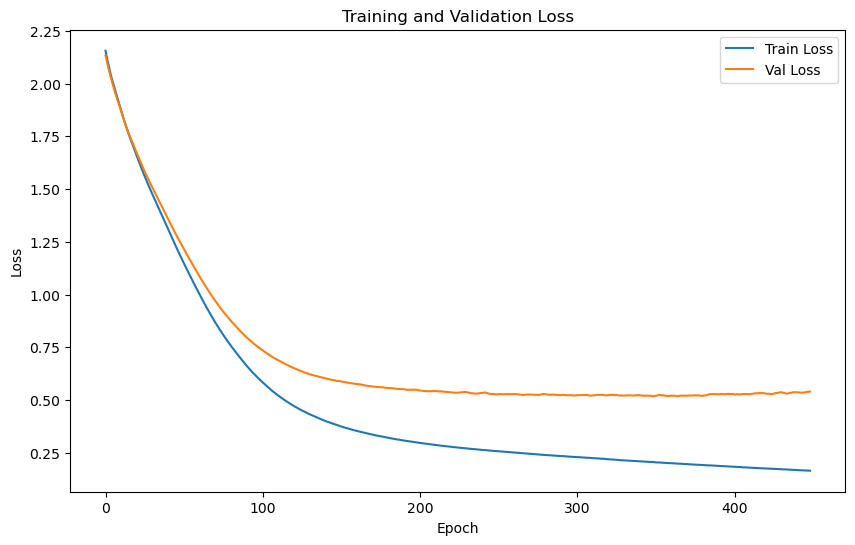

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.1558 | Test Accuracy: 70.70%


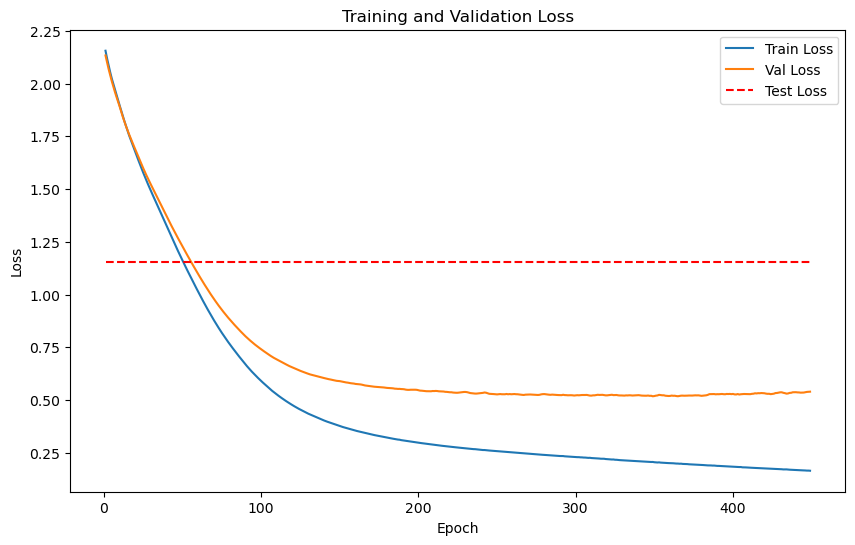

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4423
Epoch [1/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4423

Validation loss improved from inf to 0.4423. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4399
Epoch [2/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4399

Validation loss improved from 0.4423 to 0.4399. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4376
Epoch [3/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4376

Validation loss improved from 0.4399 to 0.4376. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4349
Epoch [4/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4349

Validation loss improved from 0.4376 to 0.4349. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4319
Epoch [5/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4319

Validation loss improved from 0.4349 to 0.4319. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4282
Epoch [6/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4282

Validation loss improved from 0.4319 to 0.4282. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4248
Epoch [7/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4248

Validation loss improved from 0.4282 to 0.4248. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4228
Epoch [8/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4228

Validation loss improved from 0.4248 to 0.4228. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4210
Epoch [9/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4210

Validation loss improved from 0.4228 to 0.4210. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4197
Epoch [10/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4197

Validation loss improved from 0.4210 to 0.4197. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4190
Epoch [11/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4190

Validation loss improved from 0.4197 to 0.4190. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4182
Epoch [12/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4182

Validation loss improved from 0.4190 to 0.4182. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4173
Epoch [13/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4173

Validation loss improved from 0.4182 to 0.4173. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.4167
Epoch [14/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4167

Validation loss improved from 0.4173 to 0.4167. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4159
Epoch [15/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4159

Validation loss improved from 0.4167 to 0.4159. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.4150
Epoch [16/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4150

Validation loss improved from 0.4159 to 0.4150. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4139
Epoch [17/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4139

Validation loss improved from 0.4150 to 0.4139. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4128
Epoch [18/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4128

Validation loss improved from 0.4139 to 0.4128. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.4117
Epoch [19/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4117

Validation loss improved from 0.4128 to 0.4117. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.4106
Epoch [20/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4106

Validation loss improved from 0.4117 to 0.4106. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [21/2000] - Validation


    Batch [1/1], Val Loss: 0.4094
Epoch [21/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4094

Validation loss improved from 0.4106 to 0.4094. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.4083
Epoch [22/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4083

Validation loss improved from 0.4094 to 0.4083. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4073
Epoch [23/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4073

Validation loss improved from 0.4083 to 0.4073. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [24/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4064

Validation loss improved from 0.4073 to 0.4064. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4054
Epoch [25/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4054

Validation loss improved from 0.4064 to 0.4054. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4045
Epoch [26/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4045

Validation loss improved from 0.4054 to 0.4045. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.4036
Epoch [27/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4036

Validation loss improved from 0.4045 to 0.4036. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.4027
Epoch [28/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4027

Validation loss improved from 0.4036 to 0.4027. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4018
Epoch [29/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4018

Validation loss improved from 0.4027 to 0.4018. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.4009
Epoch [30/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4009

Validation loss improved from 0.4018 to 0.4009. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4000
Epoch [31/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4000

Validation loss improved from 0.4009 to 0.4000. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3992
Epoch [32/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3992

Validation loss improved from 0.4000 to 0.3992. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3983
Epoch [33/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3983

Validation loss improved from 0.3992 to 0.3983. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [34/2000] - Validation


    Batch [1/1], Val Loss: 0.3974
Epoch [34/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3974

Validation loss improved from 0.3983 to 0.3974. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3965
Epoch [35/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3965

Validation loss improved from 0.3974 to 0.3965. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [36/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3957

Validation loss improved from 0.3965 to 0.3957. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [37/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3948

Validation loss improved from 0.3957 to 0.3948. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [38/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.3940

Validation loss improved from 0.3948 to 0.3940. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [39/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3931

Validation loss improved from 0.3940 to 0.3931. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3923
Epoch [40/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.3923

Validation loss improved from 0.3931 to 0.3923. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [41/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3915

Validation loss improved from 0.3923 to 0.3915. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.3908
Epoch [42/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3908

Validation loss improved from 0.3915 to 0.3908. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3900
Epoch [43/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3900

Validation loss improved from 0.3908 to 0.3900. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.3893
Epoch [44/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3893

Validation loss improved from 0.3900 to 0.3893. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3886
Epoch [45/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3886

Validation loss improved from 0.3893 to 0.3886. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [46/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3878

Validation loss improved from 0.3886 to 0.3878. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3871
Epoch [47/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3871

Validation loss improved from 0.3878 to 0.3871. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3864
Epoch [48/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3864

Validation loss improved from 0.3871 to 0.3864. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [49/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3857

Validation loss improved from 0.3864 to 0.3857. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [50/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3850

Validation loss improved from 0.3857 to 0.3850. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [51/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3843

Validation loss improved from 0.3850 to 0.3843. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [52/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3836

Validation loss improved from 0.3843 to 0.3836. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3829
Epoch [53/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3829

Validation loss improved from 0.3836 to 0.3829. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [54/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3823

Validation loss improved from 0.3829 to 0.3823. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [55/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3816

Validation loss improved from 0.3823 to 0.3816. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [56/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3809

Validation loss improved from 0.3816 to 0.3809. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3802
Epoch [57/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3802

Validation loss improved from 0.3809 to 0.3802. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [58/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3796

Validation loss improved from 0.3802 to 0.3796. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [59/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.3789

Validation loss improved from 0.3796 to 0.3789. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [60/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3783

Validation loss improved from 0.3789 to 0.3783. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [61/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3778

Validation loss improved from 0.3783 to 0.3778. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [62/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3772

Validation loss improved from 0.3778 to 0.3772. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3766
Epoch [63/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3766

Validation loss improved from 0.3772 to 0.3766. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [64/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.3761

Validation loss improved from 0.3766 to 0.3761. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [65/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3756

Validation loss improved from 0.3761 to 0.3756. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [66/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3751

Validation loss improved from 0.3756 to 0.3751. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [67/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3745

Validation loss improved from 0.3751 to 0.3745. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3740
Epoch [68/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3740

Validation loss improved from 0.3745 to 0.3740. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [69/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3735

Validation loss improved from 0.3740 to 0.3735. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3730
Epoch [70/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3730

Validation loss improved from 0.3735 to 0.3730. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3725
Epoch [71/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.3725

Validation loss improved from 0.3730 to 0.3725. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3720
Epoch [72/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3720

Validation loss improved from 0.3725 to 0.3720. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [73/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3716

Validation loss improved from 0.3720 to 0.3716. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [74/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3712

Validation loss improved from 0.3716 to 0.3712. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [75/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3707

Validation loss improved from 0.3712 to 0.3707. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [76/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3702

Validation loss improved from 0.3707 to 0.3702. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [77/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3698

Validation loss improved from 0.3702 to 0.3698. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.3694
Epoch [78/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3694

Validation loss improved from 0.3698 to 0.3694. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [79/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3689

Validation loss improved from 0.3694 to 0.3689. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [80/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3685

Validation loss improved from 0.3689 to 0.3685. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [81/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3681

Validation loss improved from 0.3685 to 0.3681. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [82/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3677

Validation loss improved from 0.3681 to 0.3677. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.3672
Epoch [83/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3672

Validation loss improved from 0.3677 to 0.3672. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [84/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3668

Validation loss improved from 0.3672 to 0.3668. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.3664
Epoch [85/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3664

Validation loss improved from 0.3668 to 0.3664. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [86/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3660

Validation loss improved from 0.3664 to 0.3660. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [87/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3656

Validation loss improved from 0.3660 to 0.3656. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [88/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3652

Validation loss improved from 0.3656 to 0.3652. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [89/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3648

Validation loss improved from 0.3652 to 0.3648. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [90/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3644

Validation loss improved from 0.3648 to 0.3644. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [91/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3640

Validation loss improved from 0.3644 to 0.3640. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [92/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3636

Validation loss improved from 0.3640 to 0.3636. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [93/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3632

Validation loss improved from 0.3636 to 0.3632. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [94/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3628

Validation loss improved from 0.3632 to 0.3628. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [95/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3624

Validation loss improved from 0.3628 to 0.3624. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [96/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3620

Validation loss improved from 0.3624 to 0.3620. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [97/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3616

Validation loss improved from 0.3620 to 0.3616. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [98/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.3612

Validation loss improved from 0.3616 to 0.3612. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3608
Epoch [99/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3608

Validation loss improved from 0.3612 to 0.3608. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [100/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3605

Validation loss improved from 0.3608 to 0.3605. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [101/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3601

Validation loss improved from 0.3605 to 0.3601. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [102/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3598

Validation loss improved from 0.3601 to 0.3598. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [103/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3594

Validation loss improved from 0.3598 to 0.3594. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [104/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.3591

Validation loss improved from 0.3594 to 0.3591. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [105/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3588

Validation loss improved from 0.3591 to 0.3588. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3584
Epoch [106/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3584

Validation loss improved from 0.3588 to 0.3584. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [107/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.3580

Validation loss improved from 0.3584 to 0.3580. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3577
Epoch [108/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3577

Validation loss improved from 0.3580 to 0.3577. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [109/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3573

Validation loss improved from 0.3577 to 0.3573. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [110/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3570

Validation loss improved from 0.3573 to 0.3570. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [111/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3566

Validation loss improved from 0.3570 to 0.3566. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [112/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3563

Validation loss improved from 0.3566 to 0.3563. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [113/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3560

Validation loss improved from 0.3563 to 0.3560. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [114/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3556

Validation loss improved from 0.3560 to 0.3556. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [115/2000] - Validation


    Batch [1/1], Val Loss: 0.3553
Epoch [115/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3553

Validation loss improved from 0.3556 to 0.3553. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [116/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3549

Validation loss improved from 0.3553 to 0.3549. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [117/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3546

Validation loss improved from 0.3549 to 0.3546. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [118/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.3543

Validation loss improved from 0.3546 to 0.3543. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [119/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3540

Validation loss improved from 0.3543 to 0.3540. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.3537
Epoch [120/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3537

Validation loss improved from 0.3540 to 0.3537. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [121/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3534

Validation loss improved from 0.3537 to 0.3534. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [122/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.3531

Validation loss improved from 0.3534 to 0.3531. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3528
Epoch [123/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3528

Validation loss improved from 0.3531 to 0.3528. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3525
Epoch [124/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.3525

Validation loss improved from 0.3528 to 0.3525. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [125/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3523

Validation loss improved from 0.3525 to 0.3523. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [126/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3520

Validation loss improved from 0.3523 to 0.3520. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [127/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3517

Validation loss improved from 0.3520 to 0.3517. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [128/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3513

Validation loss improved from 0.3517 to 0.3513. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [129/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3511

Validation loss improved from 0.3513 to 0.3511. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.3508
Epoch [130/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3508

Validation loss improved from 0.3511 to 0.3508. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [131/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3505

Validation loss improved from 0.3508 to 0.3505. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [132/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3502

Validation loss improved from 0.3505 to 0.3502. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [133/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3499

Validation loss improved from 0.3502 to 0.3499. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [134/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3496

Validation loss improved from 0.3499 to 0.3496. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [135/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3493

Validation loss improved from 0.3496 to 0.3493. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [136/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3489

Validation loss improved from 0.3493 to 0.3489. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [137/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3486

Validation loss improved from 0.3489 to 0.3486. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [138/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3482

Validation loss improved from 0.3486 to 0.3482. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [139/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3479

Validation loss improved from 0.3482 to 0.3479. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [140/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3476

Validation loss improved from 0.3479 to 0.3476. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [141/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [142/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3470

Validation loss improved from 0.3473 to 0.3470. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3467
Epoch [143/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3467

Validation loss improved from 0.3470 to 0.3467. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.3464
Epoch [144/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3464

Validation loss improved from 0.3467 to 0.3464. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [145/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3461

Validation loss improved from 0.3464 to 0.3461. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [146/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3458

Validation loss improved from 0.3461 to 0.3458. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [147/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3455

Validation loss improved from 0.3458 to 0.3455. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [148/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3452

Validation loss improved from 0.3455 to 0.3452. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [149/2000] - Validation


    Batch [1/1], Val Loss: 0.3450
Epoch [149/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3450

Validation loss improved from 0.3452 to 0.3450. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [150/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3447

Validation loss improved from 0.3450 to 0.3447. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [151/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3444

Validation loss improved from 0.3447 to 0.3444. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [152/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3441

Validation loss improved from 0.3444 to 0.3441. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [153/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3439

Validation loss improved from 0.3441 to 0.3439. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [154/2000] - Validation


    Batch [1/1], Val Loss: 0.3436
Epoch [154/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3436

Validation loss improved from 0.3439 to 0.3436. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [155/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3434

Validation loss improved from 0.3436 to 0.3434. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [156/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3431

Validation loss improved from 0.3434 to 0.3431. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [157/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3429

Validation loss improved from 0.3431 to 0.3429. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3426
Epoch [158/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3426

Validation loss improved from 0.3429 to 0.3426. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [159/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3424

Validation loss improved from 0.3426 to 0.3424. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [160/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3421

Validation loss improved from 0.3424 to 0.3421. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [161/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.3419

Validation loss improved from 0.3421 to 0.3419. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.3416
Epoch [162/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3416

Validation loss improved from 0.3419 to 0.3416. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3414
Epoch [163/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3414

Validation loss improved from 0.3416 to 0.3414. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [164/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3411

Validation loss improved from 0.3414 to 0.3411. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [165/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3408

Validation loss improved from 0.3411 to 0.3408. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [166/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3405

Validation loss improved from 0.3408 to 0.3405. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3403
Epoch [167/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3403

Validation loss improved from 0.3405 to 0.3403. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [168/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3400

Validation loss improved from 0.3403 to 0.3400. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [169/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3398

Validation loss improved from 0.3400 to 0.3398. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3396
Epoch [170/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3396

Validation loss improved from 0.3398 to 0.3396. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [171/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3394

Validation loss improved from 0.3396 to 0.3394. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3391
Epoch [172/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3391

Validation loss improved from 0.3394 to 0.3391. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [173/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3389

Validation loss improved from 0.3391 to 0.3389. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [174/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3387

Validation loss improved from 0.3389 to 0.3387. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [175/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.3385

Validation loss improved from 0.3387 to 0.3385. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [176/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [177/2000] - Validation


    Batch [1/1], Val Loss: 0.3382
Epoch [177/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3382

Validation loss improved from 0.3383 to 0.3382. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [178/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3381

Validation loss improved from 0.3382 to 0.3381. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [179/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [180/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3379

Validation loss improved from 0.3380 to 0.3379. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [181/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.3377

Validation loss improved from 0.3379 to 0.3377. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [182/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3376

Validation loss improved from 0.3377 to 0.3376. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [183/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3375

Validation loss improved from 0.3376 to 0.3375. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [184/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3374

Validation loss improved from 0.3375 to 0.3374. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [185/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3373

Validation loss improved from 0.3374 to 0.3373. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [186/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3371

Validation loss improved from 0.3373 to 0.3371. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [187/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3370

Validation loss improved from 0.3371 to 0.3370. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [188/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3369

Validation loss improved from 0.3370 to 0.3369. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [189/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.3367

Validation loss improved from 0.3369 to 0.3367. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.3366
Epoch [190/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3366

Validation loss improved from 0.3367 to 0.3366. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [191/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3364

Validation loss improved from 0.3366 to 0.3364. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [192/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3362

Validation loss improved from 0.3364 to 0.3362. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [193/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3361

Validation loss improved from 0.3362 to 0.3361. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [194/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3359

Validation loss improved from 0.3361 to 0.3359. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [195/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3357

Validation loss improved from 0.3359 to 0.3357. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [196/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.3355

Validation loss improved from 0.3357 to 0.3355. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3353
Epoch [197/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3353

Validation loss improved from 0.3355 to 0.3353. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [198/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3352

Validation loss improved from 0.3353 to 0.3352. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [199/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3350

Validation loss improved from 0.3352 to 0.3350. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [200/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3349

Validation loss improved from 0.3350 to 0.3349. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [201/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3347

Validation loss improved from 0.3349 to 0.3347. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [202/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.3346

Validation loss improved from 0.3347 to 0.3346. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [203/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3344

Validation loss improved from 0.3346 to 0.3344. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [204/2000] - Validation


    Batch [1/1], Val Loss: 0.3342
Epoch [204/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.3342

Validation loss improved from 0.3344 to 0.3342. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [205/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3341

Validation loss improved from 0.3342 to 0.3341. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3339
Epoch [206/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3339

Validation loss improved from 0.3341 to 0.3339. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [207/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.3337

Validation loss improved from 0.3339 to 0.3337. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [208/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [209/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.3332
Epoch [210/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.3332

Validation loss improved from 0.3333 to 0.3332. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [211/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3330

Validation loss improved from 0.3332 to 0.3330. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [212/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3328

Validation loss improved from 0.3330 to 0.3328. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [213/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3326

Validation loss improved from 0.3328 to 0.3326. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [214/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.3325

Validation loss improved from 0.3326 to 0.3325. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [215/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [216/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.3322

Validation loss improved from 0.3324 to 0.3322. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [217/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.3321

Validation loss improved from 0.3322 to 0.3321. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [218/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3320

Validation loss improved from 0.3321 to 0.3320. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [219/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3319

Validation loss improved from 0.3320 to 0.3319. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [220/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3318

Validation loss improved from 0.3319 to 0.3318. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [221/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3318

Validation loss improved from 0.3318 to 0.3318. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [222/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3317

Validation loss improved from 0.3318 to 0.3317. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [223/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.3316

Validation loss improved from 0.3317 to 0.3316. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [224/2000] - Validation


    Batch [1/1], Val Loss: 0.3314
Epoch [224/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3314

Validation loss improved from 0.3316 to 0.3314. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [225/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.3313

Validation loss improved from 0.3314 to 0.3313. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.3312
Epoch [226/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.3312

Validation loss improved from 0.3313 to 0.3312. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3311
Epoch [227/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3311

Validation loss improved from 0.3312 to 0.3311. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3311
Epoch [228/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3311

Validation loss improved from 0.3311 to 0.3311. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [229/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3310

Validation loss improved from 0.3311 to 0.3310. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.3310
Epoch [230/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3310

Validation loss improved from 0.3310 to 0.3310. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [231/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.3310

Validation loss improved from 0.3310 to 0.3310. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [232/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.3309

Validation loss improved from 0.3310 to 0.3309. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [233/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3309

Validation loss improved from 0.3309 to 0.3309. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [234/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.3308

Validation loss improved from 0.3309 to 0.3308. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [235/2000] - Validation


    Batch [1/1], Val Loss: 0.3306
Epoch [235/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [236/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3305

Validation loss improved from 0.3306 to 0.3305. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [237/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3303

Validation loss improved from 0.3305 to 0.3303. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [238/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3302

Validation loss improved from 0.3303 to 0.3302. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [239/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3301

Validation loss improved from 0.3302 to 0.3301. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.3299
Epoch [240/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3299

Validation loss improved from 0.3301 to 0.3299. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [241/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.3297

Validation loss improved from 0.3299 to 0.3297. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [242/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3295

Validation loss improved from 0.3297 to 0.3295. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [243/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.3293

Validation loss improved from 0.3295 to 0.3293. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [244/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.3291

Validation loss improved from 0.3293 to 0.3291. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [245/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3290

Validation loss improved from 0.3291 to 0.3290. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [246/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.3289

Validation loss improved from 0.3290 to 0.3289. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [247/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3288

Validation loss improved from 0.3289 to 0.3288. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [248/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3286

Validation loss improved from 0.3288 to 0.3286. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [249/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3285

Validation loss improved from 0.3286 to 0.3285. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [250/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3284

Validation loss improved from 0.3285 to 0.3284. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [251/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.3283

Validation loss improved from 0.3284 to 0.3283. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [252/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.3282

Validation loss improved from 0.3283 to 0.3282. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [253/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3281

Validation loss improved from 0.3282 to 0.3281. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.3280
Epoch [254/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3280

Validation loss improved from 0.3281 to 0.3280. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [255/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.3279

Validation loss improved from 0.3280 to 0.3279. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [256/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3278

Validation loss improved from 0.3279 to 0.3278. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [257/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3277

Validation loss improved from 0.3278 to 0.3277. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3276
Epoch [258/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.3276

Validation loss improved from 0.3277 to 0.3276. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [259/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.3275

Validation loss improved from 0.3276 to 0.3275. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [260/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3275

Validation loss improved from 0.3275 to 0.3275. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [261/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.3274

Validation loss improved from 0.3275 to 0.3274. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [262/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.3273

Validation loss improved from 0.3274 to 0.3273. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [263/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.3273

Validation loss improved from 0.3273 to 0.3273. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [264/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.3272

Validation loss improved from 0.3273 to 0.3272. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3271
Epoch [265/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3271

Validation loss improved from 0.3272 to 0.3271. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [266/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.3270

Validation loss improved from 0.3271 to 0.3270. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [267/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3269

Validation loss improved from 0.3270 to 0.3269. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [268/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3269

Validation loss improved from 0.3269 to 0.3269. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [269/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3268

Validation loss improved from 0.3269 to 0.3268. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [270/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3268

Validation loss improved from 0.3268 to 0.3268. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [271/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.3268

Validation loss improved from 0.3268 to 0.3268. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [272/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3267

Validation loss improved from 0.3268 to 0.3267. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [273/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3267

Validation loss improved from 0.3267 to 0.3267. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [274/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.3266

Validation loss improved from 0.3267 to 0.3266. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [275/2000] - Validation


    Batch [1/1], Val Loss: 0.3265
Epoch [275/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3265

Validation loss improved from 0.3266 to 0.3265. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [276/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3265

Validation loss improved from 0.3265 to 0.3265. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.3264
Epoch [277/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3264

Validation loss improved from 0.3265 to 0.3264. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [278/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.3263

Validation loss improved from 0.3264 to 0.3263. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.3119
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [279/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.3263

Validation loss improved from 0.3263 to 0.3263. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3121
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [280/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.3262

Validation loss improved from 0.3263 to 0.3262. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.3121
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [281/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.3261

Validation loss improved from 0.3262 to 0.3261. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [282/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3260

Validation loss improved from 0.3261 to 0.3260. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [283/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3259

Validation loss improved from 0.3260 to 0.3259. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [284/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3258

Validation loss improved from 0.3259 to 0.3258. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [285/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3256

Validation loss improved from 0.3258 to 0.3256. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [286/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3254

Validation loss improved from 0.3256 to 0.3254. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [287/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.3252

Validation loss improved from 0.3254 to 0.3252. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [288/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3249

Validation loss improved from 0.3252 to 0.3249. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3121
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3247
Epoch [289/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.3247

Validation loss improved from 0.3249 to 0.3247. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [290/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3245

Validation loss improved from 0.3247 to 0.3245. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [291/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3243

Validation loss improved from 0.3245 to 0.3243. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3241
Epoch [292/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.3241

Validation loss improved from 0.3243 to 0.3241. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3239
Epoch [293/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3239

Validation loss improved from 0.3241 to 0.3239. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [294/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.3238

Validation loss improved from 0.3239 to 0.3238. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.3236
Epoch [295/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3236

Validation loss improved from 0.3238 to 0.3236. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3235
Epoch [296/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3235

Validation loss improved from 0.3236 to 0.3235. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.3234
Epoch [297/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3234

Validation loss improved from 0.3235 to 0.3234. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3233
Epoch [298/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3233

Validation loss improved from 0.3234 to 0.3233. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [299/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.3232

Validation loss improved from 0.3233 to 0.3232. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [300/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.3232

Validation loss improved from 0.3232 to 0.3232. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [301/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3232

Validation loss improved from 0.3232 to 0.3232. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.3232
Epoch [302/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3232

Validation loss improved from 0.3232 to 0.3232. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [303/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3232

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [304/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.3232

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [305/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3232

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [306/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.3231

Validation loss improved from 0.3232 to 0.3231. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [307/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3230

Validation loss improved from 0.3231 to 0.3230. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [308/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3228

Validation loss improved from 0.3230 to 0.3228. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [309/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.3227

Validation loss improved from 0.3228 to 0.3227. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.3225
Epoch [310/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3225

Validation loss improved from 0.3227 to 0.3225. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [311/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3223

Validation loss improved from 0.3225 to 0.3223. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [312/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3220
Epoch [313/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.3220

Validation loss improved from 0.3222 to 0.3220. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [314/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3219

Validation loss improved from 0.3220 to 0.3219. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [315/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.3217

Validation loss improved from 0.3219 to 0.3217. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [316/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3216

Validation loss improved from 0.3217 to 0.3216. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.3215
Epoch [317/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3215

Validation loss improved from 0.3216 to 0.3215. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [318/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3214

Validation loss improved from 0.3215 to 0.3214. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.3213
Epoch [319/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3213

Validation loss improved from 0.3214 to 0.3213. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [320/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3212

Validation loss improved from 0.3213 to 0.3212. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3212
Epoch [321/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3212

Validation loss improved from 0.3212 to 0.3212. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [322/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [323/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.3210

Validation loss improved from 0.3211 to 0.3210. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [324/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3209

Validation loss improved from 0.3210 to 0.3209. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3208
Epoch [325/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.3208

Validation loss improved from 0.3209 to 0.3208. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [326/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3206

Validation loss improved from 0.3208 to 0.3206. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [327/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3205

Validation loss improved from 0.3206 to 0.3205. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [328/2000] - Validation


    Batch [1/1], Val Loss: 0.3204
Epoch [328/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3204

Validation loss improved from 0.3205 to 0.3204. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [329/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3202

Validation loss improved from 0.3204 to 0.3202. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3201
Epoch [330/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.3201

Validation loss improved from 0.3202 to 0.3201. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [331/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3200

Validation loss improved from 0.3201 to 0.3200. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [332/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3199

Validation loss improved from 0.3200 to 0.3199. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [333/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.3198

Validation loss improved from 0.3199 to 0.3198. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [334/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3197

Validation loss improved from 0.3198 to 0.3197. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.3197
Epoch [335/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3197

Validation loss improved from 0.3197 to 0.3197. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [336/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3196

Validation loss improved from 0.3197 to 0.3196. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.3196
Epoch [337/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3196

Validation loss improved from 0.3196 to 0.3196. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [338/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3195

Validation loss improved from 0.3196 to 0.3195. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.3194
Epoch [339/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3194

Validation loss improved from 0.3195 to 0.3194. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [340/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3194

Validation loss improved from 0.3194 to 0.3194. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [341/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3193

Validation loss improved from 0.3194 to 0.3193. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [342/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3193

Validation loss improved from 0.3193 to 0.3193. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.3192
Epoch [343/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3192

Validation loss improved from 0.3193 to 0.3192. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3191
Epoch [344/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3191

Validation loss improved from 0.3192 to 0.3191. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [345/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3190

Validation loss improved from 0.3191 to 0.3190. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [346/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3189

Validation loss improved from 0.3190 to 0.3189. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3187
Epoch [347/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3187

Validation loss improved from 0.3189 to 0.3187. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.3186
Epoch [348/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3186

Validation loss improved from 0.3187 to 0.3186. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [349/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3184

Validation loss improved from 0.3186 to 0.3184. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.3183
Epoch [350/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [351/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.3181

Validation loss improved from 0.3183 to 0.3181. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.3181
Epoch [352/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3181

Validation loss improved from 0.3181 to 0.3181. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [353/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3180

Validation loss improved from 0.3181 to 0.3180. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.3180
Epoch [354/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3180

Validation loss improved from 0.3180 to 0.3180. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [355/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3179

Validation loss improved from 0.3180 to 0.3179. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.3180
Epoch [356/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3180

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [357/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3180

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [358/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3180

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [359/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3180

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [360/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3180

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3179
Epoch [361/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3179

Validation loss improved from 0.3179 to 0.3179. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [362/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [363/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3177

Validation loss improved from 0.3178 to 0.3177. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [364/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3176

Validation loss improved from 0.3177 to 0.3176. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [365/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.3174
Epoch [366/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3174

Validation loss improved from 0.3175 to 0.3174. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [367/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.3173

Validation loss improved from 0.3174 to 0.3173. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [368/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3173

Validation loss improved from 0.3173 to 0.3173. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [369/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [370/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3172

Validation loss improved from 0.3172 to 0.3172. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [371/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.3172

Validation loss improved from 0.3172 to 0.3172. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [372/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [373/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3173

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [374/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.3171
Epoch [375/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.3171

Validation loss improved from 0.3172 to 0.3171. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [376/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3170

Validation loss improved from 0.3171 to 0.3170. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [377/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.3168

Validation loss improved from 0.3170 to 0.3168. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [378/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3167

Validation loss improved from 0.3168 to 0.3167. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [379/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3167

Validation loss improved from 0.3167 to 0.3167. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [380/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.3166

Validation loss improved from 0.3167 to 0.3166. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [381/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3165

Validation loss improved from 0.3166 to 0.3165. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.3164
Epoch [382/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.3164

Validation loss improved from 0.3165 to 0.3164. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [383/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3163

Validation loss improved from 0.3164 to 0.3163. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [384/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3162

Validation loss improved from 0.3163 to 0.3162. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [385/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3160

Validation loss improved from 0.3162 to 0.3160. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [386/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3159

Validation loss improved from 0.3160 to 0.3159. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.3157
Epoch [387/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.3157

Validation loss improved from 0.3159 to 0.3157. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [388/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3155

Validation loss improved from 0.3157 to 0.3155. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [389/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.3153

Validation loss improved from 0.3155 to 0.3153. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [390/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3151

Validation loss improved from 0.3153 to 0.3151. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [391/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.3149
Epoch [392/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.3149

Validation loss improved from 0.3150 to 0.3149. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [393/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.3148

Validation loss improved from 0.3149 to 0.3148. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [394/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [395/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [396/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [397/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [398/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [399/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3147

Validation loss improved from 0.3148 to 0.3147. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [400/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3147

Validation loss improved from 0.3147 to 0.3147. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [401/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.3147

Validation loss improved from 0.3147 to 0.3147. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [402/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3146

Validation loss improved from 0.3147 to 0.3146. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [403/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3146

Validation loss improved from 0.3146 to 0.3146. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [404/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.3145

Validation loss improved from 0.3146 to 0.3145. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [405/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3145

Validation loss improved from 0.3145 to 0.3145. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3145
Epoch [406/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.3145

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [407/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.3147
Epoch [408/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3147

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [409/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.3148

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [410/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.3148

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [411/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3148

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [412/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.3147

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3146
Epoch [413/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [414/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3145

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.3144
Epoch [415/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.3144

Validation loss improved from 0.3145 to 0.3144. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [416/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3143

Validation loss improved from 0.3144 to 0.3143. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [417/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.3141

Validation loss improved from 0.3143 to 0.3141. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [418/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3140

Validation loss improved from 0.3141 to 0.3140. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [419/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3139

Validation loss improved from 0.3140 to 0.3139. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [420/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.3138

Validation loss improved from 0.3139 to 0.3138. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [421/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.3137

Validation loss improved from 0.3138 to 0.3137. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3136
Epoch [422/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.3136

Validation loss improved from 0.3137 to 0.3136. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [423/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3135

Validation loss improved from 0.3136 to 0.3135. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [424/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.3135

Validation loss improved from 0.3135 to 0.3135. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [425/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3133

Validation loss improved from 0.3135 to 0.3133. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [426/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.3132

Validation loss improved from 0.3133 to 0.3132. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [427/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.3131

Validation loss improved from 0.3132 to 0.3131. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [428/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.3130

Validation loss improved from 0.3131 to 0.3130. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [429/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3128

Validation loss improved from 0.3130 to 0.3128. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [430/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.3127

Validation loss improved from 0.3128 to 0.3127. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [431/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3126

Validation loss improved from 0.3127 to 0.3126. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [432/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.3125

Validation loss improved from 0.3126 to 0.3125. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [433/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.3125

Validation loss improved from 0.3125 to 0.3125. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2582
LOG: Epoch [434/2000] - Validation


    Batch [1/1], Val Loss: 0.3125
Epoch [434/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.3125

Validation loss improved from 0.3125 to 0.3125. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [435/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.3125
Epoch [436/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [437/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.3126

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [438/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.3126

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [439/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.3127

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [440/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.3126

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [441/2000] - Validation


    Batch [1/1], Val Loss: 0.3126
Epoch [441/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.3126

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [442/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [443/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.3125

Validation loss improved from 0.3125 to 0.3125. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [444/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3124

Validation loss improved from 0.3125 to 0.3124. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [445/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.3123

Validation loss improved from 0.3124 to 0.3123. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [446/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.3123

Validation loss improved from 0.3123 to 0.3123. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [447/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3122

Validation loss improved from 0.3123 to 0.3122. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.3122
Epoch [448/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3122

Validation loss improved from 0.3122 to 0.3122. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3120
Epoch [449/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.3120

Validation loss improved from 0.3122 to 0.3120. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [450/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3119

Validation loss improved from 0.3120 to 0.3119. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [451/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3117

Validation loss improved from 0.3119 to 0.3117. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [452/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.3116

Validation loss improved from 0.3117 to 0.3116. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [453/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3115

Validation loss improved from 0.3116 to 0.3115. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [454/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3114

Validation loss improved from 0.3115 to 0.3114. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [455/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.3112

Validation loss improved from 0.3114 to 0.3112. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [456/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.3111

Validation loss improved from 0.3112 to 0.3111. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [457/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.3110

Validation loss improved from 0.3111 to 0.3110. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [458/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.3109

Validation loss improved from 0.3110 to 0.3109. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.3107
Epoch [459/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3107

Validation loss improved from 0.3109 to 0.3107. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [460/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.3106

Validation loss improved from 0.3107 to 0.3106. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [461/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.3105

Validation loss improved from 0.3106 to 0.3105. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [462/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [463/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3102

Validation loss improved from 0.3104 to 0.3102. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3100
Epoch [464/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3100

Validation loss improved from 0.3102 to 0.3100. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3098
Epoch [465/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.3098

Validation loss improved from 0.3100 to 0.3098. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [466/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [467/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3096

Validation loss improved from 0.3097 to 0.3096. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2409
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [468/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [469/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.3096
Epoch [470/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [471/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3096
Epoch [472/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [473/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [474/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [475/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [476/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3096

Validation loss improved from 0.3096 to 0.3096. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2494
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.3095
Epoch [477/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.3095

Validation loss improved from 0.3096 to 0.3095. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [478/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [479/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3095

Validation loss improved from 0.3095 to 0.3095. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [480/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3095

Validation loss improved from 0.3095 to 0.3095. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3094
Epoch [481/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3094

Validation loss improved from 0.3095 to 0.3094. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [482/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3092

Validation loss improved from 0.3094 to 0.3092. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [483/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.3091

Validation loss improved from 0.3092 to 0.3091. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.3089
Epoch [484/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.3089

Validation loss improved from 0.3091 to 0.3089. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [485/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.3087

Validation loss improved from 0.3089 to 0.3087. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [486/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.3085

Validation loss improved from 0.3087 to 0.3085. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [487/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.3083

Validation loss improved from 0.3085 to 0.3083. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [488/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.3081

Validation loss improved from 0.3083 to 0.3081. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.3079
Epoch [489/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3079

Validation loss improved from 0.3081 to 0.3079. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [490/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3078

Validation loss improved from 0.3079 to 0.3078. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [491/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.3078

Validation loss improved from 0.3078 to 0.3078. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [492/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [493/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [494/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [495/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.3077

Validation loss improved from 0.3078 to 0.3077. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.2376
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.3077
Epoch [496/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.3077

Validation loss improved from 0.3077 to 0.3077. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [497/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.3076

Validation loss improved from 0.3077 to 0.3076. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [498/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3075

Validation loss improved from 0.3076 to 0.3075. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [499/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.3074

Validation loss improved from 0.3075 to 0.3074. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [500/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.3072

Validation loss improved from 0.3074 to 0.3072. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [501/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.3071

Validation loss improved from 0.3072 to 0.3071. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [502/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.3071

Validation loss improved from 0.3071 to 0.3071. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [503/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.3070

Validation loss improved from 0.3071 to 0.3070. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [504/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.3069

Validation loss improved from 0.3070 to 0.3069. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [505/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3068

Validation loss improved from 0.3069 to 0.3068. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [506/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [506/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3066

Validation loss improved from 0.3068 to 0.3066. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [507/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.3063

Validation loss improved from 0.3066 to 0.3063. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [508/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.3061

Validation loss improved from 0.3063 to 0.3061. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [509/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.3059

Validation loss improved from 0.3061 to 0.3059. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [510/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.3057

Validation loss improved from 0.3059 to 0.3057. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [511/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.3055

Validation loss improved from 0.3057 to 0.3055. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [512/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [513/2000] - Validation


    Batch [1/1], Val Loss: 0.3053
Epoch [513/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.3053

Validation loss improved from 0.3054 to 0.3053. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [514/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.3052

Validation loss improved from 0.3053 to 0.3052. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [515/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [516/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [517/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [518/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [519/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.3051

Validation loss improved from 0.3052 to 0.3051. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.3050
Epoch [520/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.3050

Validation loss improved from 0.3051 to 0.3050. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [521/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.3048

Validation loss improved from 0.3050 to 0.3048. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [522/2000] - Validation


    Batch [1/1], Val Loss: 0.3046
Epoch [522/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.3046

Validation loss improved from 0.3048 to 0.3046. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [523/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3046

Validation loss improved from 0.3046 to 0.3046. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [524/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.3045

Validation loss improved from 0.3046 to 0.3045. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [525/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.3045

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [526/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.3045

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.3046
Epoch [527/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.3046

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [528/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.3046

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.3045
Epoch [529/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.3045

Validation loss improved from 0.3045 to 0.3045. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [530/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3045

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [531/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.3045

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [532/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.3045

Validation loss improved from 0.3045 to 0.3045. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [533/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.3044

Validation loss improved from 0.3045 to 0.3044. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.2302
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [534/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.3043

Validation loss improved from 0.3044 to 0.3043. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [535/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3042

Validation loss improved from 0.3043 to 0.3042. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [536/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.3041

Validation loss improved from 0.3042 to 0.3041. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [537/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3040

Validation loss improved from 0.3041 to 0.3040. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [538/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [539/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [540/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [541/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [542/2000] - Validation


    Batch [1/1], Val Loss: 0.3040
Epoch [542/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.2258
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [543/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [544/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [545/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [546/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.3040
Epoch [547/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [548/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [549/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [550/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [551/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [552/2000] - Validation


    Batch [1/1], Val Loss: 0.3041
Epoch [552/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [553/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [554/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [555/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [556/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [557/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.3038

Validation loss improved from 0.3040 to 0.3038. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [558/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.3037

Validation loss improved from 0.3038 to 0.3037. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.3036
Epoch [559/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3036

Validation loss improved from 0.3037 to 0.3036. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [560/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.3035

Validation loss improved from 0.3036 to 0.3035. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [561/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [562/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3034

Validation loss improved from 0.3035 to 0.3034. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [563/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.3034

Validation loss improved from 0.3034 to 0.3034. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [564/2000] - Validation


    Batch [1/1], Val Loss: 0.3033
Epoch [564/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.3033

Validation loss improved from 0.3034 to 0.3033. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [565/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.3031

Validation loss improved from 0.3033 to 0.3031. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [566/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.3031

Validation loss improved from 0.3031 to 0.3031. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3030
Epoch [567/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.3030

Validation loss improved from 0.3031 to 0.3030. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3030
Epoch [568/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.3030

Validation loss improved from 0.3030 to 0.3030. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [569/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.3029

Validation loss improved from 0.3030 to 0.3029. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [570/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.3028

Validation loss improved from 0.3029 to 0.3028. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [571/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3026

Validation loss improved from 0.3028 to 0.3026. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [572/2000] - Validation


    Batch [1/1], Val Loss: 0.3024
Epoch [572/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3024

Validation loss improved from 0.3026 to 0.3024. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [573/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.3022

Validation loss improved from 0.3024 to 0.3022. Saving model...
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [574/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.3021

Validation loss improved from 0.3022 to 0.3021. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [575/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3020

Validation loss improved from 0.3021 to 0.3020. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3019
Epoch [576/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3019

Validation loss improved from 0.3020 to 0.3019. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [577/2000] - Validation


    Batch [1/1], Val Loss: 0.3019
Epoch [577/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.3019

Validation loss improved from 0.3019 to 0.3019. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [578/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.3018

Validation loss improved from 0.3019 to 0.3018. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [579/2000] - Validation


    Batch [1/1], Val Loss: 0.3017
Epoch [579/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.3017

Validation loss improved from 0.3018 to 0.3017. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [580/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3017

Validation loss improved from 0.3017 to 0.3017. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [581/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.3017

Validation loss improved from 0.3017 to 0.3017. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [582/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.3016

Validation loss improved from 0.3017 to 0.3016. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [583/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.3017
Epoch [584/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.3017

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [585/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.3017

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [586/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.3017

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [587/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.3017

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [588/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.3015

Validation loss improved from 0.3016 to 0.3015. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [589/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.3014

Validation loss improved from 0.3015 to 0.3014. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [590/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3012

Validation loss improved from 0.3014 to 0.3012. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [591/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [592/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3011

Validation loss improved from 0.3012 to 0.3011. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [593/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [594/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [595/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [596/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [597/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [598/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [599/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [600/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.3010
Epoch [601/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3010

Validation loss improved from 0.3011 to 0.3010. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [602/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3009

Validation loss improved from 0.3010 to 0.3009. Saving model...
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [603/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [604/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [605/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3008

Validation loss improved from 0.3009 to 0.3008. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [606/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [607/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [608/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3007

Validation loss improved from 0.3008 to 0.3007. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.3006
Epoch [609/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3006

Validation loss improved from 0.3007 to 0.3006. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [610/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [611/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [612/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.3007

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [613/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [614/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [614/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [615/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [616/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [617/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [618/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [619/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [619/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [620/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.3010

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [621/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3010

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [622/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3010

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [623/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [624/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [624/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [625/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [626/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [627/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [628/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [629/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [629/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3003

Validation loss improved from 0.3005 to 0.3003. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3001
Epoch [630/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3001

Validation loss improved from 0.3003 to 0.3001. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3000
Epoch [631/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3000

Validation loss improved from 0.3001 to 0.3000. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2999
Epoch [632/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2999

Validation loss improved from 0.3000 to 0.2999. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [633/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2998

Validation loss improved from 0.2999 to 0.2998. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [634/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2996

Validation loss improved from 0.2998 to 0.2996. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2995
Epoch [635/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2995

Validation loss improved from 0.2996 to 0.2995. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [636/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2994

Validation loss improved from 0.2995 to 0.2994. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [637/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2994

Validation loss improved from 0.2994 to 0.2994. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [638/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2993

Validation loss improved from 0.2994 to 0.2993. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2991
Epoch [639/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2991

Validation loss improved from 0.2993 to 0.2991. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [640/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2989

Validation loss improved from 0.2991 to 0.2989. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.2989
Epoch [641/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.2989

Validation loss improved from 0.2989 to 0.2989. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [642/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2989

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2990
Epoch [643/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2990
Epoch [644/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2992
Epoch [645/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2992

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [646/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2993

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [647/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2994

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [648/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2994

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [649/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2993

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [650/2000] - Validation


    Batch [1/1], Val Loss: 0.2993
Epoch [650/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2993

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2992
Epoch [651/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2992

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2990
Epoch [652/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2987
Epoch [653/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2987

Validation loss improved from 0.2989 to 0.2987. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2985
Epoch [654/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2985

Validation loss improved from 0.2987 to 0.2985. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.2983
Epoch [655/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2983

Validation loss improved from 0.2985 to 0.2983. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2980
Epoch [656/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2980

Validation loss improved from 0.2983 to 0.2980. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2979
Epoch [657/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2979

Validation loss improved from 0.2980 to 0.2979. Saving model...
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2977
Epoch [658/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2977

Validation loss improved from 0.2979 to 0.2977. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [659/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2975

Validation loss improved from 0.2977 to 0.2975. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [660/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2974

Validation loss improved from 0.2975 to 0.2974. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [661/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2973

Validation loss improved from 0.2974 to 0.2973. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.2972
Epoch [662/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.2972

Validation loss improved from 0.2973 to 0.2972. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [663/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2971

Validation loss improved from 0.2972 to 0.2971. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.2969
Epoch [664/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.2969

Validation loss improved from 0.2971 to 0.2969. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [665/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2966

Validation loss improved from 0.2969 to 0.2966. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [666/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2965

Validation loss improved from 0.2966 to 0.2965. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [667/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2965

Validation loss improved from 0.2965 to 0.2965. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [668/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [669/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [670/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.2966

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [671/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2966

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [672/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [673/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1875
LOG: Epoch [674/2000] - Validation


    Batch [1/1], Val Loss: 0.2965
Epoch [674/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [675/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2966

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [676/2000] - Validation


    Batch [1/1], Val Loss: 0.2969
Epoch [676/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [677/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [678/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [679/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2970

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [680/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2970

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [681/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [682/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [683/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2973

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [684/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [685/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.2971

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [686/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2970

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [687/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2967
Epoch [688/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2967

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [689/2000] - Validation


    Batch [1/1], Val Loss: 0.2966
Epoch [689/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2966

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2964
Epoch [690/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.2964

Validation loss improved from 0.2965 to 0.2964. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.2963
Epoch [691/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2963

Validation loss improved from 0.2964 to 0.2963. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [692/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2962

Validation loss improved from 0.2963 to 0.2962. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.2961
Epoch [693/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2961

Validation loss improved from 0.2962 to 0.2961. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2959
Epoch [694/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2959

Validation loss improved from 0.2961 to 0.2959. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [695/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2957

Validation loss improved from 0.2959 to 0.2957. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1835
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.2956
Epoch [696/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2956

Validation loss improved from 0.2957 to 0.2956. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [697/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [698/2000] - Validation


    Batch [1/1], Val Loss: 0.2957
Epoch [698/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [699/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2958

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [700/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2958

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [701/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [702/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2955

Validation loss improved from 0.2956 to 0.2955. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [703/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2954

Validation loss improved from 0.2955 to 0.2954. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [704/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2953

Validation loss improved from 0.2954 to 0.2953. Saving model...
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [705/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.2952

Validation loss improved from 0.2953 to 0.2952. Saving model...
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [706/2000] - Validation


    Batch [1/1], Val Loss: 0.2952
Epoch [706/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2952

Validation loss improved from 0.2952 to 0.2952. Saving model...
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2951
Epoch [707/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2951

Validation loss improved from 0.2952 to 0.2951. Saving model...
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [708/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [709/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2950

Validation loss improved from 0.2950 to 0.2950. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2949
Epoch [710/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2949

Validation loss improved from 0.2950 to 0.2949. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2948
Epoch [711/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2948

Validation loss improved from 0.2949 to 0.2948. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2946
Epoch [712/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.2946

Validation loss improved from 0.2948 to 0.2946. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [713/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2945

Validation loss improved from 0.2946 to 0.2945. Saving model...
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [714/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2944

Validation loss improved from 0.2945 to 0.2944. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [715/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.2944

Validation loss improved from 0.2944 to 0.2944. Saving model...
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [716/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [717/2000] - Validation


    Batch [1/1], Val Loss: 0.2945
Epoch [717/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2945

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [718/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2945

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [719/2000] - Validation


    Batch [1/1], Val Loss: 0.2946
Epoch [719/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2946

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [720/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2942
Epoch [721/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2942

Validation loss improved from 0.2944 to 0.2942. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [722/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2940

Validation loss improved from 0.2942 to 0.2940. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2937
Epoch [723/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2937

Validation loss improved from 0.2940 to 0.2937. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [724/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2936

Validation loss improved from 0.2937 to 0.2936. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [725/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2934

Validation loss improved from 0.2936 to 0.2934. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [726/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2932

Validation loss improved from 0.2934 to 0.2932. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2930
Epoch [727/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2930

Validation loss improved from 0.2932 to 0.2930. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [728/2000] - Validation


    Batch [1/1], Val Loss: 0.2927
Epoch [728/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2927

Validation loss improved from 0.2930 to 0.2927. Saving model...
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [729/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2925

Validation loss improved from 0.2927 to 0.2925. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [730/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.2923

Validation loss improved from 0.2925 to 0.2923. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [731/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2922

Validation loss improved from 0.2923 to 0.2922. Saving model...
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [732/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2921

Validation loss improved from 0.2922 to 0.2921. Saving model...
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [733/2000] - Validation


    Batch [1/1], Val Loss: 0.2921
Epoch [733/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.2921

Validation loss improved from 0.2921 to 0.2921. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1741
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [734/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.2919

Validation loss improved from 0.2921 to 0.2919. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [735/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2918

Validation loss improved from 0.2919 to 0.2918. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [736/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2916

Validation loss improved from 0.2918 to 0.2916. Saving model...
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [737/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2914

Validation loss improved from 0.2916 to 0.2914. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [738/2000] - Validation


    Batch [1/1], Val Loss: 0.2912
Epoch [738/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.2912

Validation loss improved from 0.2914 to 0.2912. Saving model...
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [739/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2911

Validation loss improved from 0.2912 to 0.2911. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [740/2000] - Validation


    Batch [1/1], Val Loss: 0.2911
Epoch [740/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [741/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.2912

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [742/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2912

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [743/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [744/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [745/2000] - Validation


    Batch [1/1], Val Loss: 0.2917
Epoch [745/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [746/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [747/2000] - Validation


    Batch [1/1], Val Loss: 0.2918
Epoch [747/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [748/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [749/2000] - Validation


    Batch [1/1], Val Loss: 0.2918
Epoch [749/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [750/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [751/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [752/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [753/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [754/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [755/2000] - Validation


    Batch [1/1], Val Loss: 0.2915
Epoch [755/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [756/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [757/2000] - Validation


    Batch [1/1], Val Loss: 0.2914
Epoch [757/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [758/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2913

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [759/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1667
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [760/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [761/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [762/2000] - Validation


    Batch [1/1], Val Loss: 0.2914
Epoch [762/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [763/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.2913

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [764/2000] - Validation


    Batch [1/1], Val Loss: 0.2911
Epoch [764/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [765/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [766/2000] - Validation


    Batch [1/1], Val Loss: 0.2913
Epoch [766/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2913

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [767/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2914

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [768/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [769/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [770/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.1627
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [771/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [772/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2919

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [773/2000] - Validation


    Batch [1/1], Val Loss: 0.2920
Epoch [773/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.2920

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [774/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.2920

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1720
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [775/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.2921

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.1666
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [776/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [777/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [778/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1659
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [779/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [780/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [781/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [782/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [782/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [783/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [784/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [784/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [785/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [786/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [787/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1644
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [788/2000], Avg Train Loss: 0.1644, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [789/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [790/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [791/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1747
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [792/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [793/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [794/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [795/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [795/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1639
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [796/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [797/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [798/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [799/2000] - Validation


    Batch [1/1], Val Loss: 0.2925
Epoch [799/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [800/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1692
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [801/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [802/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1644
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [803/2000], Avg Train Loss: 0.1644, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1667
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [804/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [805/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [806/2000] - Validation


    Batch [1/1], Val Loss: 0.2925
Epoch [806/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [807/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [808/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [809/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [810/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1703
LOG: Epoch [811/2000] - Validation


    Batch [1/1], Val Loss: 0.2925
Epoch [811/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1648
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [812/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [813/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [814/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [815/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [816/2000] - Validation


    Batch [1/1], Val Loss: 0.2925
Epoch [816/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [817/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.1667
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [818/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [819/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [820/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1655
LOG: Epoch [821/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [821/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [822/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [823/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [823/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [824/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [825/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.1648
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [826/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [827/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [828/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [829/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [829/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [830/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [830/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [831/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [832/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [832/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [833/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [834/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [834/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [835/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [836/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [837/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [838/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [838/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [839/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2924

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 839!!
No improvement for 100 epochs


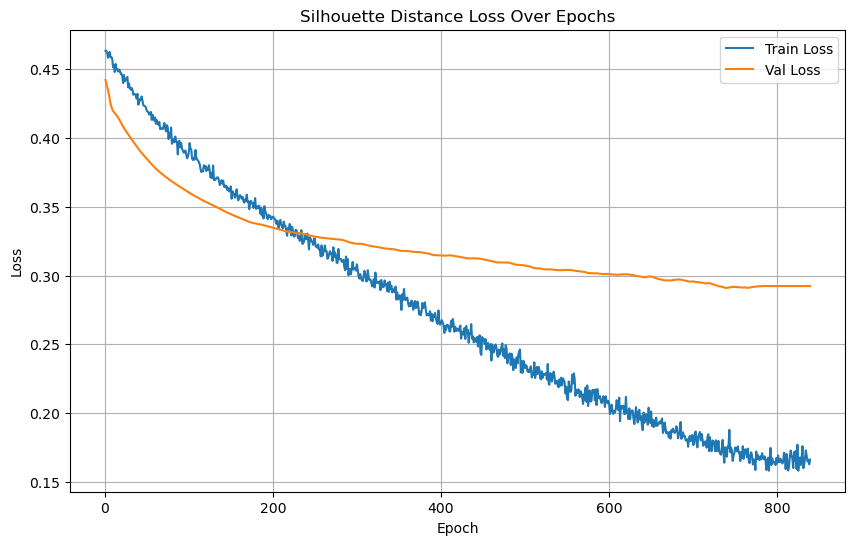

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/665], Loss: 0.2035
Test Batch [20/665], Loss: 0.1857
Test Batch [30/665], Loss: 0.3361


Test Batch [40/665], Loss: 0.4873
Test Batch [50/665], Loss: 0.5726
Test Batch [60/665], Loss: 0.3843
Test Batch [70/665], Loss: 0.2716


Test Batch [80/665], Loss: 0.1816
Test Batch [90/665], Loss: 0.1900
Test Batch [100/665], Loss: 0.1416
Test Batch [110/665], Loss: 0.5000
Test Batch [120/665], Loss: 0.2088


Test Batch [130/665], Loss: 0.1532
Test Batch [140/665], Loss: 0.1642
Test Batch [150/665], Loss: 0.5000
Test Batch [160/665], Loss: 0.1777
Test Batch [170/665], Loss: 0.2985
Test Batch [180/665], Loss: 0.5000


Test Batch [190/665], Loss: 0.1733
Test Batch [200/665], Loss: 0.3331
Test Batch [210/665], Loss: 0.5000
Test Batch [220/665], Loss: 0.1842
Test Batch [230/665], Loss: 0.5000
Test Batch [240/665], Loss: 0.5000
Test Batch [250/665], Loss: 0.5000
Test Batch [260/665], Loss: 0.5000
Test Batch [270/665], Loss: 0.5000
Test Batch [280/665], Loss: 0.5000
Test Batch [290/665], Loss: 0.5000


Test Batch [300/665], Loss: 0.5000
Test Batch [310/665], Loss: 0.1368
Test Batch [320/665], Loss: 0.1392
Test Batch [330/665], Loss: 0.1438


Test Batch [340/665], Loss: 0.1989
Test Batch [350/665], Loss: 0.1648
Test Batch [360/665], Loss: 0.1323


Test Batch [370/665], Loss: 0.1217
Test Batch [380/665], Loss: 0.1821
Test Batch [390/665], Loss: 0.1306


Test Batch [400/665], Loss: 0.0885
Test Batch [410/665], Loss: 0.1354


Test Batch [420/665], Loss: 0.1412
Test Batch [430/665], Loss: 0.1595
Test Batch [440/665], Loss: 0.3241


Test Batch [450/665], Loss: 0.2735
Test Batch [460/665], Loss: 0.3312
Test Batch [470/665], Loss: 0.2749


Test Batch [480/665], Loss: 0.2607
Test Batch [490/665], Loss: 0.1934
Test Batch [500/665], Loss: 0.2822


Test Batch [510/665], Loss: 0.1548
Test Batch [520/665], Loss: 0.2289
Test Batch [530/665], Loss: 0.2178
Test Batch [540/665], Loss: 0.1979


Test Batch [550/665], Loss: 0.1879
Test Batch [560/665], Loss: 0.1876
Test Batch [570/665], Loss: 0.2110
Test Batch [580/665], Loss: 0.1596


Test Batch [590/665], Loss: 0.2415
Test Batch [600/665], Loss: 0.3249
Test Batch [610/665], Loss: 0.2112
Test Batch [620/665], Loss: 0.3887


Test Batch [630/665], Loss: 0.2628
Test Batch [640/665], Loss: 0.2188
Test Batch [650/665], Loss: 0.4205


Test Batch [660/665], Loss: 0.3832

Test Loss: 0.2714


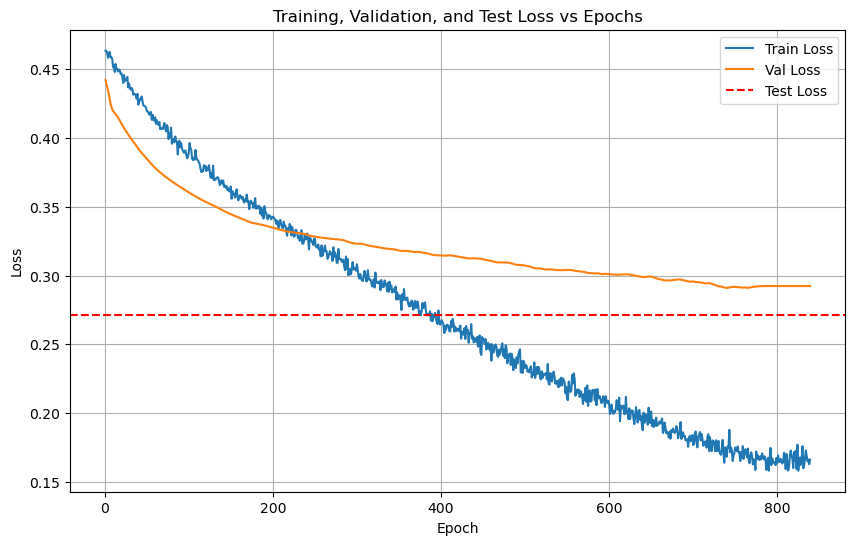

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/665 for test dataset.
  Processed batch 20/665 for test dataset.


  Processed batch 30/665 for test dataset.


  Processed batch 40/665 for test dataset.
  Processed batch 50/665 for test dataset.
  Processed batch 60/665 for test dataset.


  Processed batch 70/665 for test dataset.


  Processed batch 80/665 for test dataset.
  Processed batch 90/665 for test dataset.


  Processed batch 100/665 for test dataset.
  Processed batch 110/665 for test dataset.


  Processed batch 120/665 for test dataset.
  Processed batch 130/665 for test dataset.


  Processed batch 140/665 for test dataset.
  Processed batch 150/665 for test dataset.


  Processed batch 160/665 for test dataset.
  Processed batch 170/665 for test dataset.


  Processed batch 180/665 for test dataset.


  Processed batch 190/665 for test dataset.


  Processed batch 200/665 for test dataset.
  Processed batch 210/665 for test dataset.


  Processed batch 220/665 for test dataset.


  Processed batch 230/665 for test dataset.
  Processed batch 240/665 for test dataset.
  Processed batch 250/665 for test dataset.


  Processed batch 260/665 for test dataset.
  Processed batch 270/665 for test dataset.
  Processed batch 280/665 for test dataset.


  Processed batch 290/665 for test dataset.
  Processed batch 300/665 for test dataset.
  Processed batch 310/665 for test dataset.


  Processed batch 320/665 for test dataset.
  Processed batch 330/665 for test dataset.
  Processed batch 340/665 for test dataset.
  Processed batch 350/665 for test dataset.


  Processed batch 360/665 for test dataset.
  Processed batch 370/665 for test dataset.
  Processed batch 380/665 for test dataset.


  Processed batch 390/665 for test dataset.
  Processed batch 400/665 for test dataset.


  Processed batch 410/665 for test dataset.
  Processed batch 420/665 for test dataset.
  Processed batch 430/665 for test dataset.
  Processed batch 440/665 for test dataset.


  Processed batch 450/665 for test dataset.
  Processed batch 460/665 for test dataset.
  Processed batch 470/665 for test dataset.
  Processed batch 480/665 for test dataset.


  Processed batch 490/665 for test dataset.
  Processed batch 500/665 for test dataset.
  Processed batch 510/665 for test dataset.
  Processed batch 520/665 for test dataset.


  Processed batch 530/665 for test dataset.
  Processed batch 540/665 for test dataset.
  Processed batch 550/665 for test dataset.
  Processed batch 560/665 for test dataset.


  Processed batch 570/665 for test dataset.
  Processed batch 580/665 for test dataset.
  Processed batch 590/665 for test dataset.
  Processed batch 600/665 for test dataset.


  Processed batch 610/665 for test dataset.
  Processed batch 620/665 for test dataset.
  Processed batch 630/665 for test dataset.
  Processed batch 640/665 for test dataset.


  Processed batch 650/665 for test dataset.
  Processed batch 660/665 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.71      1.00      0.83         5
           2       0.60      0.60      0.60         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       0.62      1.00      0.77         5
           7       0.57      0.80      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.78        45
   macro avg       0.72      0.78      0.74        45
weighted avg       0.72      0.78      0.74        45


LOG: Evaluating on the test set...
Test Accuracy: 72.25%

Test Classifica

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.0552  |  Val Loss: 2.0032
Validation loss improved from inf to 2.0032.
[Epoch 2/1000] Train Loss: 1.9894  |  Val Loss: 1.9475
Validation loss improved from 2.0032 to 1.9475.
[Epoch 3/1000] Train Loss: 1.9371  |  Val Loss: 1.8956
Validation loss improved from 1.9475 to 1.8956.
[Epoch 4/1000] Train Loss: 1.8801  |  Val Loss: 1.8487
Validation loss improved from 1.8956 to 1.8487.
[Epoch 5/1000] Train Loss: 1.8312  |  Val Loss: 1.8057
Validation loss improved from 1.8487 to 1.8057.
[Epoch 6/1000] Train Loss: 1.7858  |  Val Loss: 1.7666
Validation loss improved from 1.8057 to 1.7666.
[Epoch 7/1000] Train Loss: 1.7455  |  Val Loss: 1.7312
Validation loss improved from 1.7666 to 1.7312.
[Epoch 8/1000] Train Loss: 1.7082  |  Val Loss: 1.6994
Validation loss improved from 1.7312 to 1.6994.
[Epoch 9/1000] Train Loss: 1.6750  |  Val Loss: 1.6705
Validation loss improved from 1.6994 to 1.6705.
[Epoch 10/1000] Train Loss: 1.6419  |  Val Loss: 1.6445
Validation loss impr

[Epoch 26/1000] Train Loss: 1.3660  |  Val Loss: 1.4221
Validation loss improved from 1.4306 to 1.4221.
[Epoch 27/1000] Train Loss: 1.3549  |  Val Loss: 1.4139
Validation loss improved from 1.4221 to 1.4139.
[Epoch 28/1000] Train Loss: 1.3441  |  Val Loss: 1.4059
Validation loss improved from 1.4139 to 1.4059.
[Epoch 29/1000] Train Loss: 1.3334  |  Val Loss: 1.3979
Validation loss improved from 1.4059 to 1.3979.
[Epoch 30/1000] Train Loss: 1.3228  |  Val Loss: 1.3901
Validation loss improved from 1.3979 to 1.3901.
[Epoch 31/1000] Train Loss: 1.3122  |  Val Loss: 1.3822
Validation loss improved from 1.3901 to 1.3822.
[Epoch 32/1000] Train Loss: 1.3017  |  Val Loss: 1.3744
Validation loss improved from 1.3822 to 1.3744.
[Epoch 33/1000] Train Loss: 1.2910  |  Val Loss: 1.3667
Validation loss improved from 1.3744 to 1.3667.
[Epoch 34/1000] Train Loss: 1.2802  |  Val Loss: 1.3590
Validation loss improved from 1.3667 to 1.3590.
[Epoch 35/1000] Train Loss: 1.2698  |  Val Loss: 1.3512
Validati

[Epoch 58/1000] Train Loss: 0.9714  |  Val Loss: 1.1439
Validation loss improved from 1.1534 to 1.1439.
[Epoch 59/1000] Train Loss: 0.9566  |  Val Loss: 1.1345
Validation loss improved from 1.1439 to 1.1345.
[Epoch 60/1000] Train Loss: 0.9422  |  Val Loss: 1.1250
Validation loss improved from 1.1345 to 1.1250.
[Epoch 61/1000] Train Loss: 0.9268  |  Val Loss: 1.1155
Validation loss improved from 1.1250 to 1.1155.
[Epoch 62/1000] Train Loss: 0.9115  |  Val Loss: 1.1059
Validation loss improved from 1.1155 to 1.1059.
[Epoch 63/1000] Train Loss: 0.8969  |  Val Loss: 1.0964
Validation loss improved from 1.1059 to 1.0964.
[Epoch 64/1000] Train Loss: 0.8813  |  Val Loss: 1.0866
Validation loss improved from 1.0964 to 1.0866.
[Epoch 65/1000] Train Loss: 0.8659  |  Val Loss: 1.0770
Validation loss improved from 1.0866 to 1.0770.
[Epoch 66/1000] Train Loss: 0.8506  |  Val Loss: 1.0674
Validation loss improved from 1.0770 to 1.0674.
[Epoch 67/1000] Train Loss: 0.8356  |  Val Loss: 1.0579
Validati

[Epoch 88/1000] Train Loss: 0.5497  |  Val Loss: 0.8716
Validation loss improved from 0.8793 to 0.8716.
[Epoch 89/1000] Train Loss: 0.5385  |  Val Loss: 0.8640
Validation loss improved from 0.8716 to 0.8640.
[Epoch 90/1000] Train Loss: 0.5270  |  Val Loss: 0.8566
Validation loss improved from 0.8640 to 0.8566.
[Epoch 91/1000] Train Loss: 0.5160  |  Val Loss: 0.8495
Validation loss improved from 0.8566 to 0.8495.
[Epoch 92/1000] Train Loss: 0.5051  |  Val Loss: 0.8424
Validation loss improved from 0.8495 to 0.8424.
[Epoch 93/1000] Train Loss: 0.4948  |  Val Loss: 0.8356
Validation loss improved from 0.8424 to 0.8356.
[Epoch 94/1000] Train Loss: 0.4841  |  Val Loss: 0.8289
Validation loss improved from 0.8356 to 0.8289.
[Epoch 95/1000] Train Loss: 0.4739  |  Val Loss: 0.8225
Validation loss improved from 0.8289 to 0.8225.
[Epoch 96/1000] Train Loss: 0.4635  |  Val Loss: 0.8163
Validation loss improved from 0.8225 to 0.8163.
[Epoch 97/1000] Train Loss: 0.4542  |  Val Loss: 0.8103
Validati

[Epoch 117/1000] Train Loss: 0.2975  |  Val Loss: 0.7210
Validation loss improved from 0.7240 to 0.7210.
[Epoch 118/1000] Train Loss: 0.2915  |  Val Loss: 0.7181
Validation loss improved from 0.7210 to 0.7181.
[Epoch 119/1000] Train Loss: 0.2851  |  Val Loss: 0.7152
Validation loss improved from 0.7181 to 0.7152.
[Epoch 120/1000] Train Loss: 0.2795  |  Val Loss: 0.7125
Validation loss improved from 0.7152 to 0.7125.
[Epoch 121/1000] Train Loss: 0.2736  |  Val Loss: 0.7102
Validation loss improved from 0.7125 to 0.7102.
[Epoch 122/1000] Train Loss: 0.2679  |  Val Loss: 0.7078
Validation loss improved from 0.7102 to 0.7078.
[Epoch 123/1000] Train Loss: 0.2626  |  Val Loss: 0.7057
Validation loss improved from 0.7078 to 0.7057.
[Epoch 124/1000] Train Loss: 0.2571  |  Val Loss: 0.7035
Validation loss improved from 0.7057 to 0.7035.
[Epoch 125/1000] Train Loss: 0.2519  |  Val Loss: 0.7016
Validation loss improved from 0.7035 to 0.7016.
[Epoch 126/1000] Train Loss: 0.2469  |  Val Loss: 0.700

[Epoch 149/1000] Train Loss: 0.1596  |  Val Loss: 0.6775
Validation loss improved from 0.6776 to 0.6775.
[Epoch 150/1000] Train Loss: 0.1570  |  Val Loss: 0.6773
Validation loss improved from 0.6775 to 0.6773.
[Epoch 151/1000] Train Loss: 0.1543  |  Val Loss: 0.6770
Validation loss improved from 0.6773 to 0.6770.
[Epoch 152/1000] Train Loss: 0.1519  |  Val Loss: 0.6766
Validation loss improved from 0.6770 to 0.6766.
[Epoch 153/1000] Train Loss: 0.1494  |  Val Loss: 0.6768
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 0.1469  |  Val Loss: 0.6767
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 0.1446  |  Val Loss: 0.6766
Validation loss improved from 0.6766 to 0.6766.
[Epoch 156/1000] Train Loss: 0.1426  |  Val Loss: 0.6766
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 0.1402  |  Val Loss: 0.6765
Validation loss improved from 0.6766 to 0.6765.
[Epoch 158/1000] Train Loss: 0.1380  

[Epoch 183/1000] Train Loss: 0.0996  |  Val Loss: 0.6796
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 184/1000] Train Loss: 0.0986  |  Val Loss: 0.6799
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 185/1000] Train Loss: 0.0975  |  Val Loss: 0.6804
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 186/1000] Train Loss: 0.0964  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 187/1000] Train Loss: 0.0955  |  Val Loss: 0.6816
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 188/1000] Train Loss: 0.0944  |  Val Loss: 0.6820
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 189/1000] Train Loss: 0.0934  |  Val Loss: 0.6823
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 190/1000] Train Loss: 0.0925  |  Val Loss: 0.6828
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 191/1000] Train Loss: 0.0916  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience:

[Epoch 214/1000] Train Loss: 0.0750  |  Val Loss: 0.6942
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 215/1000] Train Loss: 0.0744  |  Val Loss: 0.6946
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 216/1000] Train Loss: 0.0738  |  Val Loss: 0.6955
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 217/1000] Train Loss: 0.0733  |  Val Loss: 0.6963
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 218/1000] Train Loss: 0.0729  |  Val Loss: 0.6975
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 219/1000] Train Loss: 0.0722  |  Val Loss: 0.6982
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 220/1000] Train Loss: 0.0718  |  Val Loss: 0.6987
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 221/1000] Train Loss: 0.0714  |  Val Loss: 0.6998
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 222/1000] Train Loss: 0.0707  |  Val Loss: 0.7004
!! Validation loss did NOT improve !! Patience:

[Epoch 245/1000] Train Loss: 0.0615  |  Val Loss: 0.7122
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 246/1000] Train Loss: 0.0612  |  Val Loss: 0.7124
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 247/1000] Train Loss: 0.0609  |  Val Loss: 0.7131
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 248/1000] Train Loss: 0.0605  |  Val Loss: 0.7137
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 249/1000] Train Loss: 0.0603  |  Val Loss: 0.7140
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 250/1000] Train Loss: 0.0600  |  Val Loss: 0.7150
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 251/1000] Train Loss: 0.0596  |  Val Loss: 0.7159
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 252/1000] Train Loss: 0.0594  |  Val Loss: 0.7160
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 253/1000] Train Loss: 0.0590  |  Val Loss: 0.7167
!! Validation loss did NOT improve !! Patience:

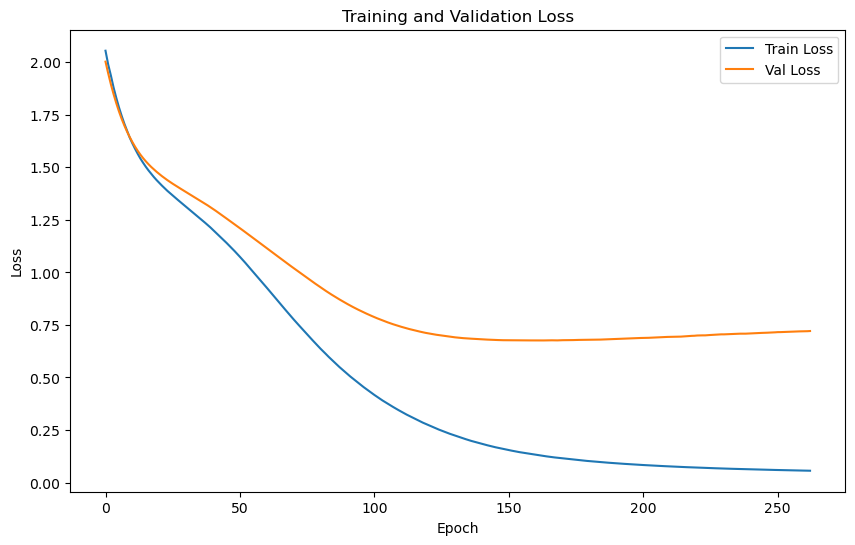

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.3865 | Test Accuracy: 72.37%


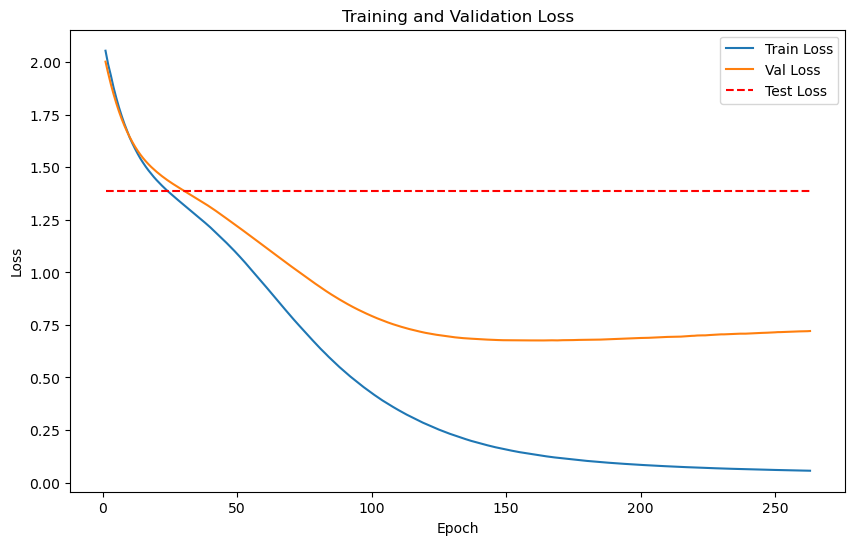

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


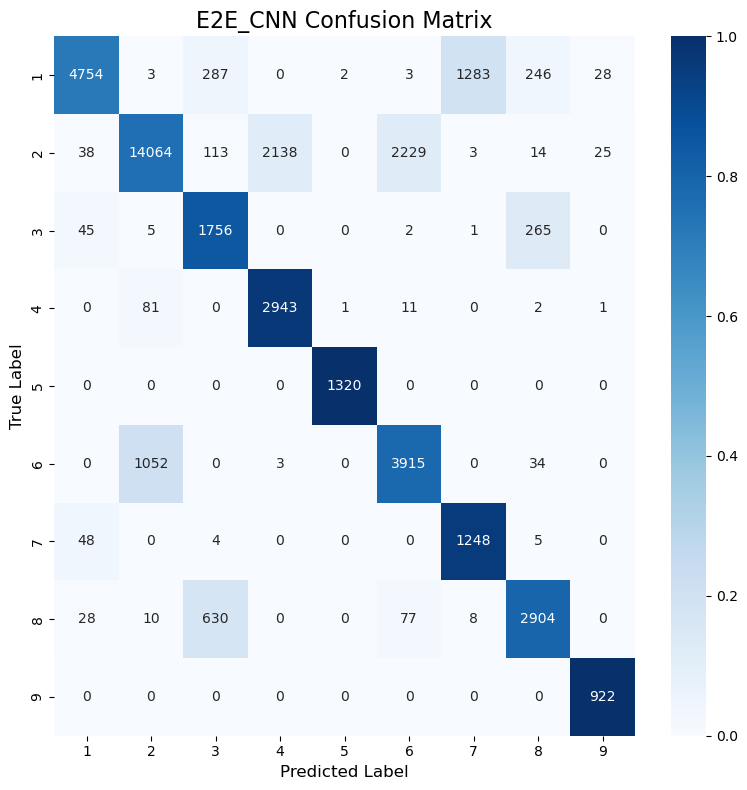

Classification Accuracy: 79.50%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


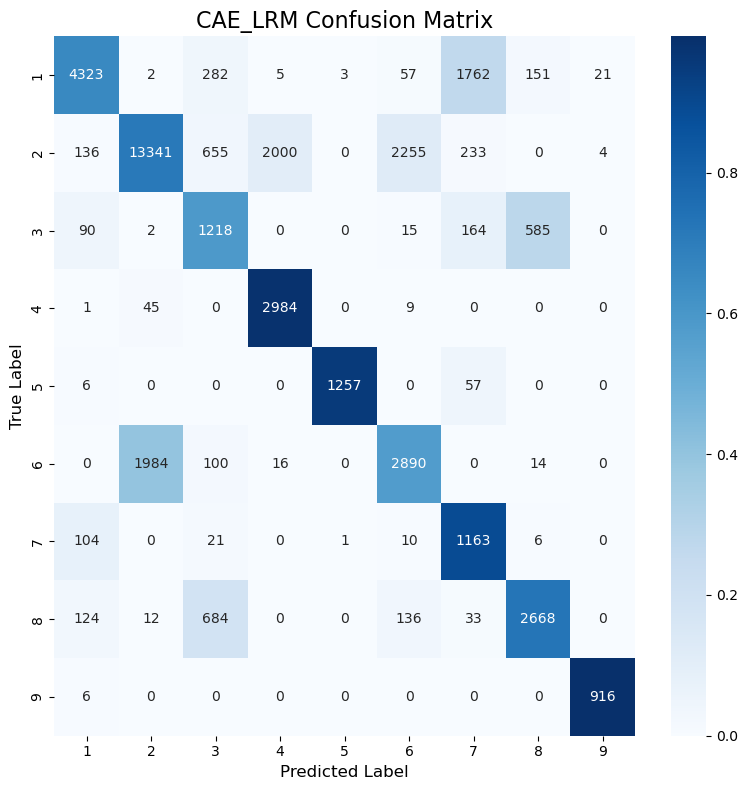

Classification Accuracy: 72.29%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


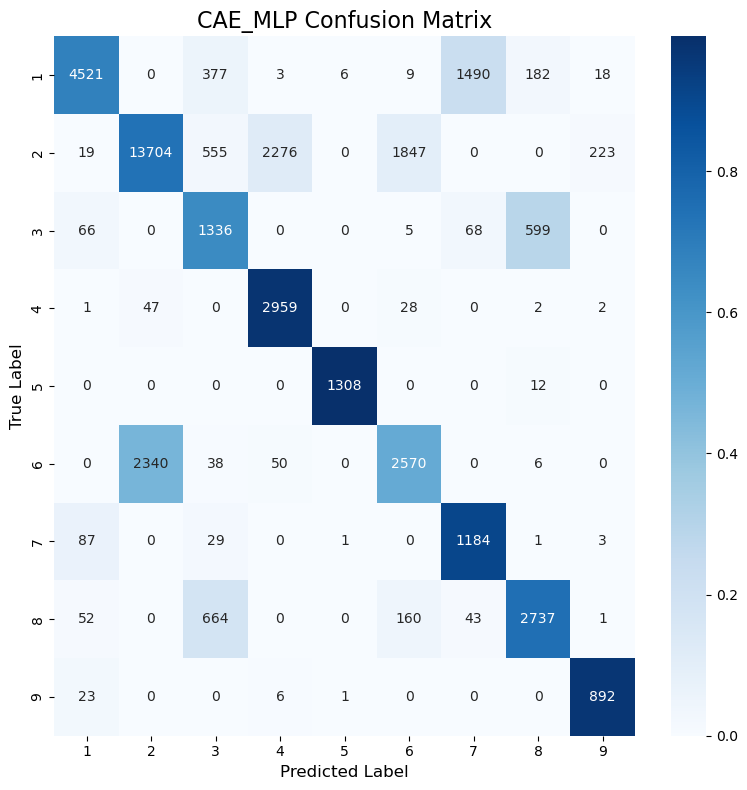

Classification Accuracy: 73.35%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


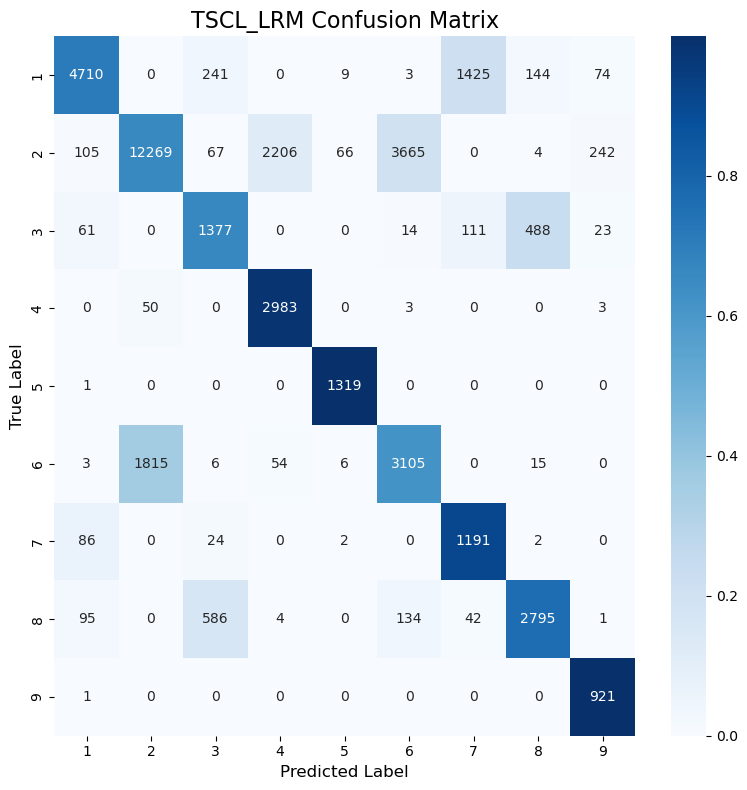

Classification Accuracy: 72.08%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


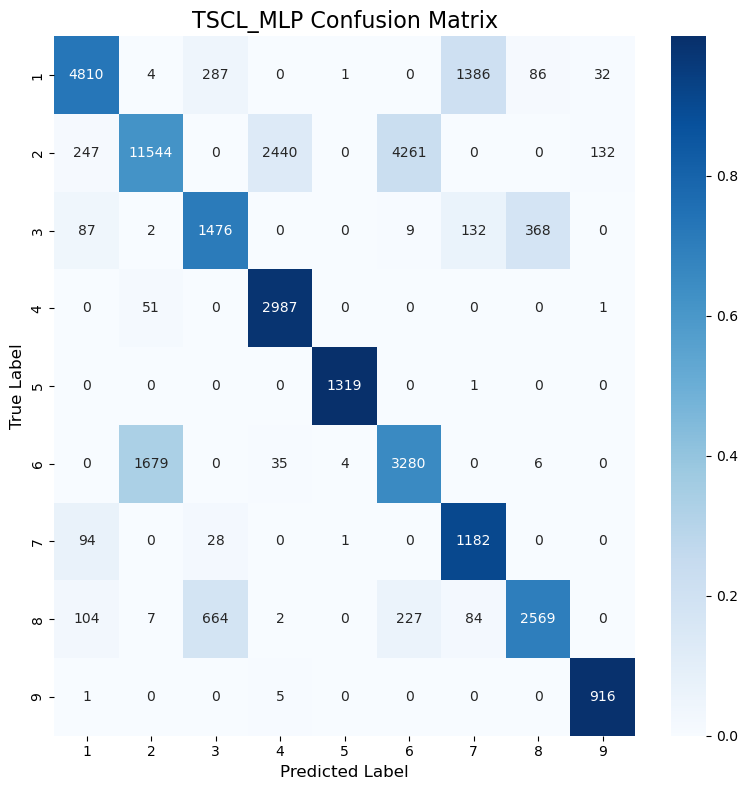

Classification Accuracy: 70.70%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


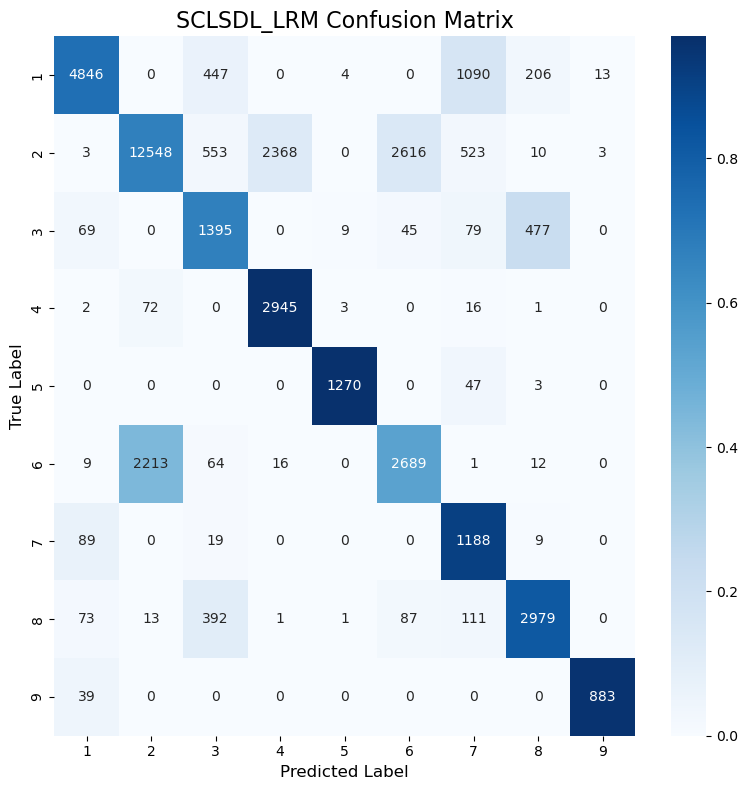

Classification Accuracy: 72.25%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


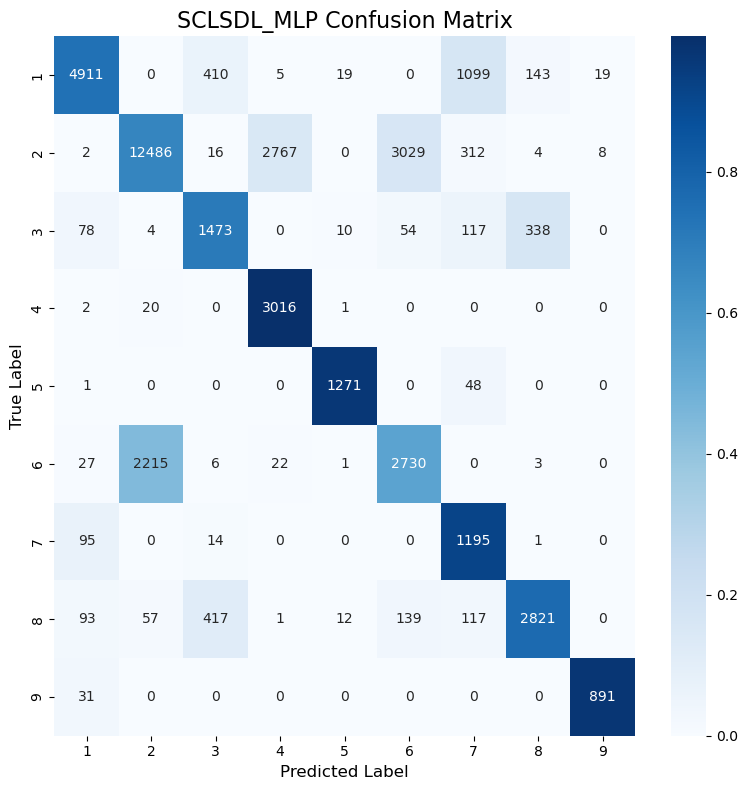

Classification Accuracy: 72.37%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          79.50
1    LRM (CAE)          72.29
2    MLP (CAE)          73.35
3     TSCL LRM          72.08
4     TSCL MLP          70.70
5  SCL_SDL LRM          72.25
6  SCL_SDL MLP          72.37

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          79.50
2    MLP (CAE)          73.35
6  SCL_SDL MLP          72.37
1    LRM (CAE)          72.29
5  SCL_SDL LRM          72.25
3     TSCL LRM          72.08
4     TSCL MLP          70.70
